In [17]:
from sklearn.preprocessing import MinMaxScaler
from kmodes.kmodes import KModes
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow as tf
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
warnings.simplefilter('ignore')
from art.attacks.evasion import HopSkipJump
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import DeepFool
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer
from art.evaluations.security_curve import SecurityCurve
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adam
#from art.estimators.classification import KerasClassifier
from art.estimators.classification import KerasClassifier as ARTKerasClassifier
from sklearn.preprocessing import normalize
from art.utils import random_targets

# 1 Data Exploration and Preprocessing

In [2]:
columns = ["existing_account", "month_duration", "credit_history",
                        "purpose", "credit_amount", "saving_bonds",
                        "employment_status", "installment_rate", "status_sex",
                        "debts_status", "resident_since", "property",
                        "age", "installment_plans", "housing_status",
                        "credit_number", "job", "people_liability",
                        "telephone", "foreign", "result"]

numerical_attributes = ["month_duration", "credit_amount", "installment_rate", "resident_since", "age",
                                     "credit_number", "people_liability"]

In [3]:
def one_hot_encoding(df):
    df_numerical = df.copy()
    dummy_columns = ["credit_history", "purpose", "status_sex",
                     "debts_status", "property", "installment_plans",
                     "housing_status", "foreign", "existing_account",
                     "saving_bonds", "telephone", "job", "employment_status"]
    df_numerical = pd.get_dummies(df_numerical, columns=dummy_columns, drop_first=False)
    df_numerical_hot = df_numerical.replace([True, False], [1, 0])
    df_numerical_hot['result'] = df_numerical_hot['result'].replace([2, 1], [1, 0])
    return df_numerical_hot

def normalization(df):
    numerical_columns = numerical_attributes
    scaler = MinMaxScaler()
    df_copy = df.copy()
    df_normalized = scaler.fit_transform(df_copy)
    return df_normalized

def split_data(X,y,test_size=0.2):
    X_train_validation, X_test, y_train_validation, y_test = train_test_split(X,y,stratify=y,test_size=test_size,random_state=13)
    return X_train_validation, y_train_validation, X_test, y_test

## 1.1 Dataset Acquisition

In [4]:
df = pd.read_csv("../Dataset/german.data", sep=" ", header=None, names=columns)

In [5]:
df

existing_account  month_duration credit_history purpose  credit_amount  \
0                A11               6            A34     A43           1169   
1                A12              48            A32     A43           5951   
2                A14              12            A34     A46           2096   
3                A11              42            A32     A42           7882   
4                A11              24            A33     A40           4870   
..               ...             ...            ...     ...            ...   
995              A14              12            A32     A42           1736   
996              A11              30            A32     A41           3857   
997              A14              12            A32     A43            804   
998              A11              45            A32     A43           1845   
999              A12              45            A34     A41           4576   

    saving_bonds employment_status  installment_rate status_sex debts_status  \
0            A65               A75                 4        A93         A101   
1            A61               A73                 2        A92         A101   
2            A61               A74                 2        A93         A101   
3            A61               A74                 2        A93         A103   
4            A61               A73                 3        A93         A101   
..           ...               ...               ...        ...          ...   
995          A61               A74                 3        A92         A101   
996          A61               A73                 4        A91         A101   
997          A61               A75                 4        A93         A101   
998          A61               A73                 4        A93         A101   
999          A62               A71                 3        A93         A101   

     ...  property age  installment_plans housing_status credit_number   job  \
0    ...      A121  67               A143           A152             2  A173   
1    ...      A121  22               A143           A152             1  A173   
2    ...      A121  49               A143           A152             1  A172   
3    ...      A122  45               A143           A153             1  A173   
4    ...      A124  53               A143           A153             2  A173   
..   ...       ...  ..                ...            ...           ...   ...   
995  ...      A121  31               A143           A152             1  A172   
996  ...      A122  40               A143           A152             1  A174   
997  ...      A123  38               A143           A152             1  A173   
998  ...      A124  23               A143           A153             1  A173   
999  ...      A123  27               A143           A152             1  A173   

    people_liability  telephone foreign result  
0                  1       A192    A201      1  
1                  1       A191    A201      2  
2                  2       A191    A201      1  
3                  2       A191    A201      1  
4                  2       A191    A201      2  
..               ...        ...     ...    ...  
995                1       A191    A201      1  
996                1       A192    A201      1  
997                1       A191    A201      1  
998                1       A192    A201      2  
999                1       A191    A201      1  

[1000 rows x 21 columns]

## 1.2 Preprocessing

We perform only the one_hot_encoding here, while the data normalization for the supervised learning is inserted in the pipeline used in the nested cross-validation for each model in order to avoid data leakage from the training to the validation set. Regarding the unsupervised learning the data will be normalized before processing it.


In [5]:
df_one_hot_encoded = one_hot_encoding(df)
X_train_validation, y_train_validation, X_test, y_test = split_data(X=df_one_hot_encoded.drop(columns="result"), y=df_one_hot_encoded["result"])
X_train_validation = pd.DataFrame(normalization(X_train_validation), columns=X_train_validation.columns)
X_test = pd.DataFrame(normalization(X_test), columns=X_test.columns)
df_one_hot_encoded

month_duration  credit_amount  installment_rate  resident_since  age  \
0                 6           1169                 4               4   67   
1                48           5951                 2               2   22   
2                12           2096                 2               3   49   
3                42           7882                 2               4   45   
4                24           4870                 3               4   53   
..              ...            ...               ...             ...  ...   
995              12           1736                 3               4   31   
996              30           3857                 4               4   40   
997              12            804                 4               4   38   
998              45           1845                 4               4   23   
999              45           4576                 3               4   27   

     credit_number  people_liability  result  credit_history_A30  \
0                2                 1       0                   0   
1                1                 1       1                   0   
2                1                 2       0                   0   
3                1                 2       0                   0   
4                2                 2       1                   0   
..             ...               ...     ...                 ...   
995              1                 1       0                   0   
996              1                 1       0                   0   
997              1                 1       0                   0   
998              1                 1       1                   0   
999              1                 1       0                   0   

     credit_history_A31  ...  telephone_A192  job_A171  job_A172  job_A173  \
0                     0  ...               1         0         0         1   
1                     0  ...               0         0         0         1   
2                     0  ...               0         0         1         0   
3                     0  ...               0         0         0         1   
4                     0  ...               0         0         0         1   
..                  ...  ...             ...       ...       ...       ...   
995                   0  ...               0         0         1         0   
996                   0  ...               1         0         0         0   
997                   0  ...               0         0         0         1   
998                   0  ...               1         0         0         1   
999                   0  ...               0         0         0         1   

     job_A174  employment_status_A71  employment_status_A72  \
0           0                      0                      0   
1           0                      0                      0   
2           0                      0                      0   
3           0                      0                      0   
4           0                      0                      0   
..        ...                    ...                    ...   
995         0                      0                      0   
996         1                      0                      0   
997         0                      0                      0   
998         0                      0                      0   
999         0                      1                      0   

     employment_status_A73  employment_status_A74  employment_status_A75  
0                        0                      0                      1  
1                        1                      0                      0  
2                        0                      1                      0  
3                        0                      1                      0  
4                        1                      0                      0  
..                     ...                    ...                    ...  
995                      0                  

## 1.3 EDA

In [7]:
numerical_attributes = ["month_duration", "credit_amount", "installment_rate", "resident_since", "age",\
                        "credit_number", "people_liability"]
#rudimental encoding, just for easier plotting
df_encode = df.copy()
for column in df.select_dtypes(include=['object']).columns:
    df_encode[column] = df[column].astype('category').cat.codes + 1
display(df_encode)


existing_account  month_duration  credit_history  purpose  credit_amount  \
0                   1               6               5        5           1169   
1                   2              48               3        5           5951   
2                   4              12               5        8           2096   
3                   1              42               3        4           7882   
4                   1              24               4        1           4870   
..                ...             ...             ...      ...            ...   
995                 4              12               3        4           1736   
996                 1              30               3        2           3857   
997                 4              12               3        5            804   
998                 1              45               3        5           1845   
999                 2              45               5        2           4576   

     saving_bonds  employment_status  installment_rate  status_sex  \
0               5                  5                 4           3   
1               1                  3                 2           2   
2               1                  4                 2           3   
3               1                  4                 2           3   
4               1                  3                 3           3   
..            ...                ...               ...         ...   
995             1                  4                 3           2   
996             1                  3                 4           1   
997             1                  5                 4           3   
998             1                  3                 4           3   
999             2                  1                 3           3   

     debts_status  ...  property  age  installment_plans  housing_status  \
0               1  ...         1   67                  3               2   
1               1  ...         1   22                  3               2   
2               1  ...         1   49                  3               2   
3               3  ...         2   45                  3               3   
4               1  ...         4   53                  3               3   
..            ...  ...       ...  ...                ...             ...   
995             1  ...         1   31                  3               2   
996             1  ...         2   40                  3               2   
997             1  ...         3   38                  3               2   
998             1  ...         4   23                  3               3   
999             1  ...         3   27                  3               2   

     credit_number  job  people_liability  telephone  foreign  result  
0                2    3                 1          2        1       1  
1                1    3                 1          1        1       2  
2                1    2                 2          1        1       1  
3                1    3                 2          1        1       1  
4                2    3                 2          1        1       2  
..             ...  ...               ...        ...      ...     ...  
995              1    2                 1          1        1       1  
996              1    4                 1          2        1       1  
997              1    3                 1          1        1       1  
998              1    3                 1          2        1       2  
999              1    3                 1          1        1       1  

[1000 rows x 21 columns]

### General Dataset Statistics

In [8]:
df.describe()

month_duration  credit_amount  installment_rate  resident_since  \
count     1000.000000    1000.000000       1000.000000     1000.000000   
mean        20.903000    3271.258000          2.973000        2.845000   
std         12.058814    2822.736876          1.118715        1.103718   
min          4.000000     250.000000          1.000000        1.000000   
25%         12.000000    1365.500000          2.000000        2.000000   
50%         18.000000    2319.500000          3.000000        3.000000   
75%         24.000000    3972.250000          4.000000        4.000000   
max         72.000000   18424.000000          4.000000        4.000000   

               age  credit_number  people_liability       result  
count  1000.000000    1000.000000       1000.000000  1000.000000  
mean     35.546000       1.407000          1.155000     1.300000  
std      11.375469       0.577654          0.362086     0.458487  
min      19.000000       1.000000          1.000000     1.000000  
25%      27.000000       1.000000          1.000000     1.000000  
50%      33.000000       1.000000          1.000000     1.000000  
75%      42.000000       2.000000          1.000000     2.000000  
max      75.000000       4.000000          2.000000     2.000000

#### General Eligible Statistics

In [9]:
eligible = df[df["result"] == 1].drop(columns=["result"])
eligible.describe()

month_duration  credit_amount  installment_rate  resident_since  \
count      700.000000     700.000000        700.000000      700.000000   
mean        19.207143    2985.457143          2.920000        2.842857   
std         11.079564    2401.472278          1.128078        1.108373   
min          4.000000     250.000000          1.000000        1.000000   
25%         12.000000    1375.500000          2.000000        2.000000   
50%         18.000000    2244.000000          3.000000        3.000000   
75%         24.000000    3634.750000          4.000000        4.000000   
max         60.000000   15857.000000          4.000000        4.000000   

              age  credit_number  people_liability  
count  700.000000     700.000000        700.000000  
mean    36.224286       1.424286          1.155714  
std     11.381145       0.584721          0.362844  
min     19.000000       1.000000          1.000000  
25%     27.000000       1.000000          1.000000  
50%     34.000000       1.000000          1.000000  
75%     42.250000       2.000000          1.000000  
max     75.000000       4.000000          2.000000

#### General Non-Eligible Statistics

In [10]:

not_eligible = df[df["result"] == 2].drop(columns=["result"])
not_eligible.describe()

month_duration  credit_amount  installment_rate  resident_since  \
count      300.000000     300.000000        300.000000      300.000000   
mean        24.860000    3938.126667          3.096667        2.850000   
std         13.282639    3535.818955          1.088395        1.094605   
min          6.000000     433.000000          1.000000        1.000000   
25%         12.000000    1352.500000          2.000000        2.000000   
50%         24.000000    2574.500000          4.000000        3.000000   
75%         36.000000    5141.500000          4.000000        4.000000   
max         72.000000   18424.000000          4.000000        4.000000   

              age  credit_number  people_liability  
count  300.000000     300.000000        300.000000  
mean    33.963333       1.366667          1.153333  
std     11.222379       0.559702          0.360911  
min     19.000000       1.000000          1.000000  
25%     25.000000       1.000000          1.000000  
50%     31.000000       1.000000          1.000000  
75%     40.000000       2.000000          1.000000  
max     74.000000       4.000000          2.000000

We can note that the features "month_duration" and "credit_amount" are generally higher in the Non-Eligible entries in respect to the Eligible ones. In respect to the latter the 25% and 50% cuts are similar, while the situation drastically changes for the 75% cut.

### Target Distribution


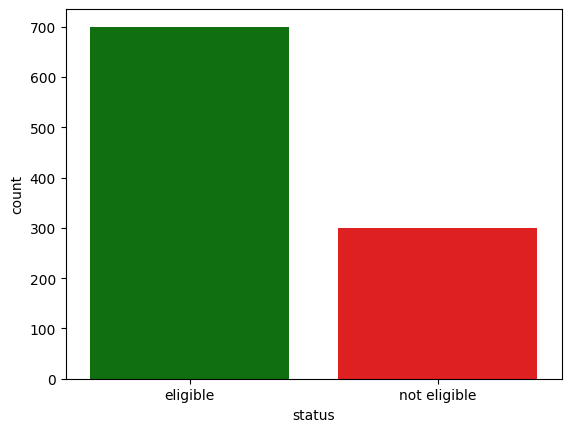

In [11]:

eligible["status"] = "eligible"
not_eligible["status"] = "not eligible"
combined_df = pd.concat([eligible, not_eligible])
sns.countplot(data=combined_df, x="status",palette={"eligible": "green", "not eligible": "red"})
eligible.drop(columns="status")
not_eligible.drop(columns="status")
plt.show()

Unbalanced Dataset: 70% of the entries are low risk loans, while the remaining are high risk loans. To deal with it we will stratify our training and test sets based on the "result" column for the Clustering. Similarly, we will implement stratified k-fold crossvalidation for the Supervised Learning.

### Correlation Matrixes


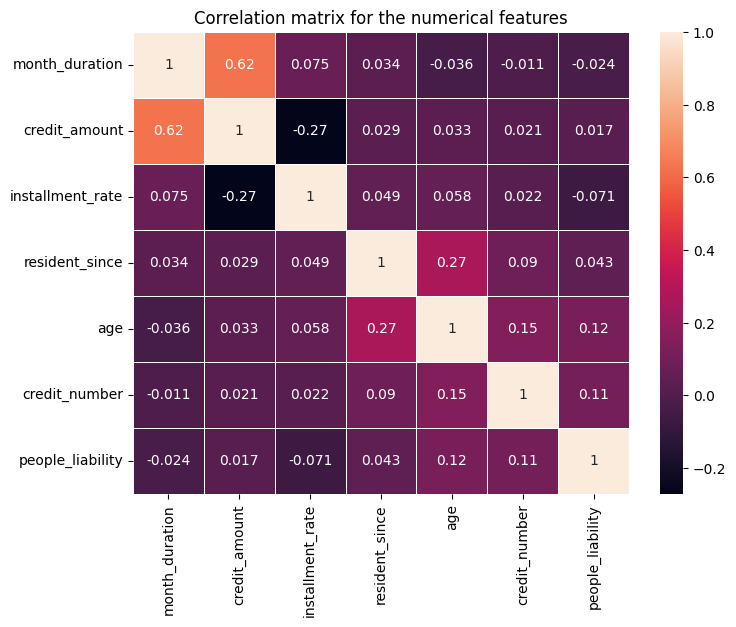

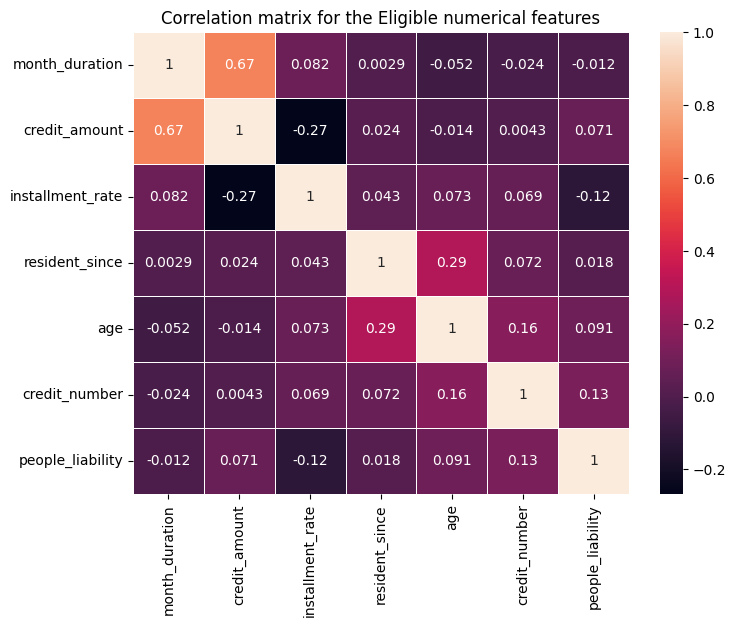

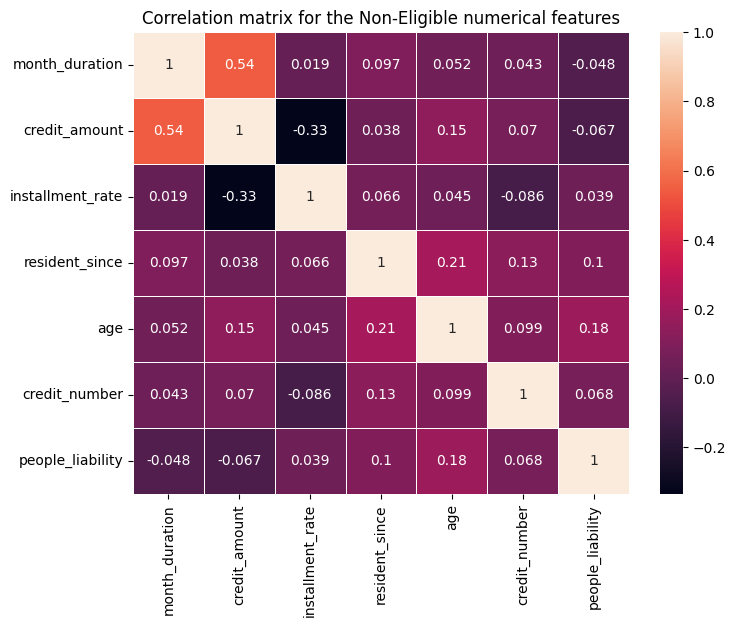

In [12]:

corr = df[numerical_attributes].corr()
fig, ax = plt.subplots(figsize=(8,6)) 
ax = sns.heatmap(corr, annot=True, linewidth=0.5, xticklabels=numerical_attributes)
ax.set_yticklabels(labels=numerical_attributes, rotation=0)
ax.set_title("Correlation matrix for the numerical features")
plt.show()
eligible =df[df["result"] == 1 ]
corr = eligible[numerical_attributes].corr()
fig, ax = plt.subplots(figsize=(8,6)) 
ax = sns.heatmap(corr, annot=True, linewidth=0.5, xticklabels=numerical_attributes)
ax.set_yticklabels(labels=numerical_attributes, rotation=0)
ax.set_title("Correlation matrix for the Eligible numerical features")
plt.show()
not_eligible =df[df["result"] == 2 ]
corr = not_eligible[numerical_attributes].corr()
fig, ax = plt.subplots(figsize=(8,6)) 
ax = sns.heatmap(corr, annot=True, linewidth=0.5, xticklabels=numerical_attributes)
ax.set_yticklabels(labels=numerical_attributes, rotation=0)
ax.set_title("Correlation matrix for the Non-Eligible numerical features")
plt.show()

From the correlation matrix of the numerical attributes we can note that credit_amount and month_duration are the most correlated features. In addition no great differences are found between the correlation matrixes of Eligible and Non-Eligible entries.

### Age

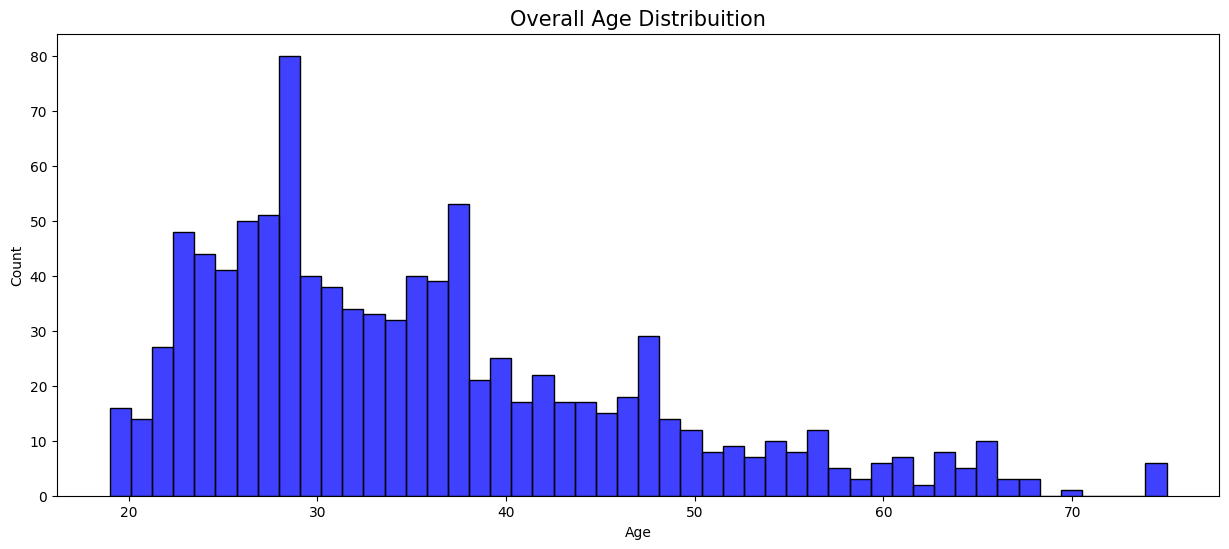

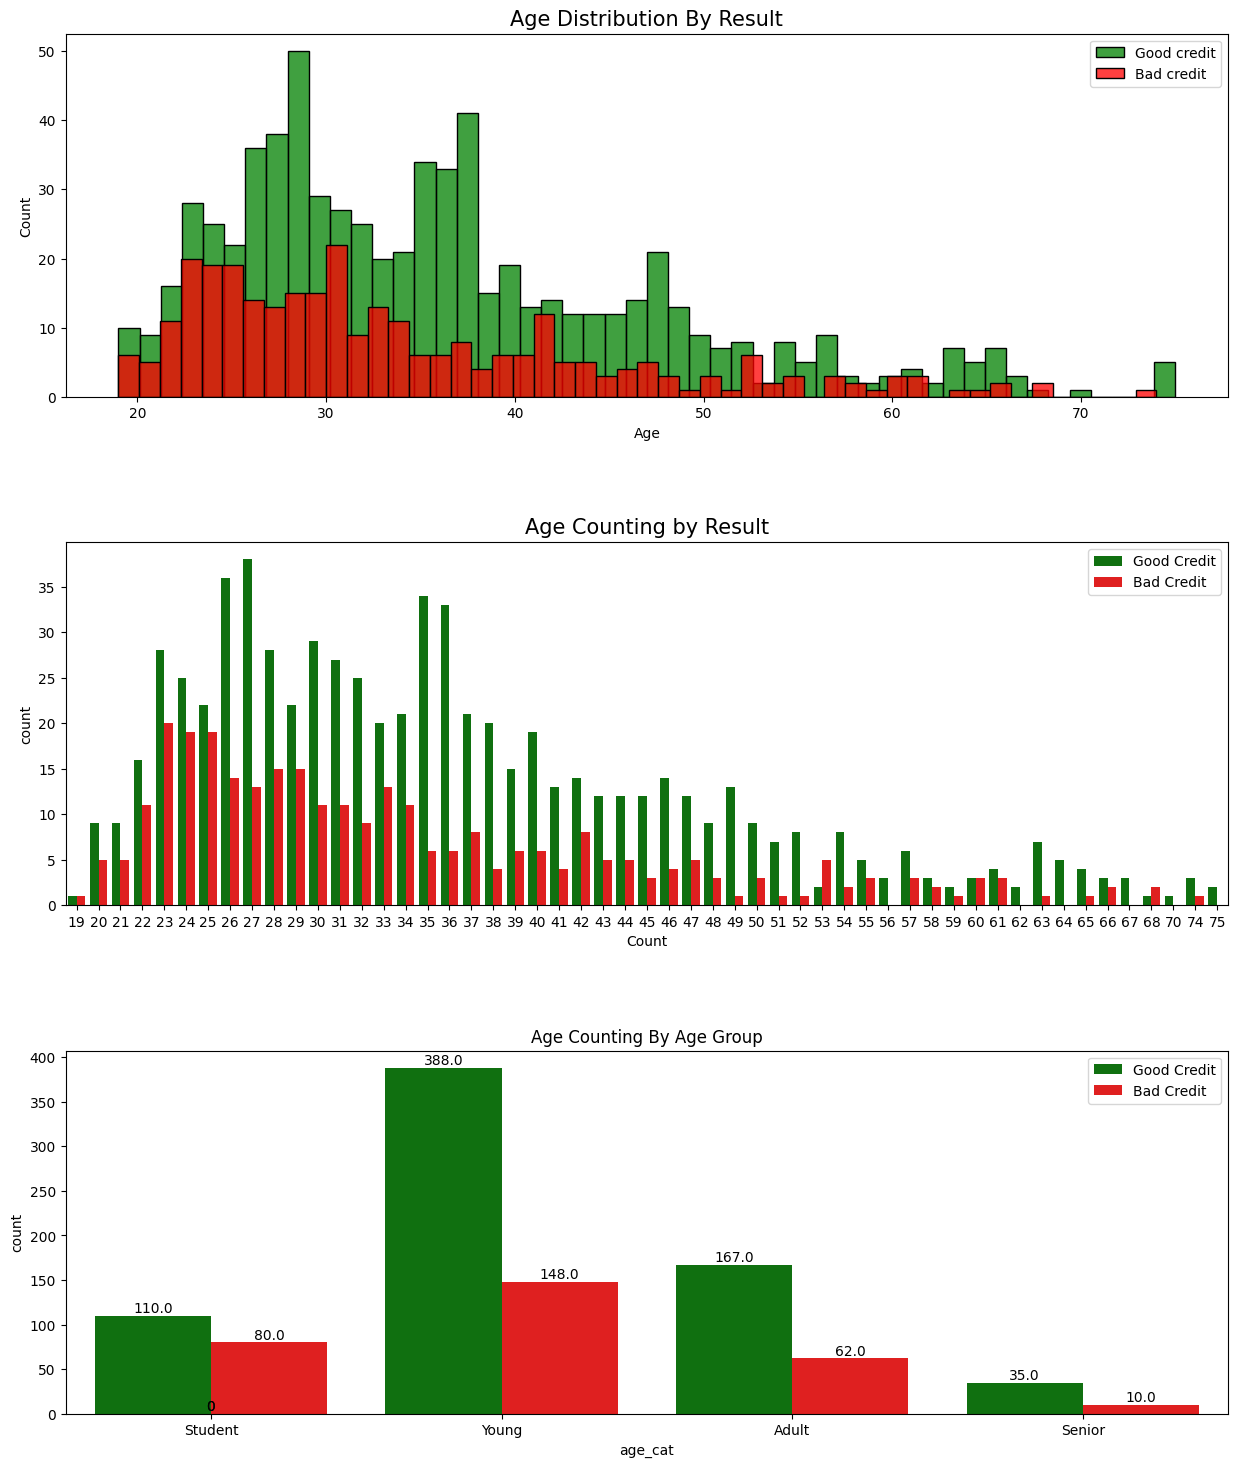

% Ratio Student Category: 58%
% Ratio Young Category: 72%
% Ratio Adult Category: 73%
% Ratio Senior Category: 78%


In [13]:
interval = (18, 25, 40, 60, 120)
cats = ['Student', 'Young', 'Adult', 'Senior']
df["age_cat"] = pd.cut(df.age, interval, labels=cats)

df_good = df[df["result"] == 1]
df_bad = df[df["result"] == 2]
plt.figure(figsize=(15,6))
g0 = sns.histplot(
        df["age"], 
        color="Blue",
        bins = 50,
)
g0.set_title("Overall Age Distribuition", fontsize=15)
g0.set_xlabel("Age")
g0.set_ylabel("Count")
plt.show()

fig, axes = plt.subplots(nrows=3, figsize=(15,20))
plt.subplots_adjust(hspace = 0.4, top = 0.8)


g1 = sns.histplot(
        df_good["age"], 
        ax=axes[0], 
        color="green",
        bins = 50,
        label = 'Good credit'
)
g1 = sns.histplot(
        df_bad["age"],
        ax=axes[0], 
        color='red',
        bins = 50,
        label = 'Bad credit'
)
axes[0].legend()

g1.set_title("Age Distribution By Result", fontsize=15)
g1.set_xlabel("Age")
g1.set_ylabel("Count")
custom_palette = ["green", "red"]
g2 = sns.countplot(
    x="age",
    data=df, 
    ax=axes[1], 
    palette=custom_palette,
    hue = "result"
)

g2.set_title("Age Counting by Result", fontsize=15)
g2.set_xlabel("Age")
g2.set_xlabel("Count")
g2.legend(labels=["Good Credit", "Bad Credit"])

g3 = sns.countplot(
    data = df,
    x = "age_cat",
    ax=axes[2], 
    palette=custom_palette,
    hue = 'result'
)

list_height = []
for bar in g3.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    list_height.append(y)
    g3.annotate(f'{y}', (x, y), ha='center', va='bottom')

g3.legend(labels=["Good Credit", "Bad Credit"])
g3.set_title("Age Counting By Age Group")
g2.set_xlabel("Age category")
g2.set_xlabel("Count")
plt.show()
res = []
for i in range(4):
    res = list_height[i]/(list_height[i]+list_height[i+4])*100
    print(f"% Ratio {cats[i]} Category: {round(res)}%")


In the last plot by feature engineering all the dataset entries into 4 different groups: Student, Young, Adult and Senior based on their age, we delve into studying if the age group could matter in the outcome of the credit.
As the ratios show it seems that in Student group, aged from 18 to 25, it's more likely to encounter a bad credit in respect to the 70 / 30 general split of the dataset. On the other hand, for the Senior category (age greater equal than 60) a positive outcome is more probable. Additionally, the ratio seems increasing with the increasing of the age group. Therefore a question arouses:

- Could it be that older people by possessing more money or having a more stable, senior job in comparison than students are more likely to be good creditors? Or also the fact that some of them may already possess housing...

To reply to this question we will delve into studying if the age is moderated by other variables such as existing_account, saving_bonds, job, housing_status

### Duration


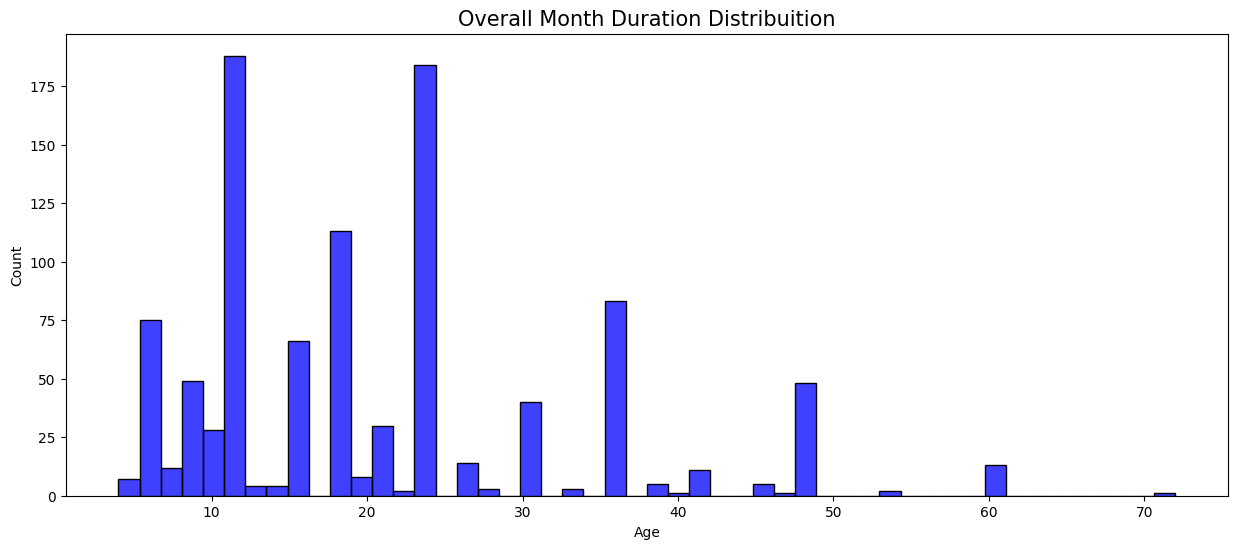

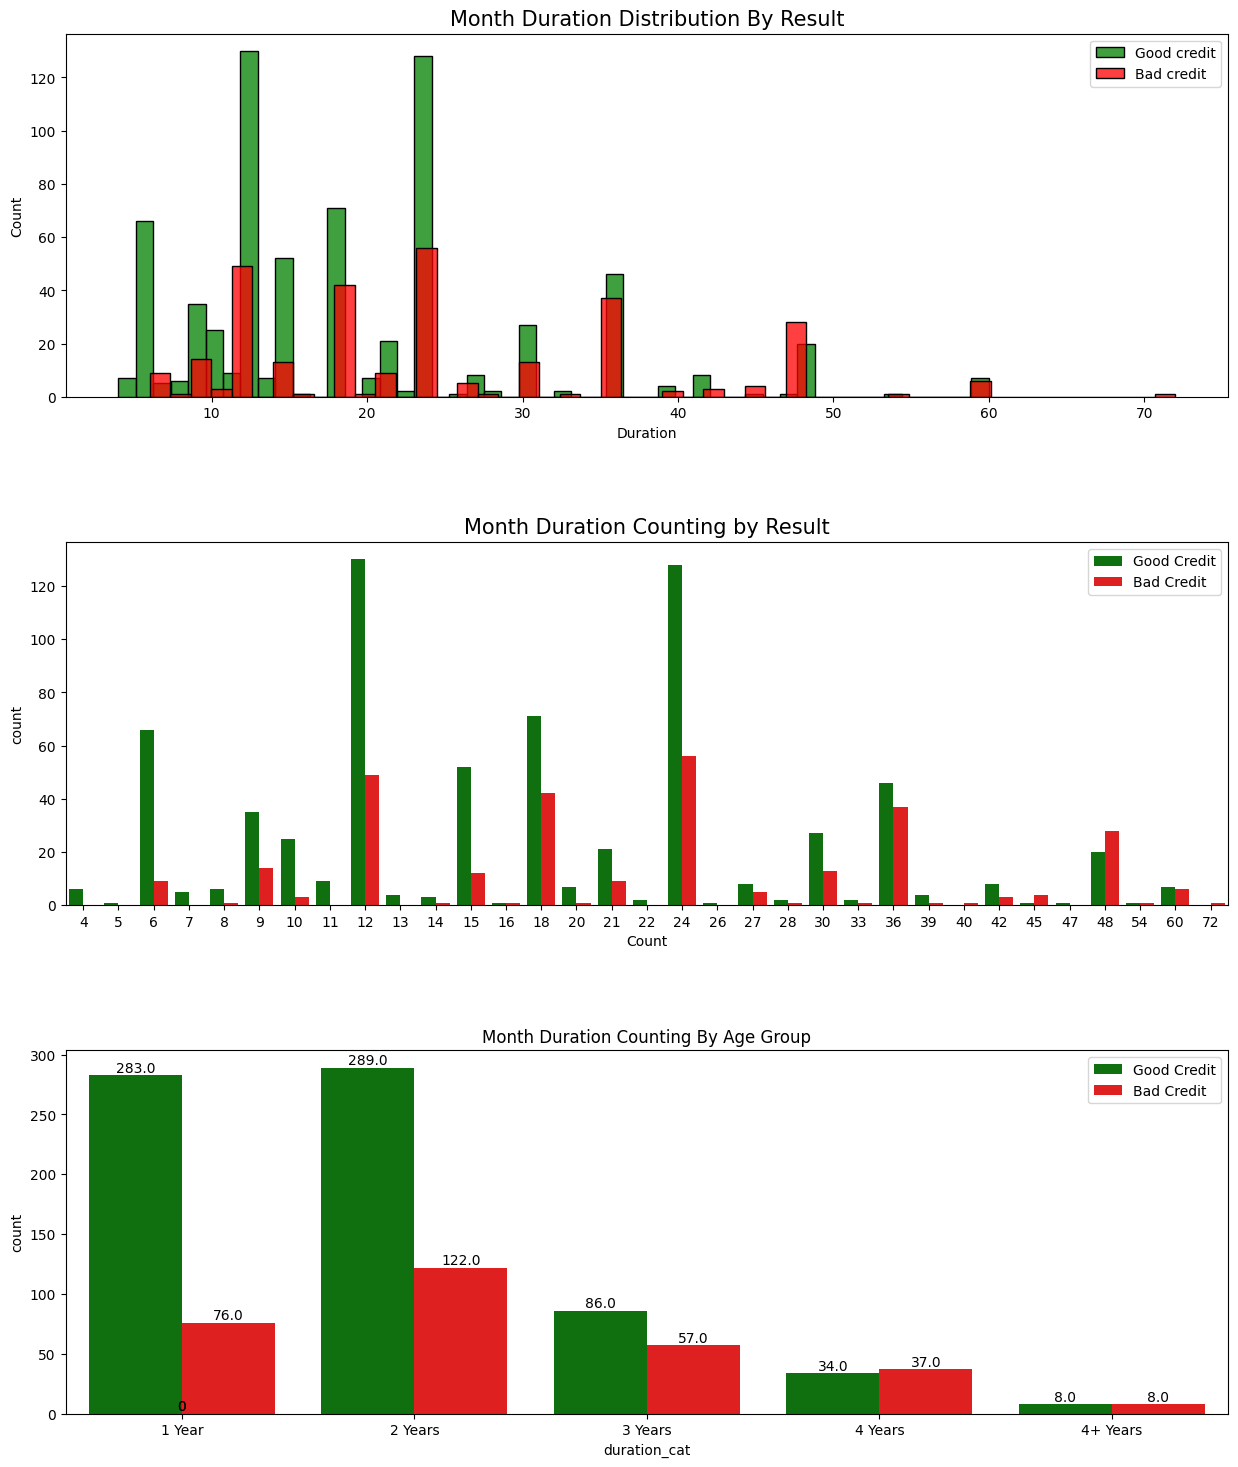

% Ratio 1 Year Category: 79%
% Ratio 2 Years Category: 70%
% Ratio 3 Years Category: 60%
% Ratio 4 Years Category: 48%
% Ratio 4+ Years Category: 50%


In [14]:

interval = (0,12, 24, 36, 48, 100)
cats = ['1 Year', '2 Years', '3 Years', '4 Years','4+ Years']
df["duration_cat"] = pd.cut(df.month_duration, interval, labels=cats)

plt.figure(figsize=(15,6))
g0 = sns.histplot(
        df["month_duration"], 
        color="Blue",
        bins = 50,
)
g0.set_title("Overall Month Duration Distribuition", fontsize=15)
g0.set_xlabel("Age")
g0.set_ylabel("Count")
plt.show()

fig, axes = plt.subplots(nrows=3, figsize=(15,20))
plt.subplots_adjust(hspace = 0.4, top = 0.8)


g1 = sns.histplot(
        df_good["month_duration"], 
        ax=axes[0], 
        color="green",
        bins=50,
        label = 'Good credit'
)
g1 = sns.histplot(
        df_bad["month_duration"],
        ax=axes[0], 
        color='red',
        bins=50,
        label = 'Bad credit'
)
axes[0].legend()

g1.set_title("Month Duration Distribution By Result", fontsize=15)
g1.set_xlabel("Duration")
g1.set_ylabel("Count")
custom_palette = ["green", "red"]
g2 = sns.countplot(
    x="month_duration",
    data=df, 
    ax=axes[1], 
    palette=custom_palette,
    hue = "result"
)

g2.set_title("Month Duration Counting by Result", fontsize=15)
g2.set_xlabel("Duration")
g2.set_xlabel("Count")
g2.legend(labels=["Good Credit", "Bad Credit"])

g3 = sns.countplot(
    data = df,
    x = "duration_cat",
    ax=axes[2], 
    palette=custom_palette,
    hue = 'result'
)

list_height = []
for bar in g3.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    list_height.append(y)
    g3.annotate(f'{y}', (x, y), ha='center', va='bottom')

g3.legend(labels=["Good Credit", "Bad Credit"])
g3.set_title("Month Duration Counting By Age Group")
g2.set_xlabel("Duration")
g2.set_xlabel("Count")
plt.show()
res = []
for i in range(5):
    res = list_height[i]/(list_height[i]+list_height[i+5])*100
    print(f"% Ratio {cats[i]} Category: {round(res)}%")


It's interesting to note how the longer the loan duration is the more likely it could be a non-eligible loan.

### Credit Amount

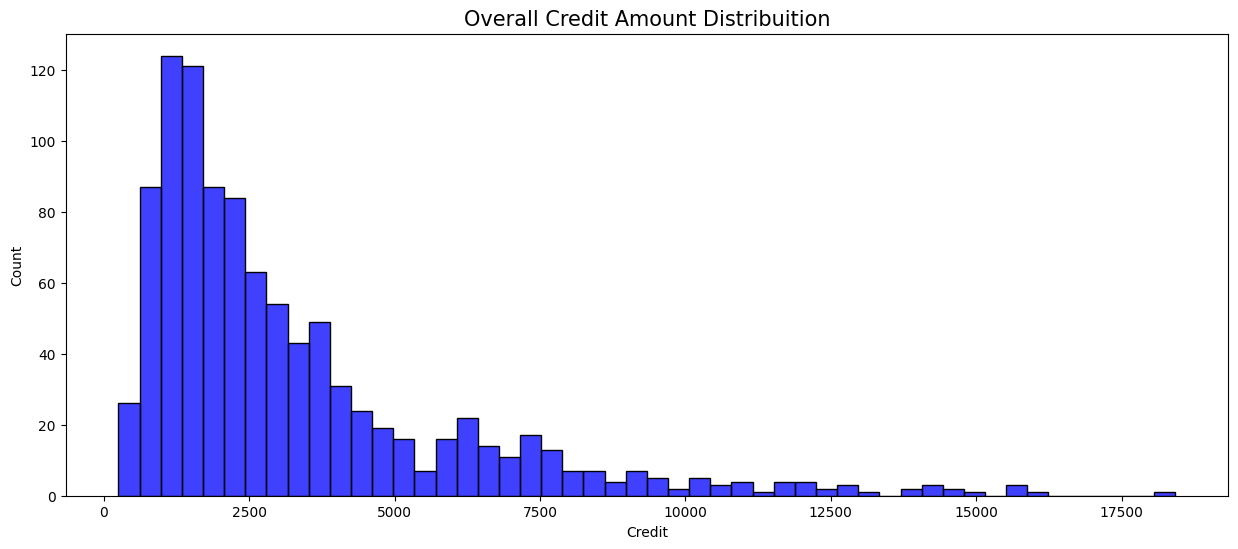

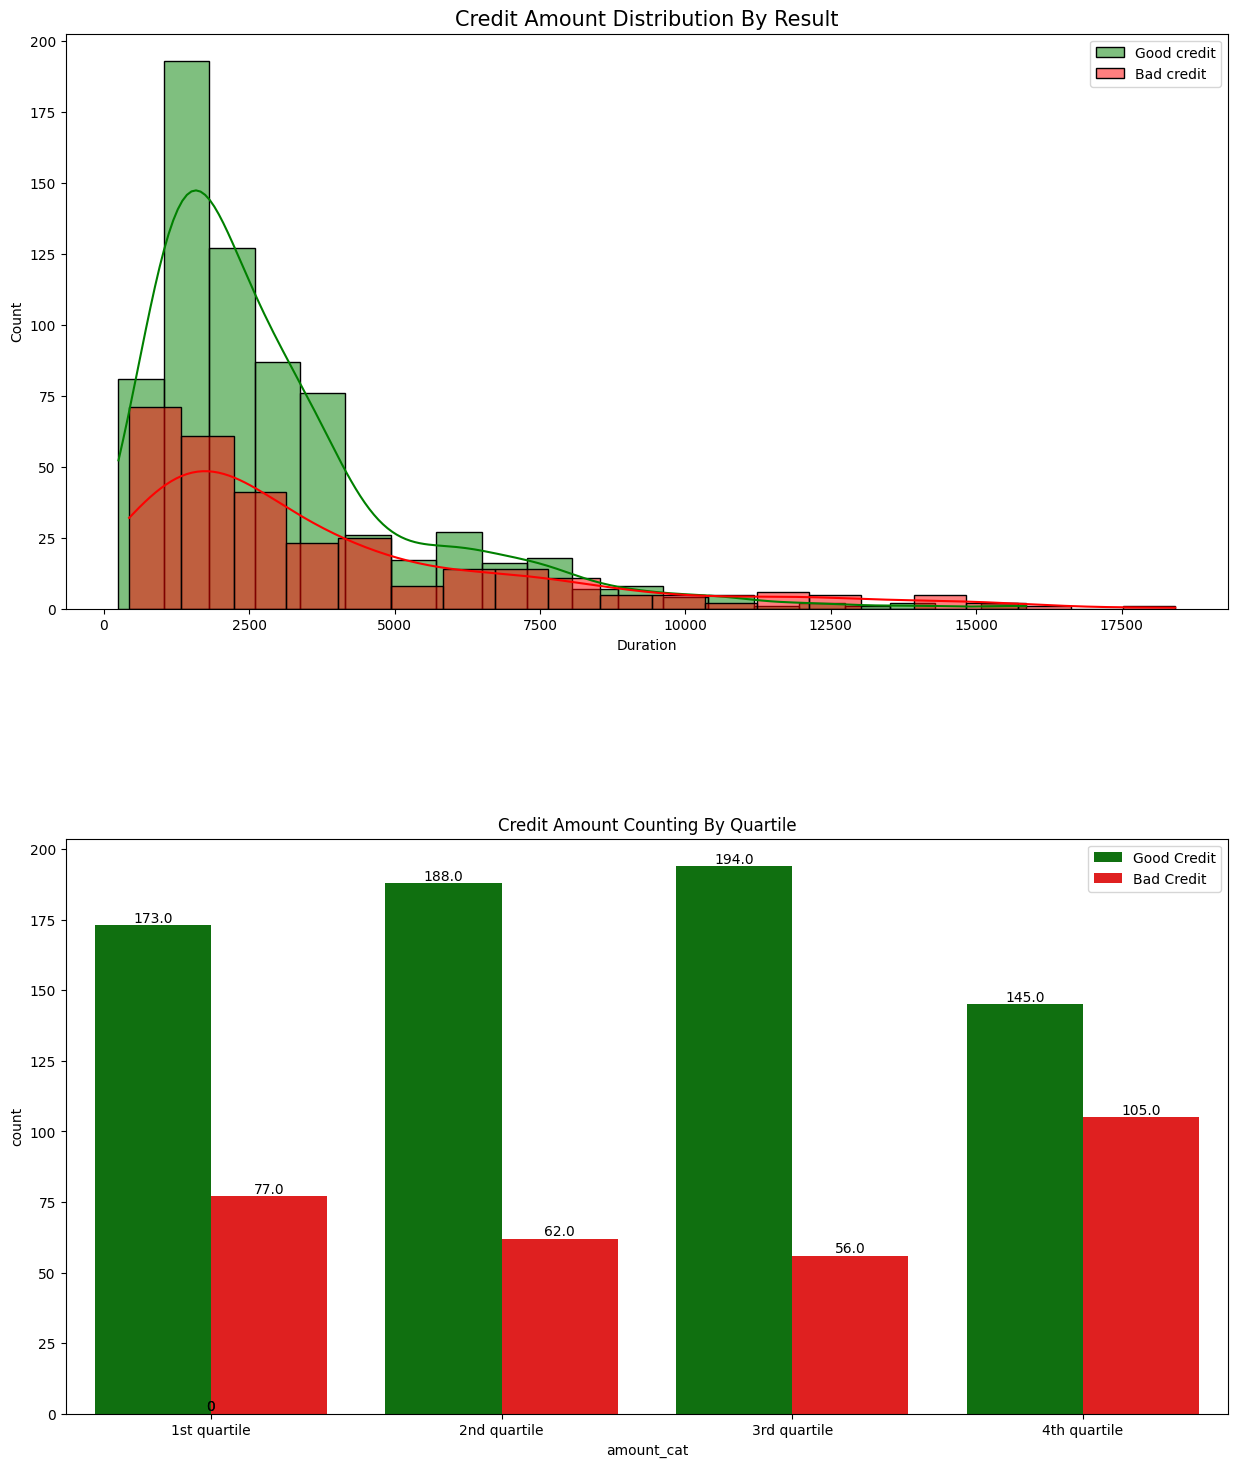

% Ratio 1st quartile Category: 69%
% Ratio 2nd quartile Category: 75%
% Ratio 3rd quartile Category: 78%
% Ratio 4th quartile Category: 58%


In [15]:

interval = (0,1365.5,2319.5, 3972.25, 20000)
cats = ['1st quartile', '2nd quartile', '3rd quartile', '4th quartile']
df["amount_cat"] = pd.cut(df.credit_amount, interval, labels=cats)

plt.figure(figsize=(15,6))
g0 = sns.histplot(
        df["credit_amount"], 
        color="Blue",
        bins = 50,
)
g0.set_title("Overall Credit Amount Distribuition", fontsize=15)
g0.set_xlabel("Credit")
g0.set_ylabel("Count")
plt.show()

fig, axes = plt.subplots(nrows=2, figsize=(15,20))
plt.subplots_adjust(hspace = 0.4, top = 0.8)


g1 = sns.histplot(
        df_good["credit_amount"], 
        ax=axes[0], 
        color="green",
        bins=20,
        label = 'Good credit',
        kde=True
)
g1 = sns.histplot(
        df_bad["credit_amount"],
        ax=axes[0], 
        color='red',
        bins=20,
        label = 'Bad credit',
        kde=True
)
axes[0].legend()

g1.set_title("Credit Amount Distribution By Result", fontsize=15)
g1.set_xlabel("Duration")
g1.set_ylabel("Count")
custom_palette = ["green", "red"]
g2.set_title("Credit Amount Counting by Result", fontsize=15)
g2.set_xlabel("Amount")
g2.set_xlabel("Count")
g2.legend(labels=["Good Credit", "Bad Credit"])

g3 = sns.countplot(
    data = df,
    x = "amount_cat",
    ax=axes[1], 
    palette=custom_palette,
    hue = 'result'
)

list_height = []
for bar in g3.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    list_height.append(y)
    g3.annotate(f'{y}', (x, y), ha='center', va='bottom')

g3.legend(labels=["Good Credit", "Bad Credit"])
g3.set_title("Credit Amount Counting By Quartile")
plt.show()
res = []
for i in range(4):
    res = list_height[i]/(list_height[i]+list_height[i+4])*100
    print(f"% Ratio {cats[i]} Category: {round(res)}%")


### Installment Rate

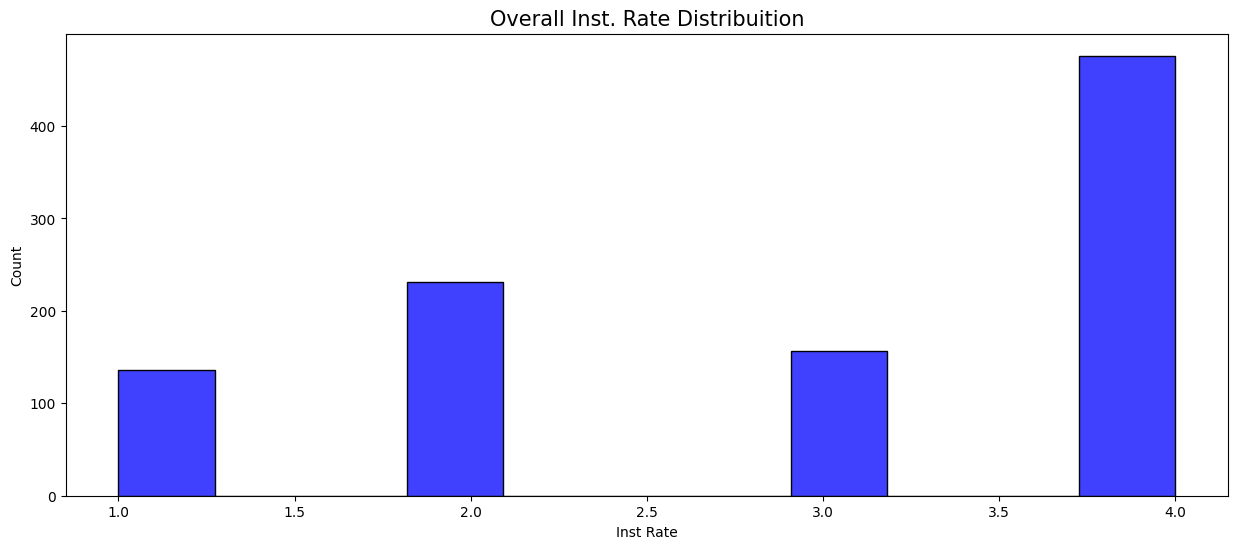

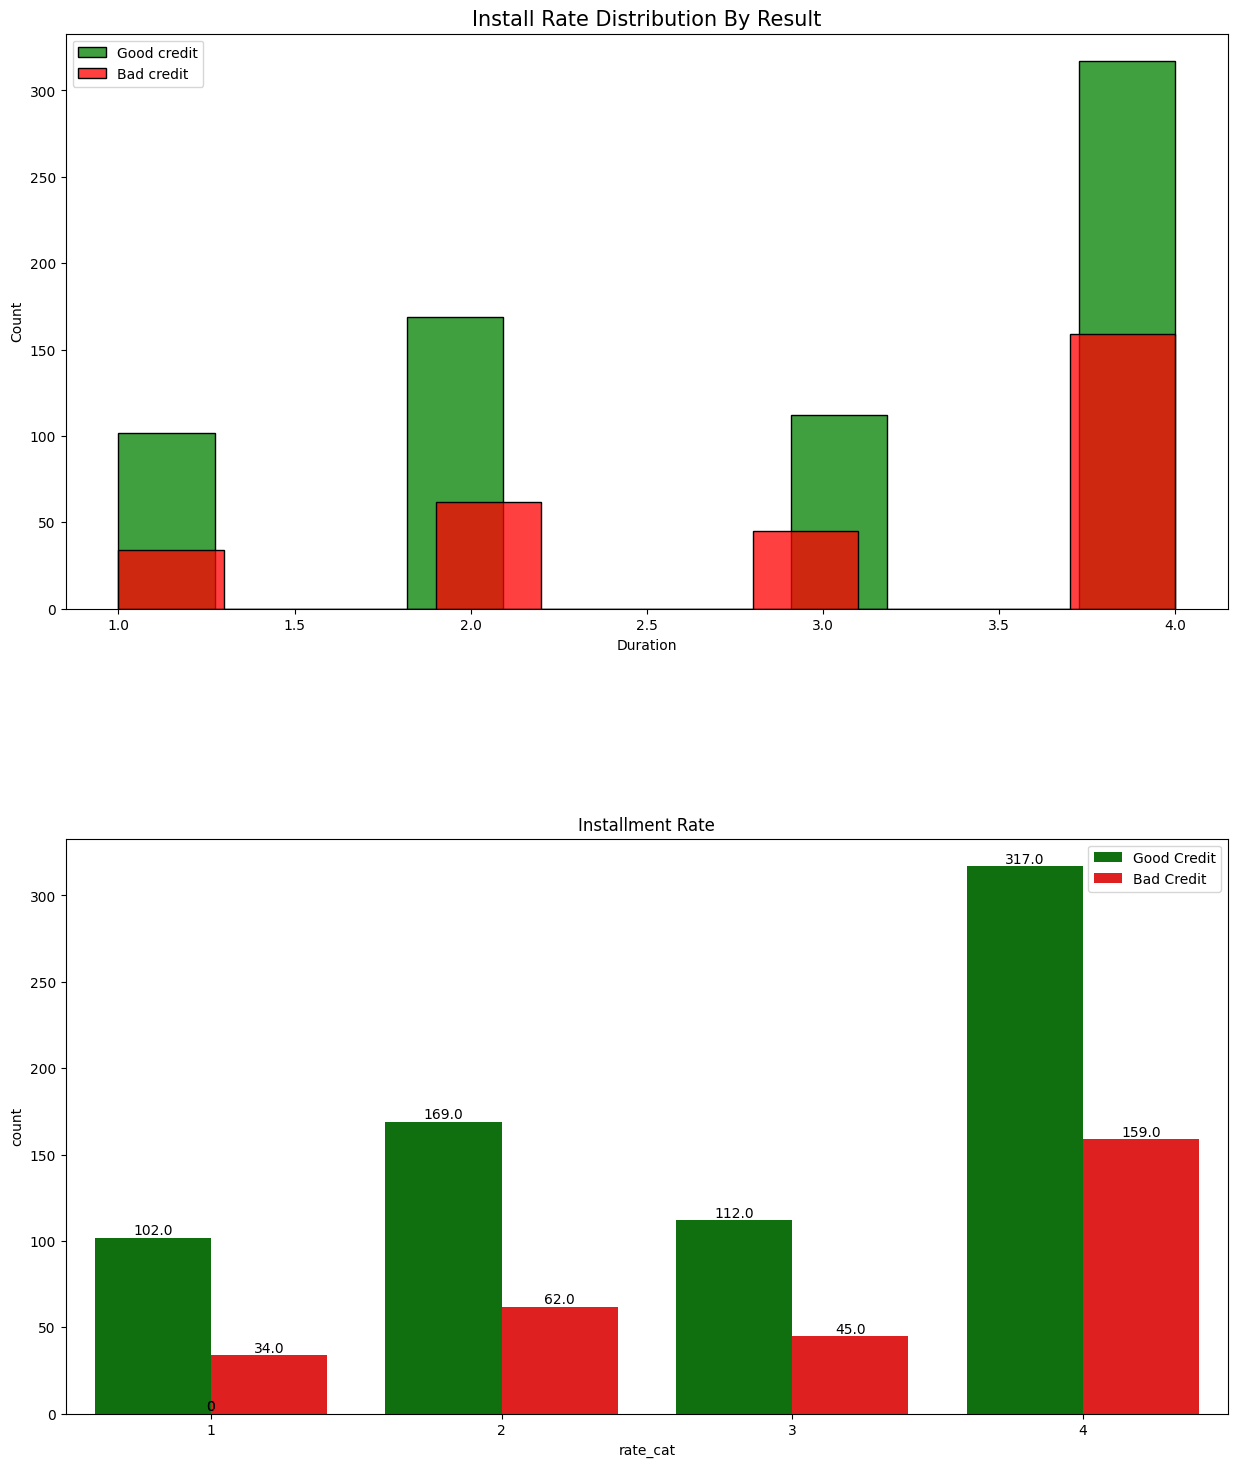

% Ratio 1 Category: 75%
% Ratio 2 Category: 73%
% Ratio 3 Category: 71%
% Ratio 4 Category: 67%


In [16]:
interval = (0,1,2, 3, 4)
cats = ['1', '2', '3', '4']
df["rate_cat"] = pd.cut(df.installment_rate, interval, labels=cats)

plt.figure(figsize=(15,6))
g0 = sns.histplot(
        df["installment_rate"], 
        color="Blue",
)
g0.set_title("Overall Inst. Rate Distribuition", fontsize=15)
g0.set_xlabel("Inst Rate")
g0.set_ylabel("Count")
plt.show()

fig, axes = plt.subplots(nrows=2, figsize=(15,20))
plt.subplots_adjust(hspace = 0.4, top = 0.8)


g1 = sns.histplot(
        df_good["installment_rate"], 
        ax=axes[0], 
        color="green",
        label = 'Good credit'
)
g1 = sns.histplot(
        df_bad["installment_rate"],
        ax=axes[0], 
        color='red',
        label = 'Bad credit'
)
axes[0].legend()

g1.set_title("Install Rate Distribution By Result", fontsize=15)
g1.set_xlabel("Duration")
g1.set_ylabel("Count")
custom_palette = ["green", "red"]
g2.set_title("Credit Amount Counting by Result", fontsize=15)
g2.set_xlabel("Amount")
g2.set_xlabel("Count")
g2.legend(labels=["Good Credit", "Bad Credit"])

g3 = sns.countplot(
    data = df,
    x = "rate_cat",
    ax=axes[1], 
    palette=custom_palette,
    hue = 'result'
)

list_height = []
for bar in g3.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    list_height.append(y)
    g3.annotate(f'{y}', (x, y), ha='center', va='bottom')

g3.legend(labels=["Good Credit", "Bad Credit"])
g3.set_title("Installment Rate")
plt.show()
res = []
for i in range(4):
    res = list_height[i]/(list_height[i]+list_height[i+4])*100
    print(f"% Ratio {cats[i]} Category: {round(res)}%")


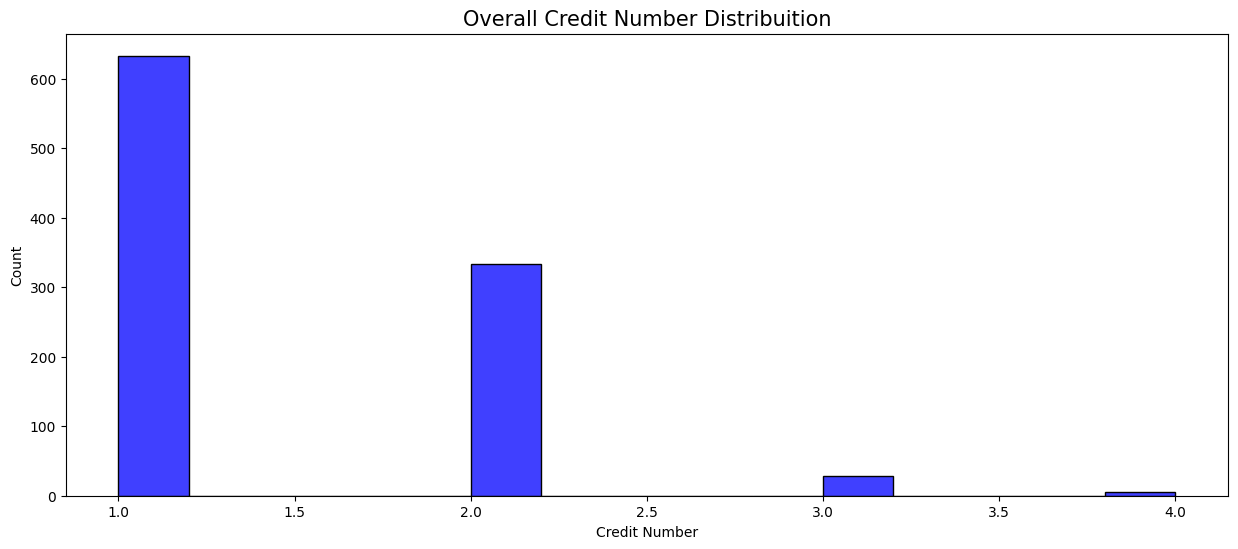

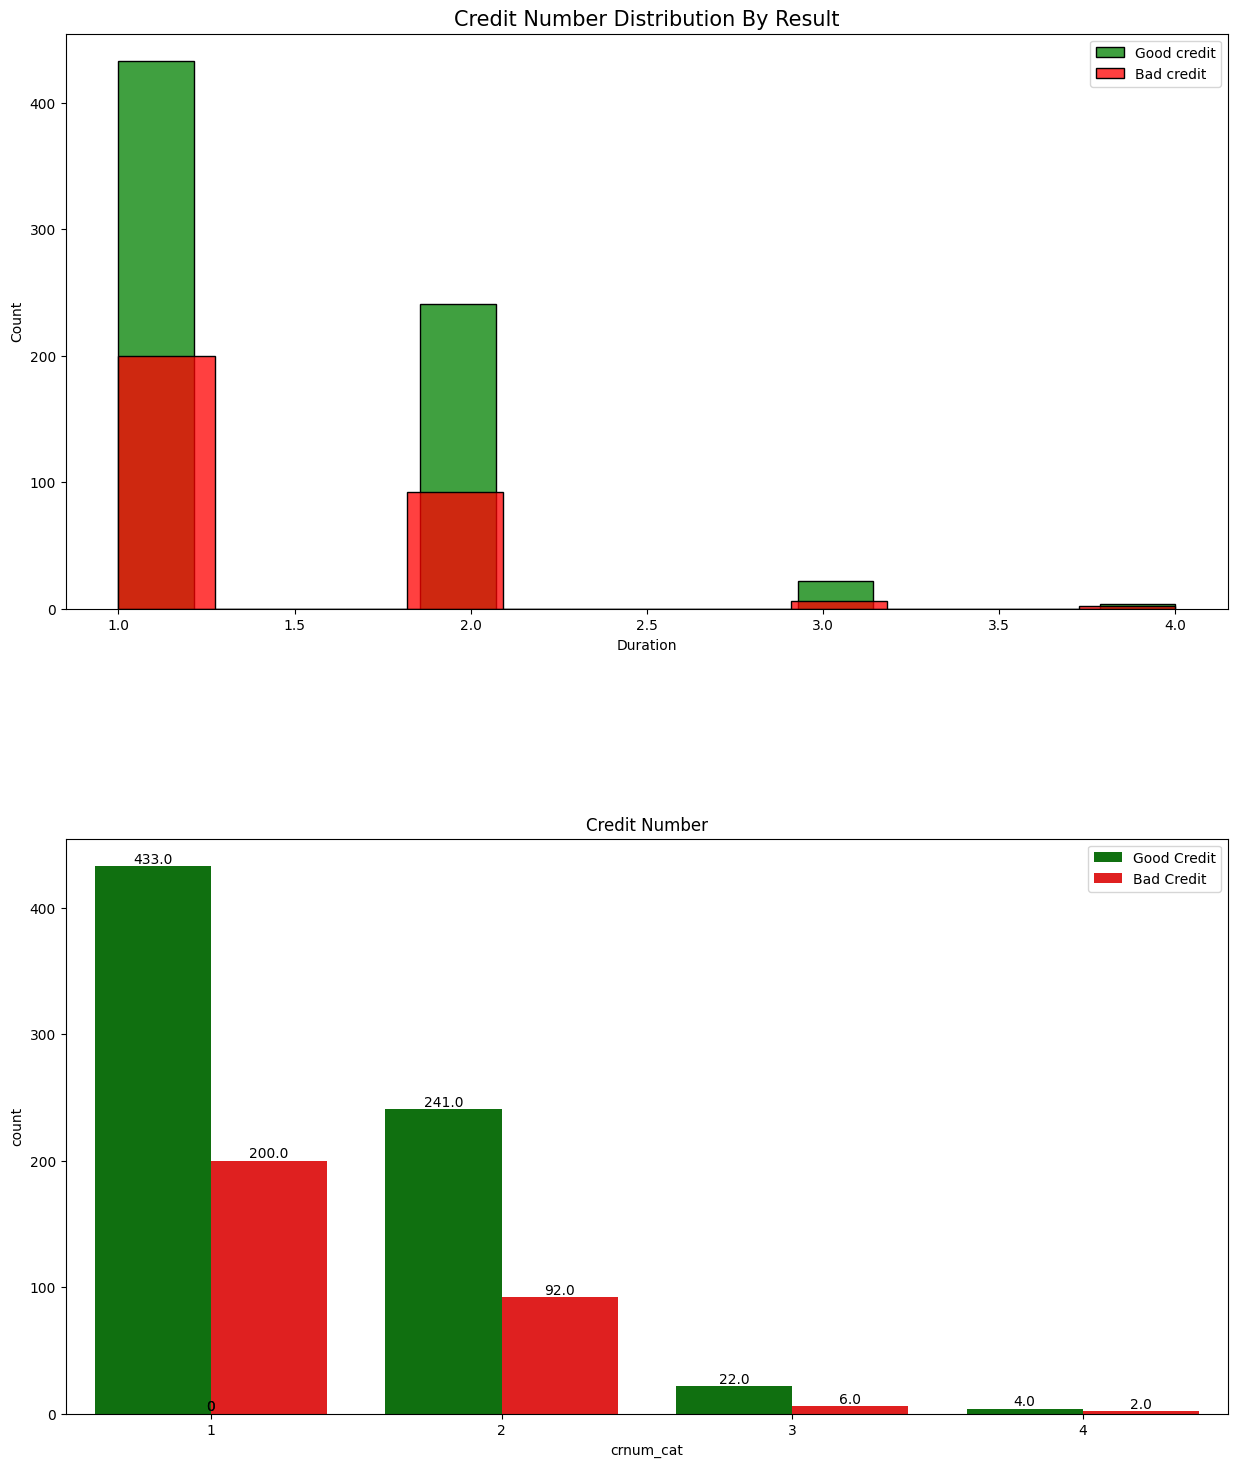

% Ratio 1 Category: 68%
% Ratio 2 Category: 72%
% Ratio 3 Category: 79%
% Ratio 4 Category: 67%


In [17]:
# Credit Number
interval = (0,1,2, 3, 4)
cats = ['1', '2', '3', '4']
df["crnum_cat"] = pd.cut(df.credit_number, interval, labels=cats)

plt.figure(figsize=(15,6))
g0 = sns.histplot(
        df["credit_number"], 
        color="Blue",
)
g0.set_title("Overall Credit Number Distribuition", fontsize=15)
g0.set_xlabel("Credit Number")
g0.set_ylabel("Count")
plt.show()

fig, axes = plt.subplots(nrows=2, figsize=(15,20))
plt.subplots_adjust(hspace = 0.4, top = 0.8)


g1 = sns.histplot(
        df_good["credit_number"], 
        ax=axes[0], 
        color="green",
        label = 'Good credit'
)
g1 = sns.histplot(
        df_bad["credit_number"],
        ax=axes[0], 
        color='red',
        label = 'Bad credit'
)
axes[0].legend()

g1.set_title("Credit Number Distribution By Result", fontsize=15)
g1.set_xlabel("Duration")
g1.set_ylabel("Count")
custom_palette = ["green", "red"]
g2.set_title("Credit Number Counting by Result", fontsize=15)
g2.set_xlabel("Amount")
g2.set_xlabel("Count")
g2.legend(labels=["Good Credit", "Bad Credit"])

g3 = sns.countplot(
    data = df,
    x = "crnum_cat",
    ax=axes[1], 
    palette=custom_palette,
    hue = 'result'
)

list_height = []
for bar in g3.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    list_height.append(y)
    g3.annotate(f'{y}', (x, y), ha='center', va='bottom')

g3.legend(labels=["Good Credit", "Bad Credit"])
g3.set_title("Credit Number")
plt.show()
res = []
for i in range(4):
    res = list_height[i]/(list_height[i]+list_height[i+4])*100
    print(f"% Ratio {cats[i]} Category: {round(res)}%")


### Count Savings
Here we delve also into considering if the variables Count Savings and Age are modulated between each other. Same goes for the Count Savings and Credit Amount variables.

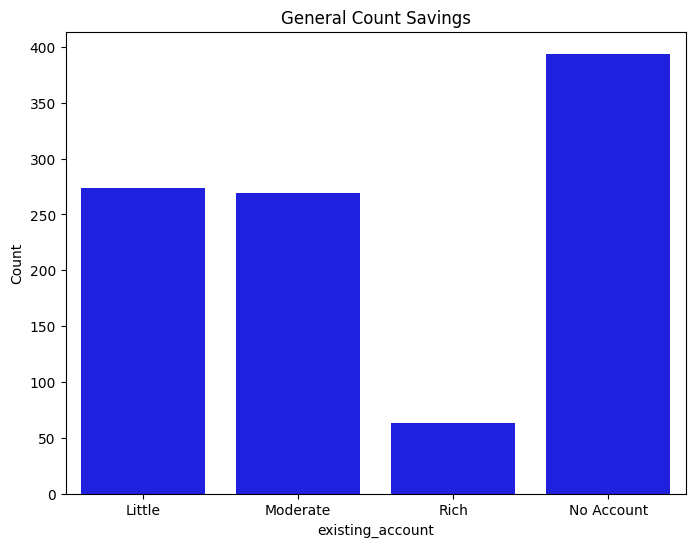

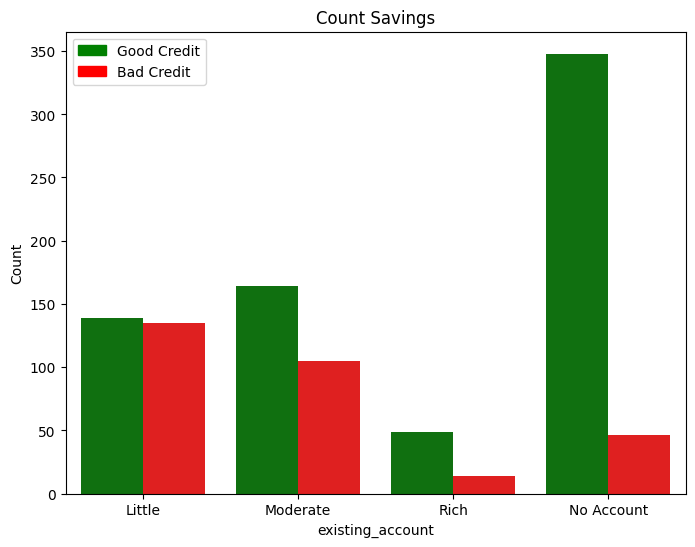

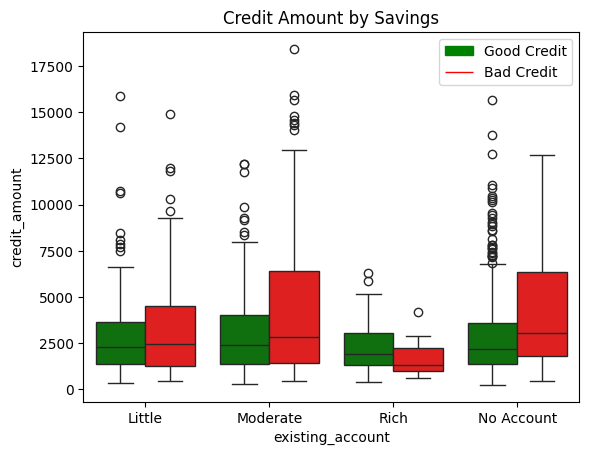

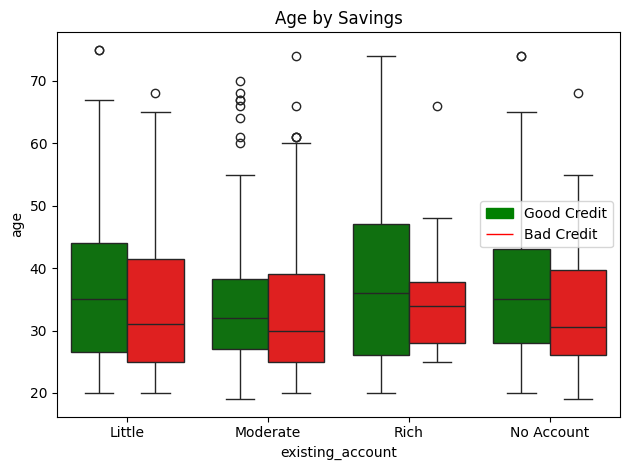

In [18]:
plt.figure(figsize=(8, 6))
ticks = ["Little","Moderate","Rich","No Account"]
sns.countplot(x="existing_account",data=df_encode,palette=["blue"])
plt.ylabel("Count")
plt.xticks([0,1,2,3],ticks)
plt.title('General Count Savings')
plt.show()
plt.figure(figsize=(8, 6))
ticks = ["Little","Moderate","Rich","No Account"]
sns.countplot(x="existing_account",data=df_encode, hue="result",palette=custom_palette)
plt.ylabel("Count")
plt.xticks([0,1,2,3],ticks)
plt.title('Count Savings')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()

sns.boxplot(x="existing_account", y="credit_amount", data=df_encode, hue="result", palette=custom_palette)
plt.xticks([0,1,2,3],ticks)
plt.title('Credit Amount by Savings')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()


sns.boxplot(x="existing_account", y="age", data=df_encode, hue="result",palette=custom_palette)
plt.xticks([0,1,2,3],ticks)
plt.title('Age by Savings')

plt.tight_layout()
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")

plt.show()

### Saving Bonds
Here we also delve also into considering if the variables Saving Bonds and Age are modulated between each other. Same goes for the Saving Bonds and Credit Amount variables.

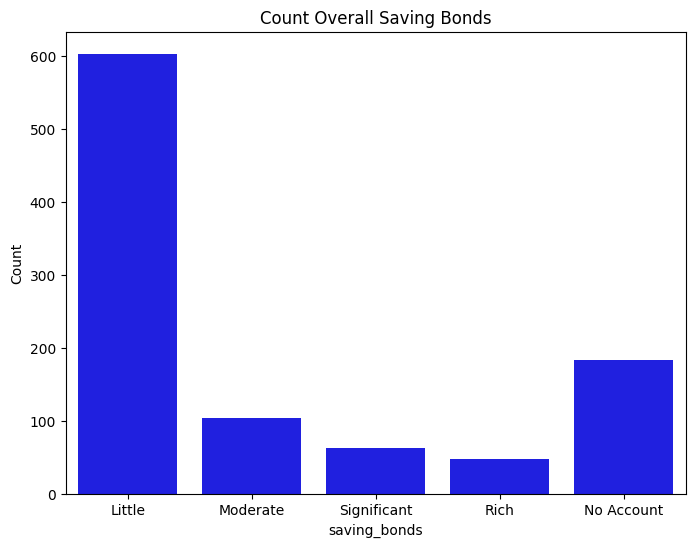

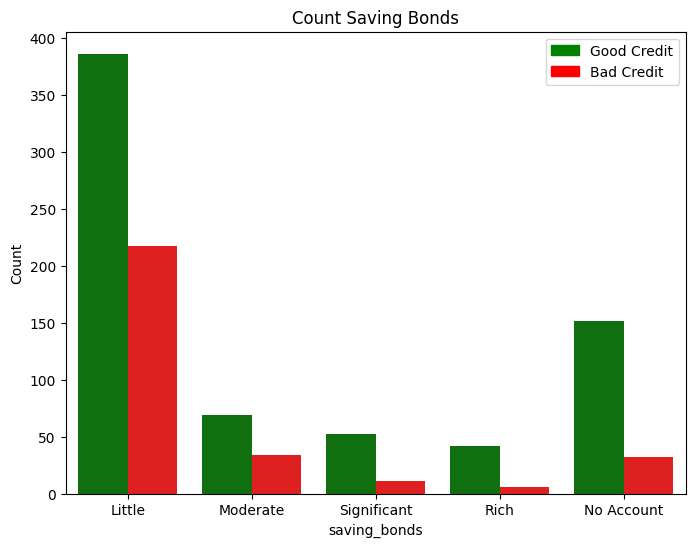

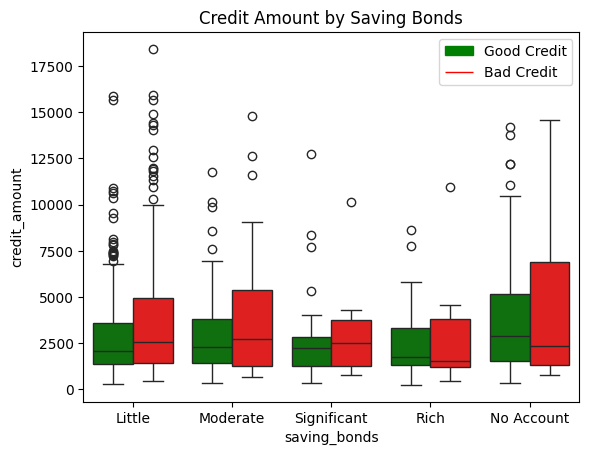

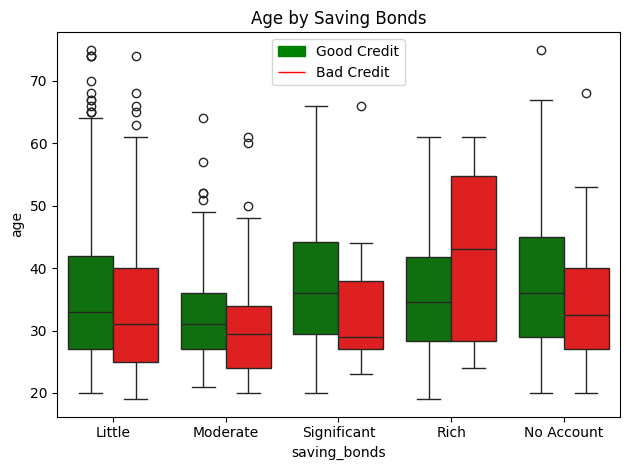

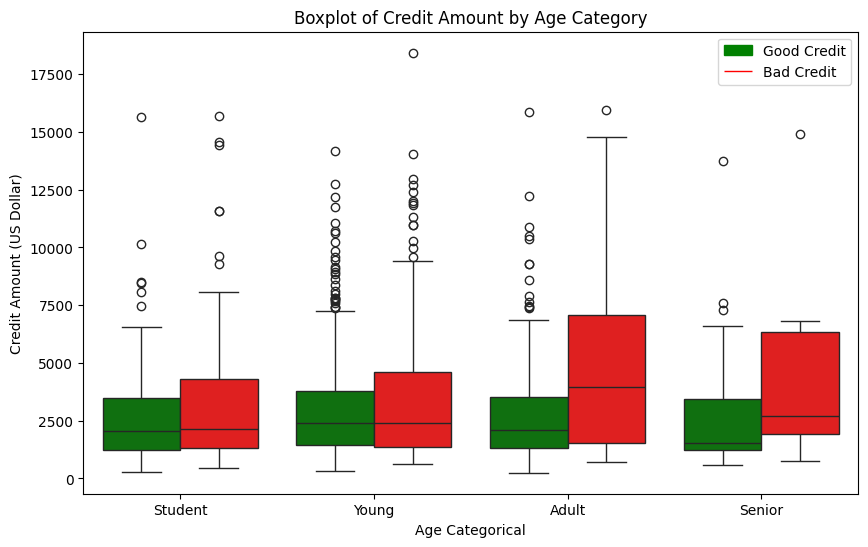

In [19]:
plt.figure(figsize=(8, 6))
ticks = ["Little","Moderate","Significant","Rich","No Account"]
sns.countplot(x="saving_bonds",data=df_encode,palette=["blue"])
plt.ylabel("Count")
plt.xticks([0,1,2,3,4],ticks)
plt.title('Count Overall Saving Bonds')
plt.show()

plt.figure(figsize=(8, 6))
ticks = ["Little","Moderate","Significant","Rich","No Account"]
sns.countplot(x="saving_bonds",data=df_encode, hue="result",palette=custom_palette)
plt.ylabel("Count")
plt.xticks([0,1,2,3,4],ticks)
plt.title('Count Saving Bonds')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()

# Create the boxplot for Credit Amount by Savings Account
sns.boxplot(x="saving_bonds", y="credit_amount", data=df_encode, hue="result", palette=custom_palette)
plt.xticks([0,1,2,3,4],ticks)
plt.title('Credit Amount by Saving Bonds')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()
# Create the boxplot for Age by Savings Account

sns.boxplot(x="saving_bonds", y="age", data=df_encode, hue="result",palette=custom_palette)
plt.xticks([0,1,2,3,4],ticks)
plt.title('Age by Saving Bonds')

# Adjust the layout
plt.tight_layout()
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
# Show the plots
plt.show()
plt.figure(figsize=(10, 6)) 
sns.boxplot(x="age_cat", y="credit_amount", hue="result", data=df, palette=custom_palette)
plt.xlabel('Age Categorical')
plt.ylabel('Credit Amount (US Dollar)')
plt.title('Boxplot of Credit Amount by Age Category')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()

We can note how good credits seem to have similar credit amount distribution across all age classes, while bad credits have a different distribution in the Adult and Senior classes related to Student and Young classes. This means that the bank is generally more willing to offer higher credit amounts to older people.

### Job
Here we also delve also into considering if the variables Job and Age are modulated between each other. Same goes for the Job and Credit Amount variables.

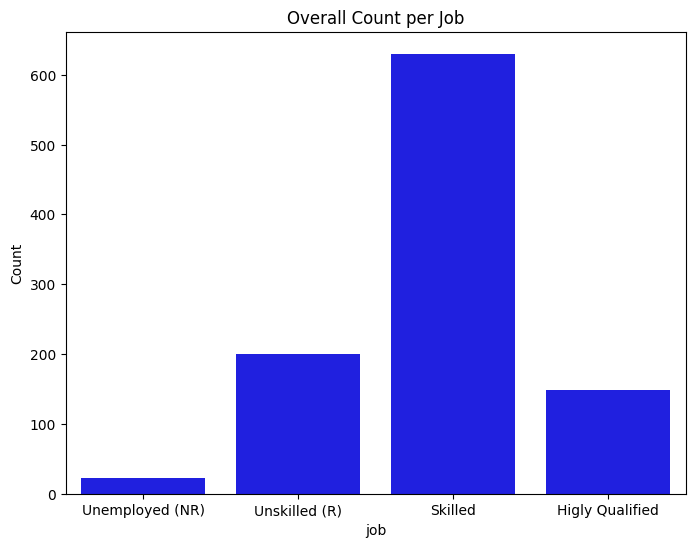

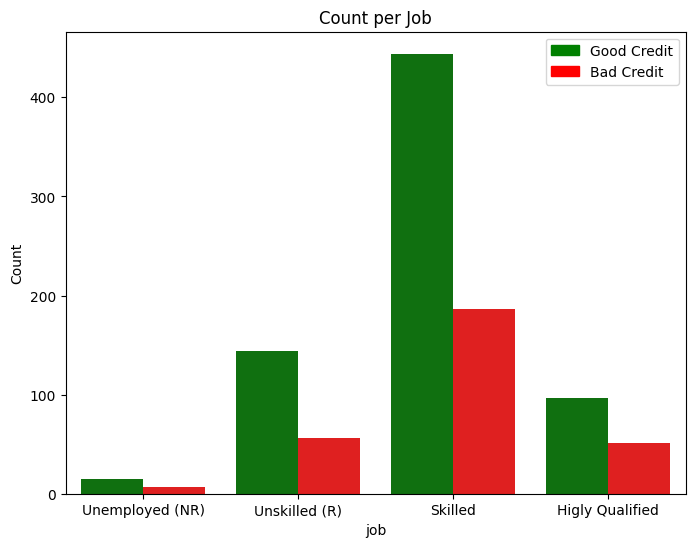

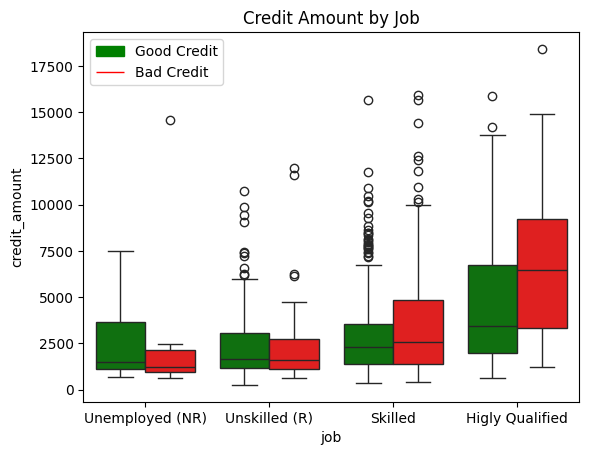

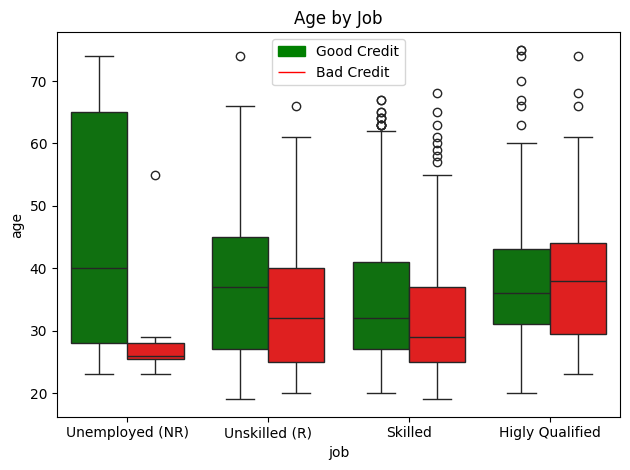

In [20]:

plt.figure(figsize=(8, 6))
ticks = ["Unemployed (NR)","Unskilled (R)","Skilled","Higly Qualified"]
sns.countplot(x="job",data=df_encode,palette=["blue"])
plt.ylabel("Count")
plt.xticks([0,1,2,3],ticks)
plt.title('Overall Count per Job')
plt.show()
plt.figure(figsize=(8, 6))
ticks = ["Unemployed (NR)","Unskilled (R)","Skilled","Higly Qualified"]
sns.countplot(x="job",data=df_encode, hue="result",palette=custom_palette)
plt.ylabel("Count")
plt.xticks([0,1,2,3],ticks)
plt.title('Count per Job')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()
sns.boxplot(x="job", y="credit_amount", data=df_encode, hue="result", palette=custom_palette)
plt.xticks([0,1,2,3],ticks)
plt.title('Credit Amount by Job')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()

sns.boxplot(x="job", y="age", data=df_encode, hue="result",palette=custom_palette)
plt.xticks([0,1,2,3],ticks)
plt.title('Age by Job')
plt.tight_layout()
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")

plt.show()

### Employment Status
Here we delve also into considering if the variables Employment Status and Age are modulated between each other. Same goes for the Employment Status and Credit Amount variables.

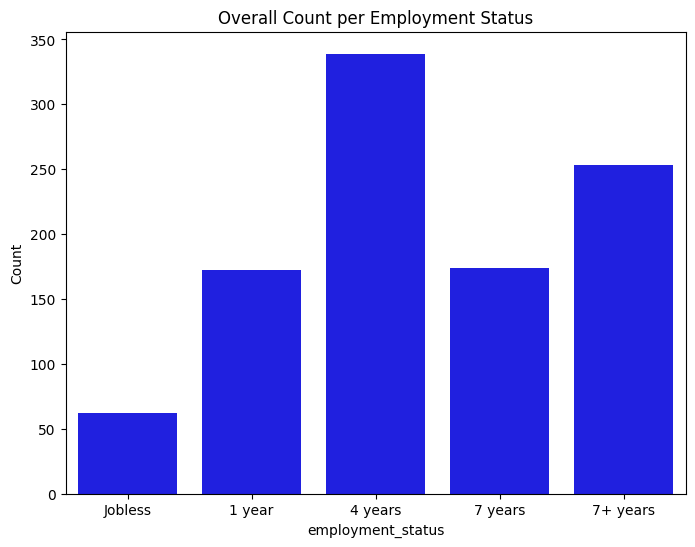

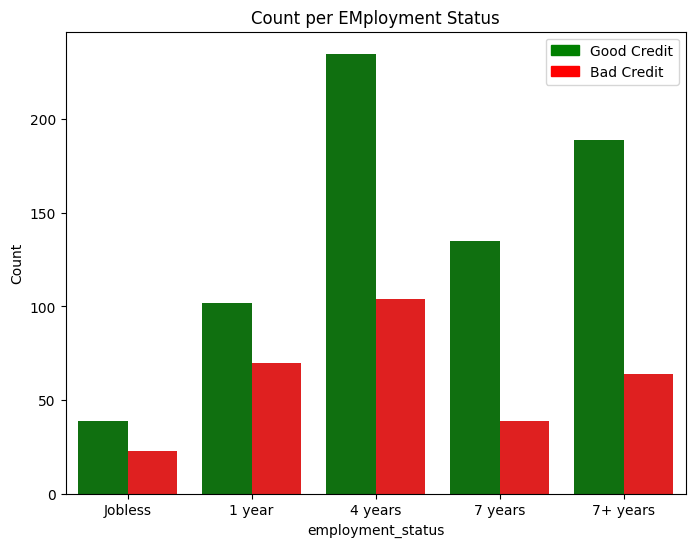

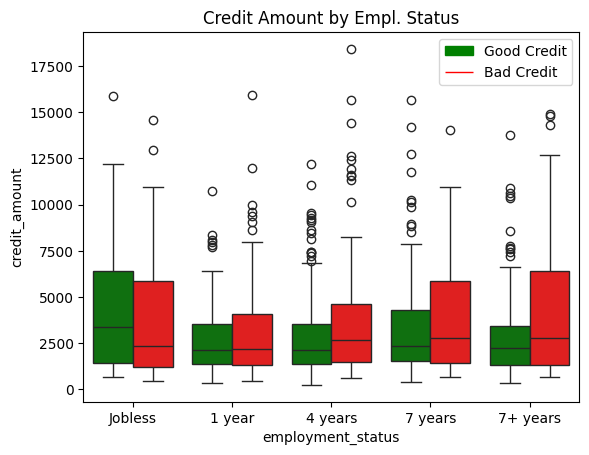

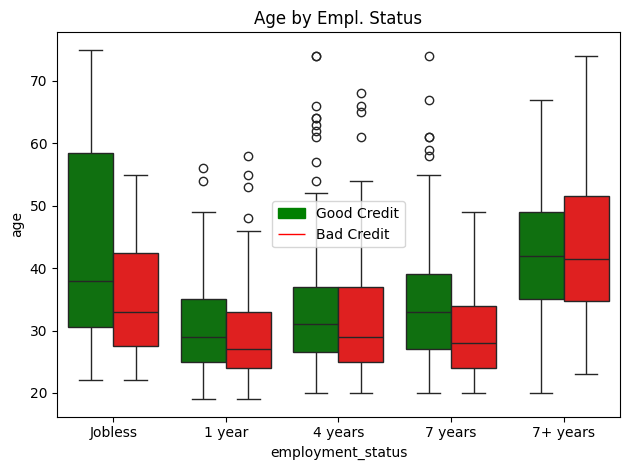

In [21]:
# Employment Status
plt.figure(figsize=(8, 6))
ticks = ["Jobless","1 year","4 years","7 years", "7+ years"]
sns.countplot(x="employment_status",data=df_encode,palette=["blue"])
plt.ylabel("Count")
plt.xticks([0,1,2,3,4],ticks)
plt.title('Overall Count per Employment Status')
plt.show()
plt.figure(figsize=(8, 6))
ticks = ["Jobless","1 year","4 years","7 years", "7+ years"]
sns.countplot(x="employment_status",data=df_encode,hue="result",palette=custom_palette)
plt.ylabel("Count")
plt.xticks([0,1,2,3,4],ticks)
plt.title('Count per EMployment Status')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()
sns.boxplot(x="employment_status", y="credit_amount", data=df_encode, hue="result", palette=custom_palette)
plt.xticks([0,1,2,3,4],ticks)
plt.title('Credit Amount by Empl. Status')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()

sns.boxplot(x="employment_status", y="age", data=df_encode, hue="result",palette=custom_palette)
plt.xticks([0,1,2,3,4],ticks)
plt.title('Age by Empl. Status')

plt.tight_layout()
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()

### Credit History
Here we delve also into considering if the variables Credit History and Age are modulated between each other. Same goes for the Credit History and Credit Amount variables.

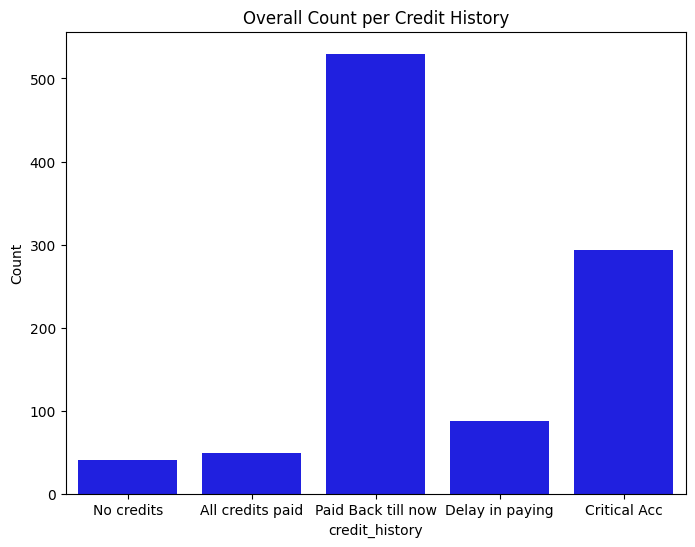

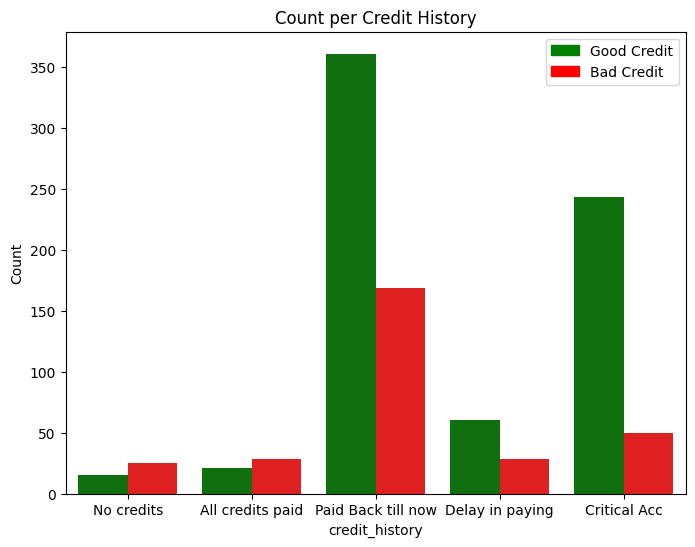

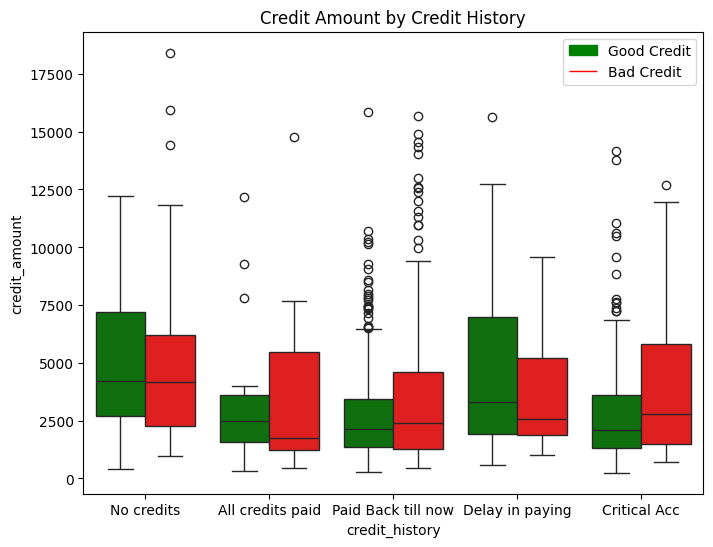

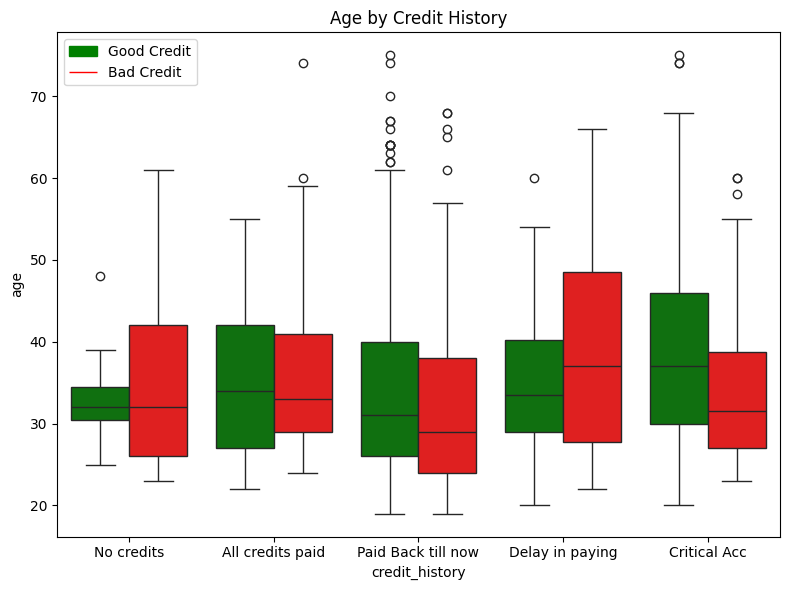

In [22]:

plt.figure(figsize=(8, 6))
ticks = ["No credits","All credits paid","Paid Back till now","Delay in paying", "Critical Acc"]
sns.countplot(x="credit_history",data=df_encode,palette=["blue"])
plt.ylabel("Count")
plt.xticks([0,1,2,3,4],ticks)
plt.title('Overall Count per Credit History')
plt.show()
plt.figure(figsize=(8, 6))
sns.countplot(x="credit_history",data=df_encode,hue="result",palette=custom_palette)
plt.ylabel("Count")
plt.xticks([0,1,2,3,4],ticks)
plt.title('Count per Credit History')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x="credit_history", y="credit_amount", data=df_encode, hue="result", palette=custom_palette)
plt.xticks([0,1,2,3,4],ticks)
plt.title('Credit Amount by Credit History')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x="credit_history", y="age", data=df_encode, hue="result",palette=custom_palette)
plt.xticks([0,1,2,3,4],ticks)
plt.title('Age by Credit History')

plt.tight_layout()
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")

plt.show()

### Purpose


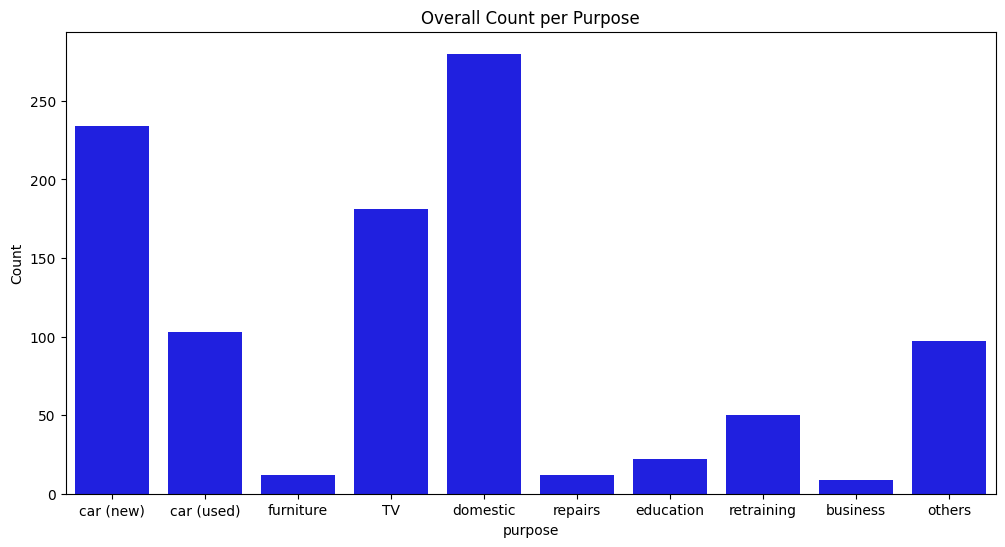

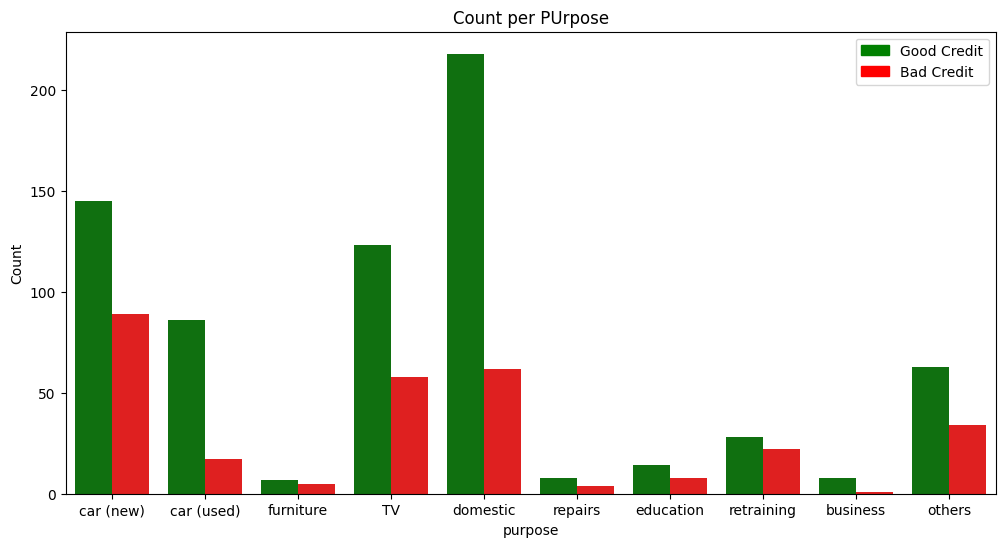

In [23]:

plt.figure(figsize=(12, 6))
ticks = ["car (new)","car (used)","furniture","TV", "domestic", "repairs","education","retraining","business","others"]
sns.countplot(x="purpose",data=df_encode,palette=["blue"])
plt.ylabel("Count")
plt.xticks([0,1,2,3,4,5,6,7,8,9],ticks)
plt.title('Overall Count per Purpose')
plt.show()
plt.figure(figsize=(12, 6))
sns.countplot(x="purpose",data=df_encode,hue="result",palette=custom_palette)
plt.ylabel("Count")
plt.xticks([0,1,2,3,4,5,6,7,8,9],ticks)
plt.title('Count per PUrpose')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()


### Housing
Here we also delve also into considering if the variables Housing and Age are modulated between each other. Same goes for the Housing and Credit Amount variables.

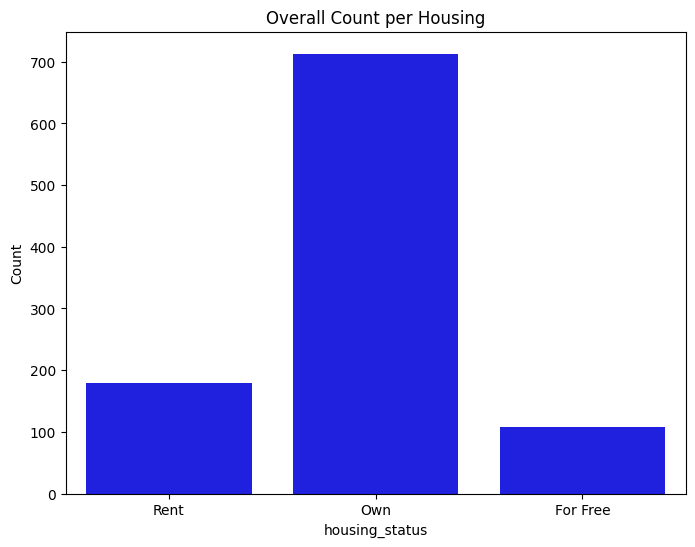

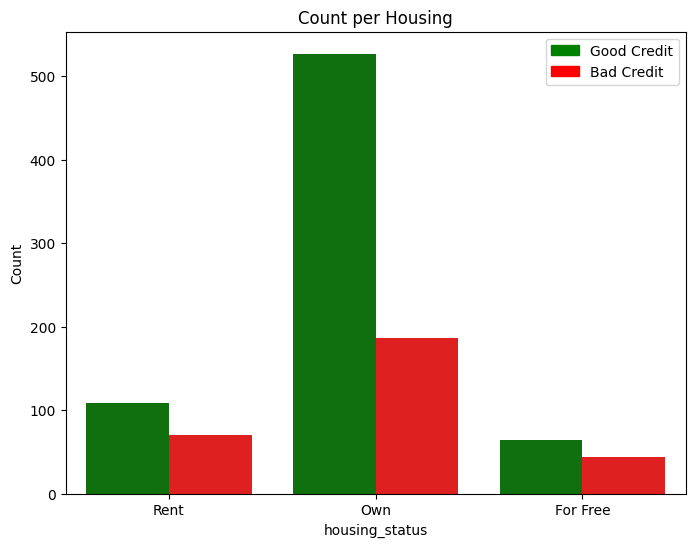

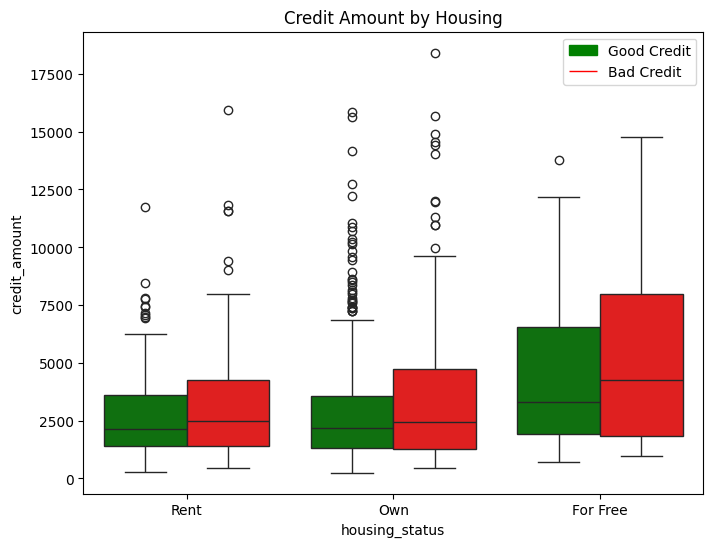

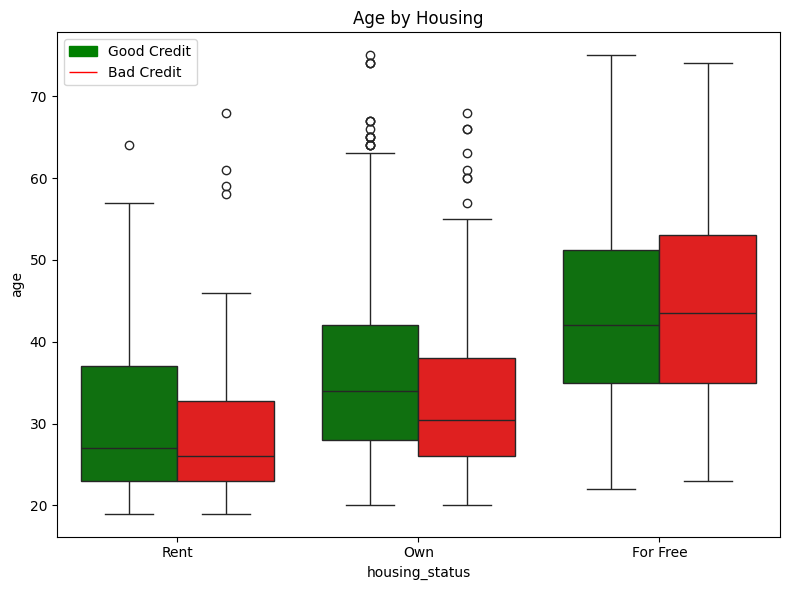

In [24]:
plt.figure(figsize=(8, 6))
ticks = ["Rent","Own","For Free"]
sns.countplot(x="housing_status",data=df_encode,palette=["blue"])
plt.ylabel("Count")
plt.xticks([0,1,2],ticks)
plt.title('Overall Count per Housing')
plt.show()
plt.figure(figsize=(8, 6))
sns.countplot(x="housing_status",data=df_encode,hue="result",palette=custom_palette)
plt.ylabel("Count")
plt.xticks([0,1,2],ticks)
plt.title('Count per Housing')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x="housing_status", y="credit_amount", data=df_encode, hue="result", palette=custom_palette)
plt.xticks([0,1,2],ticks)
plt.title('Credit Amount by Housing')
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x="housing_status", y="age", data=df_encode, hue="result",palette=custom_palette)
plt.xticks([0,1,2],ticks)
plt.title('Age by Housing')
plt.tight_layout()
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])
custom_legend.legendHandles[0].set_color("green")
custom_legend.legendHandles[1].set_color("red")
plt.show()

# 2 Unsupervised Exploration and Clustering

## 2.1 Dimensionality reduction for data visualizations
### PCA

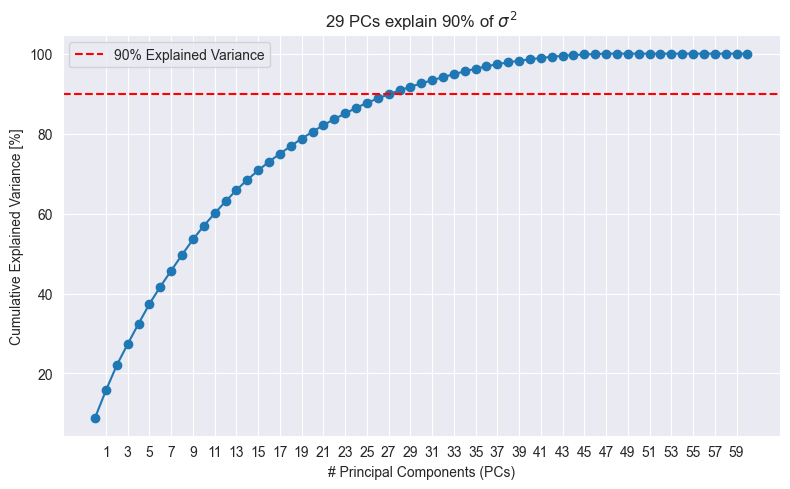

In [8]:
df_normalized = pd.DataFrame(normalization(df_one_hot_encoded), columns=df_one_hot_encoded.columns)

labels = df_normalized['result']
df_feature = df_normalized.drop('result', axis=1)

pca = PCA(random_state=15)
pca.fit(df_feature)
explained_variance = pca.explained_variance_ratio_
cumul_exp_var = np.cumsum(explained_variance)
perc_cumul_exp_var = cumul_exp_var * 100

# Using 90 as a threshold
n_components = np.argmax(perc_cumul_exp_var >= 90) + 1

# Plot
plt.figure(figsize=(8, 5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.axhline(y=90, color='r', linestyle='--', label='90% Explained Variance')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative Explained Variance [%]')
plt.xticks(np.arange(1, 61, 2), np.arange(1, 61, 2))
plt.grid(True)
plt.title(f'{n_components} PCs explain 90% of $\sigma^2$')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
#initialize the PCA with the best number of components
pca = PCA(n_components=n_components, random_state=15)
pca.fit(df_feature)
pca_result = pca.transform(df_feature)

In [10]:
# PCA reduced dataset
df_pca = pd.DataFrame(pca_result)
df_pca['labels'] = labels
num_components = df_pca.shape[1] - 1
new_column_names = [f'Component {i}' for i in range(1, num_components + 1)]
column_name_mapping = dict(zip(df_pca.columns[:-1], new_column_names))
df_pca.rename(columns=column_name_mapping, inplace=True)
df_pca

Component 1  Component 2  Component 3  Component 4  Component 5  \
0       1.093896    -0.671381     0.071018     0.303321     0.084117   
1      -1.416504     0.091914    -0.554414    -0.452032    -0.045155   
2      -0.057365    -1.337976     0.891651    -0.151722     0.760247   
3      -0.338916     0.466397     1.126655     0.462158    -1.028937   
4       0.126734     0.099974     1.483677     0.675505    -0.634900   
..           ...          ...          ...          ...          ...   
995    -1.110719    -0.061561    -0.003418    -0.086625     0.626471   
996     0.324920     1.041201     0.087038    -0.856791     0.197064   
997    -0.014915    -0.808939    -0.476231     0.140822    -0.916645   
998     0.572306     0.895386     0.367433     0.039532    -0.977372   
999     0.340852    -0.624195    -0.134619     0.239113    -0.214859   

     Component 6  Component 7  Component 8  Component 9  Component 10  ...  \
0      -0.110835    -0.417680    -0.405366    -0.494932      1.206842  ...   
1       0.024576    -0.116426    -0.824055     0.472684      0.642349  ...   
2       0.422291    -0.351408    -0.055940    -0.264468     -0.330179  ...   
3      -0.841161    -0.381964     0.710017    -0.219596      0.283003  ...   
4      -0.680912    -0.411220    -0.133550     1.048460     -0.340212  ...   
..           ...          ...          ...          ...           ...  ...   
995     0.668442    -0.488643     0.089491    -0.819157     -0.394127  ...   
996    -0.279203    -0.891672     0.673757    -0.135777     -0.094907  ...   
997    -0.492959     0.034228    -0.701505    -1.033105     -0.417113  ...   
998    -0.702488    -1.093899    -0.798150     0.352823      0.164897  ...   
999    -0.231715     1.296256    -0.038553     0.605812      0.071682  ...   

     Component 21  Component 22  Component 23  Component 24  Component 25  \
0       -0.242498      0.061220     -0.220745     -0.021681     -0.276734   
1       -0.273693     -0.098579     -0.408037      0.215007     -0.064848   
2       -0.028969      0.226894      0.036725      0.302881      0.289248   
3        0.238939     -0.287016      0.472356     -0.367845      0.478040   
4       -0.224916     -0.179831     -0.100561     -0.531021      0.305739   
..            ...           ...           ...           ...           ...   
995     -0.114692      0.261593      0.026199     -0.180043     -0.097420   
996     -0.018333      0.198868      0.369519      0.755969     -0.045538   
997     -0.146534     -0.019073     -0.011640     -0.030919     -0.212921   
998      0.144118      0.244284     -0.012929     -0.079232     -0.327607   
999      0.404111     -0.359298      0.355963      0.941276     -0.555089   

     Component 26  Component 27  Component 28  Component 29  labels  
0        0.003121      0.019374     -0.156364     -0.146720     0.0  
1        0.008687     -0.101822     -0.248133     -0.130574     1.0  
2        0.057404      0.238512     -0.022475     -0.062432     0.0  
3        0.387257      0.298697      0.158961      0.107054     0.0  
4        0.629600     -0.049308      0.063607     -0.066796     1.0  
..            ...           ...           ...           ...     ...  
995      0.281370     -0.034295      0.055193     -0.176054     0.0  
996      0.393689     -0.022509      0.389171     -0.087999     0.0  
997      0.134885      0.104338     -0.036378     -0.078579     0.0  
998      0.035713      0.046252     -0.154946     -0.105420     1.0  
999      0.497553     -0.030386     -0.007969     -0.193532     0.0  

[1000 rows x 30 columns]

### t-SNE

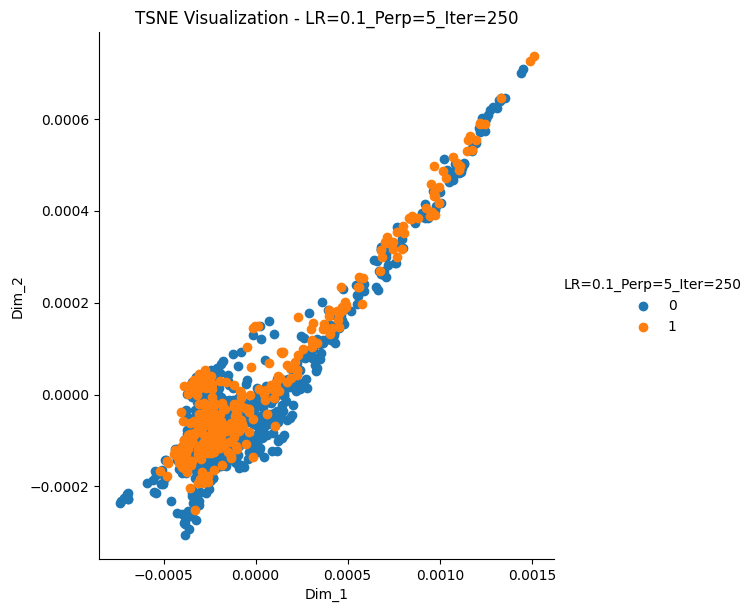

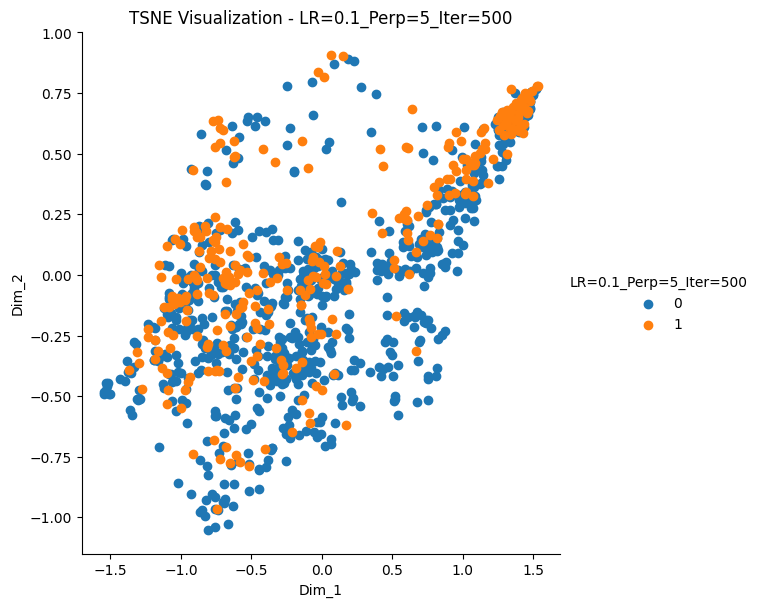

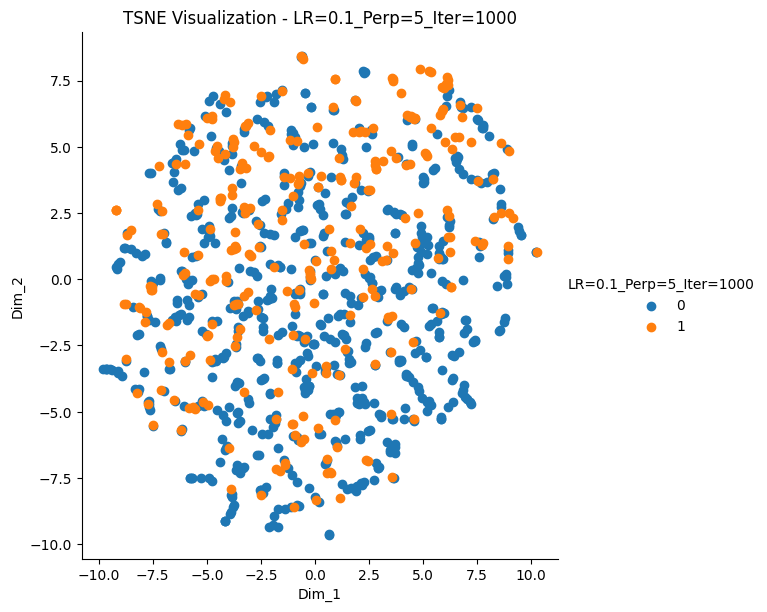

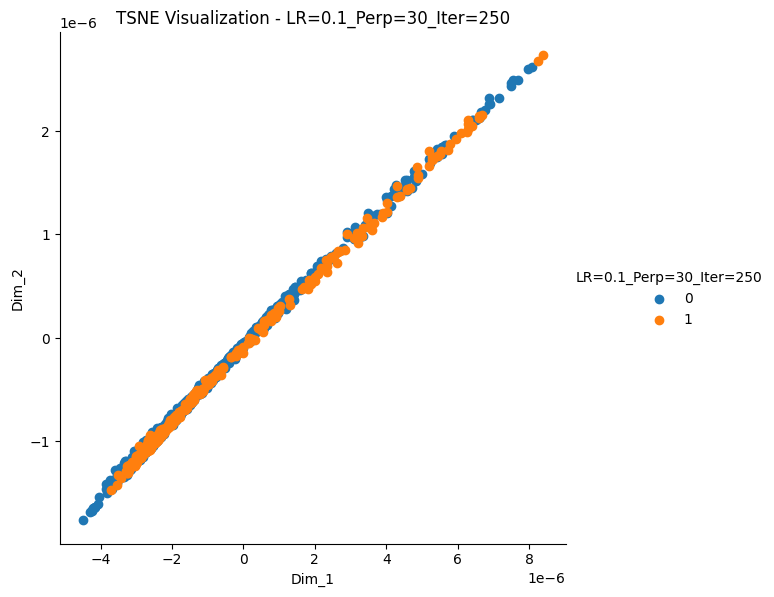

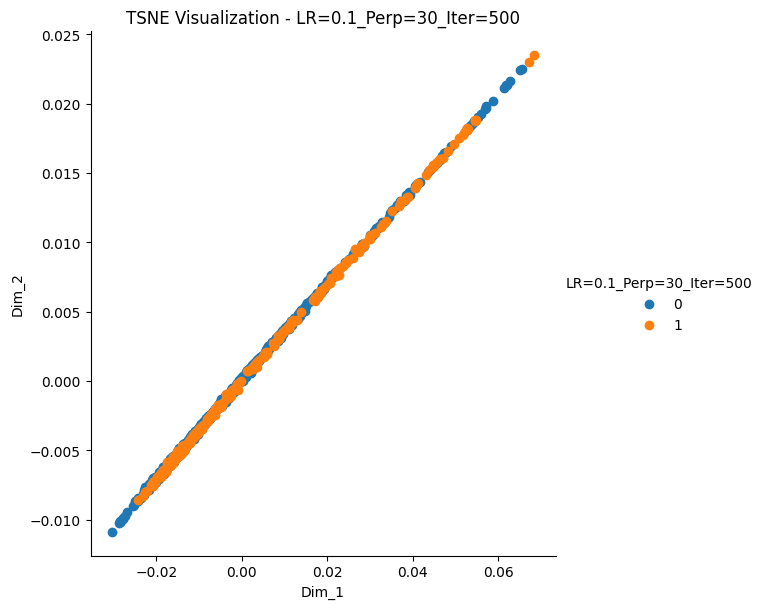

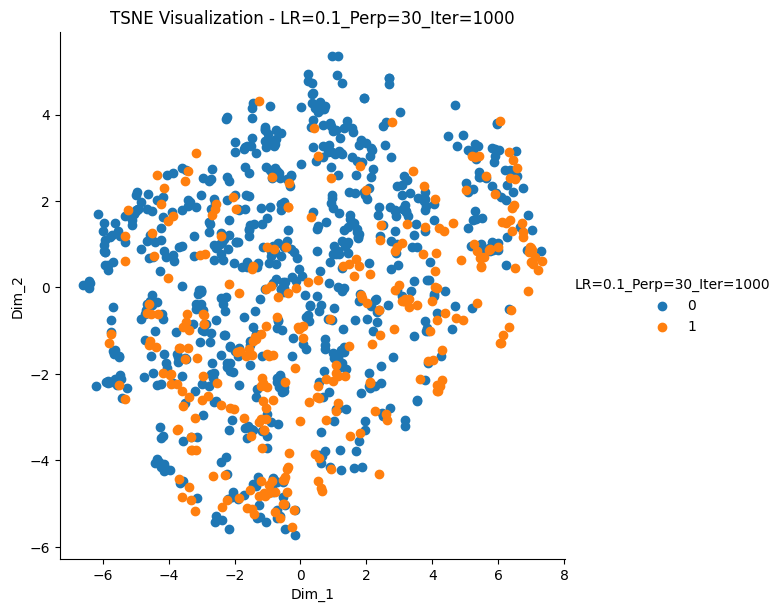

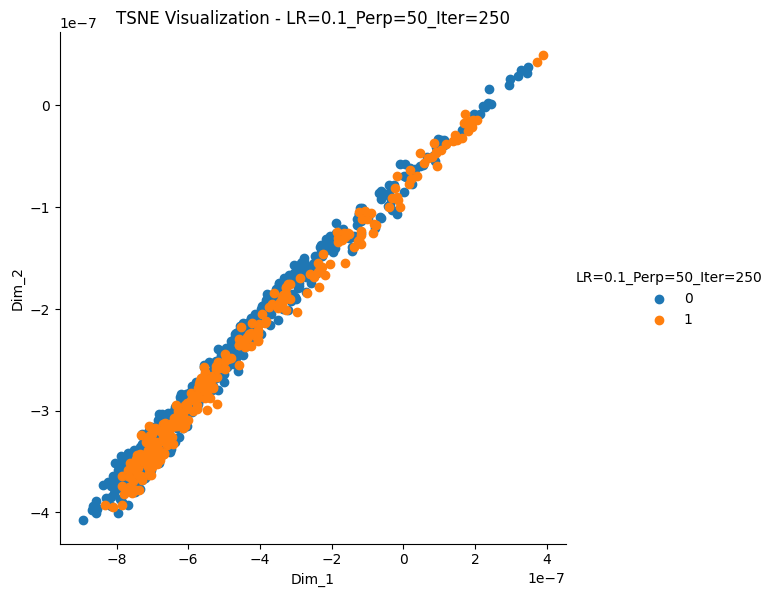

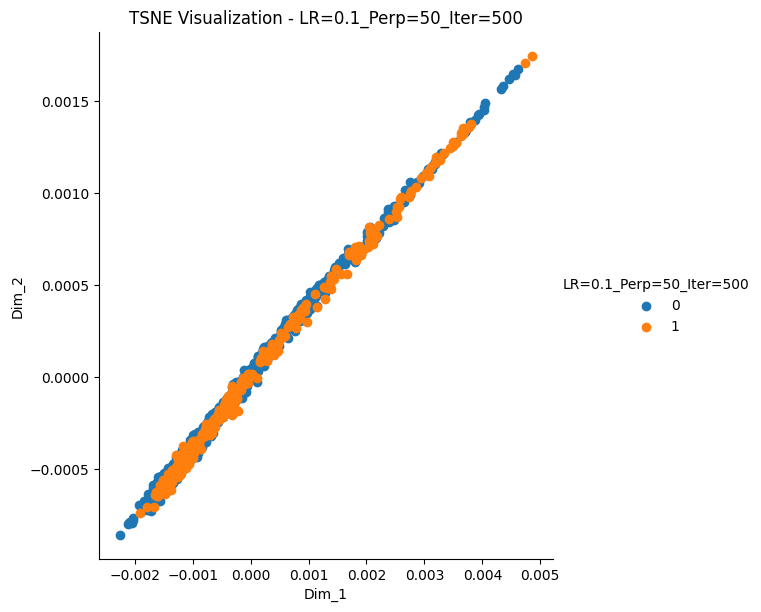

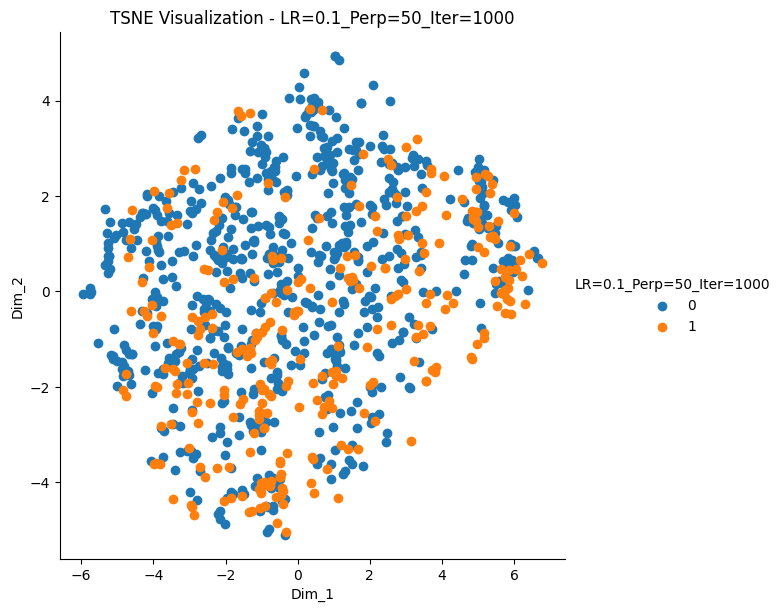

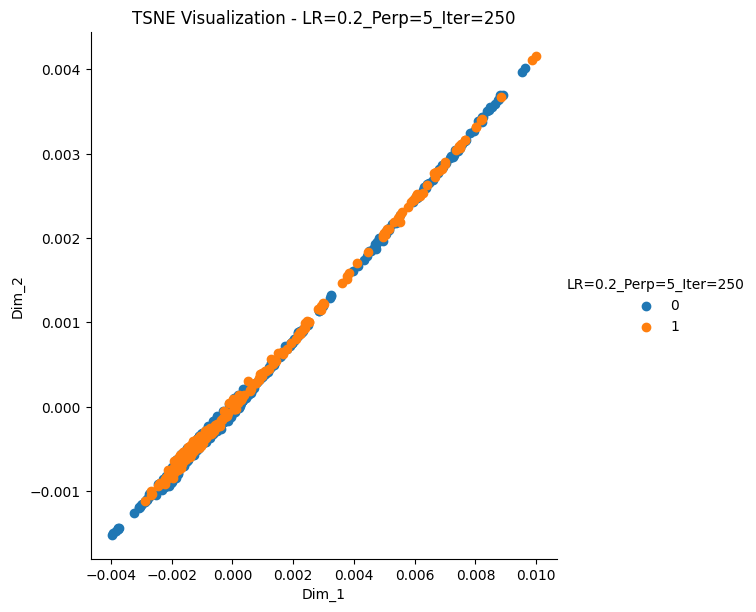

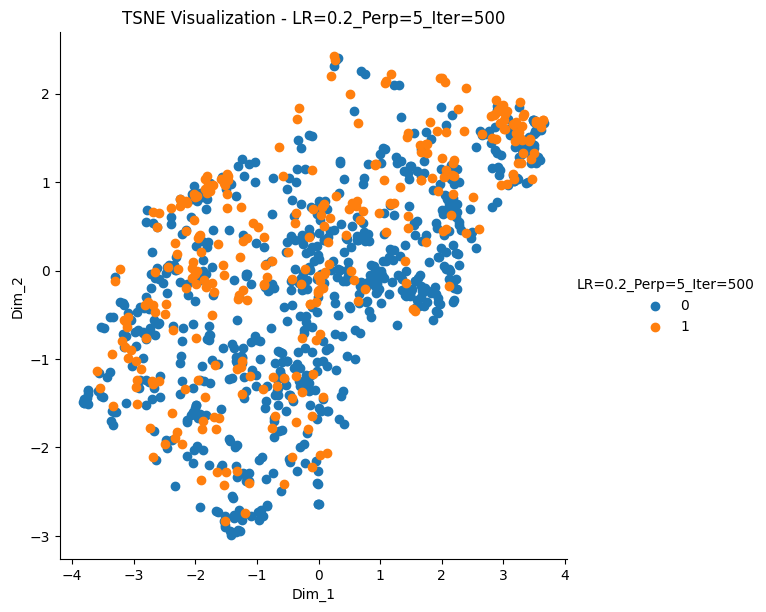

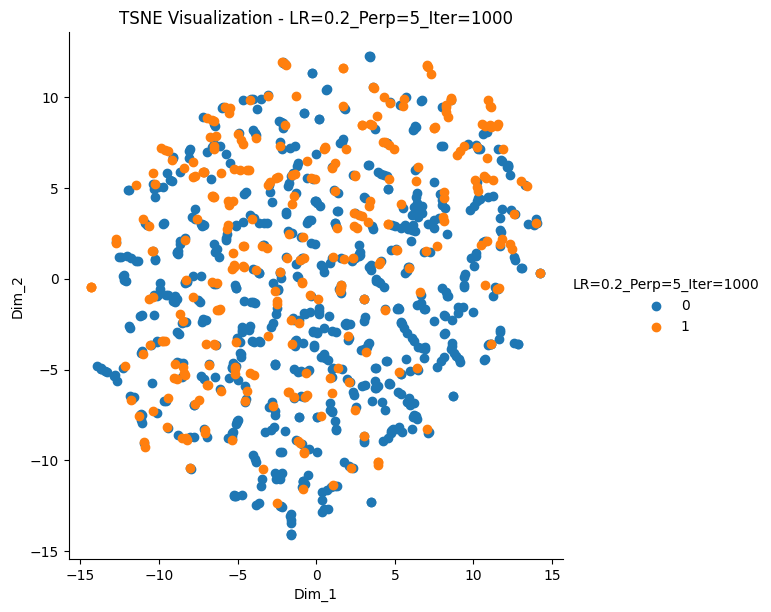

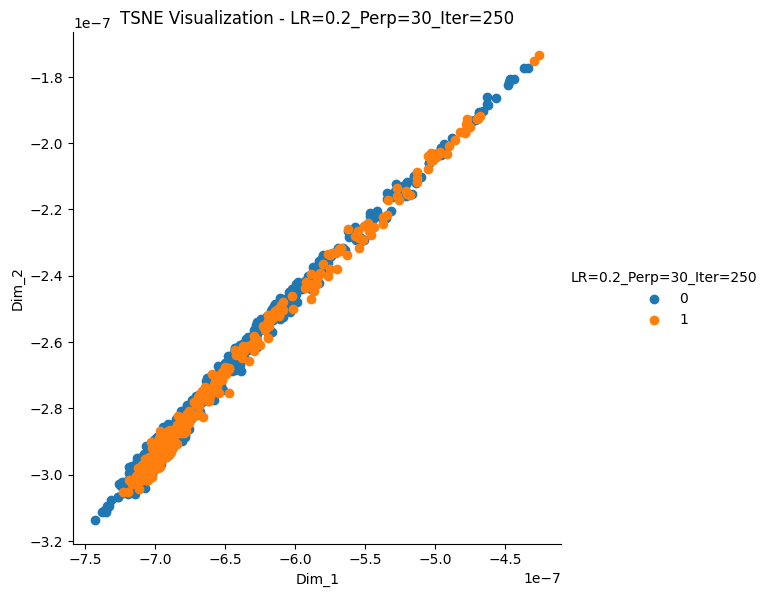

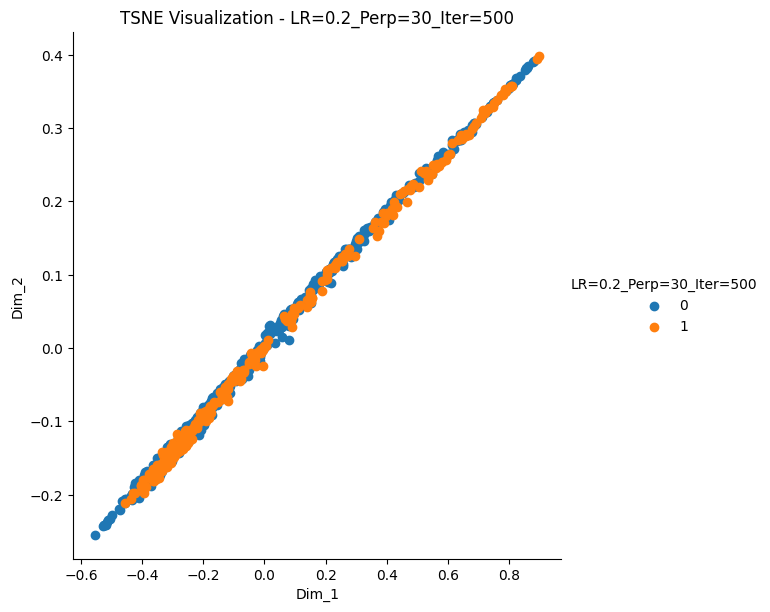

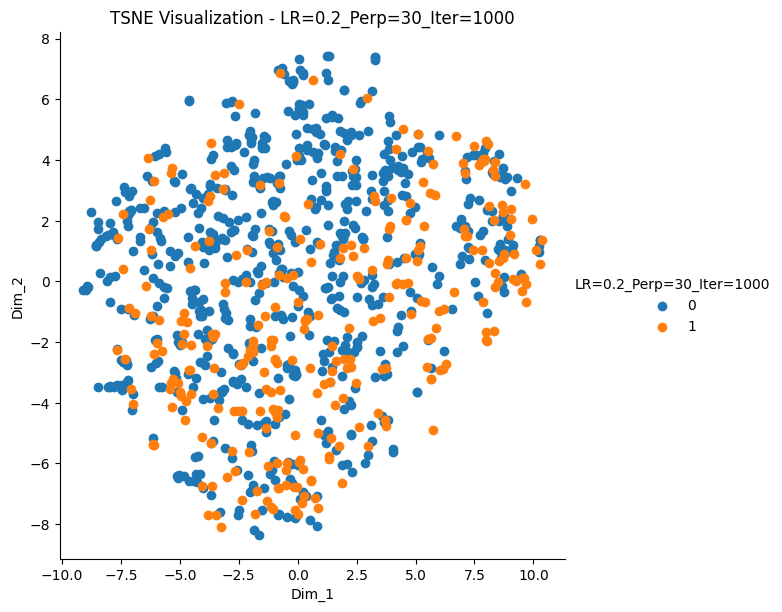

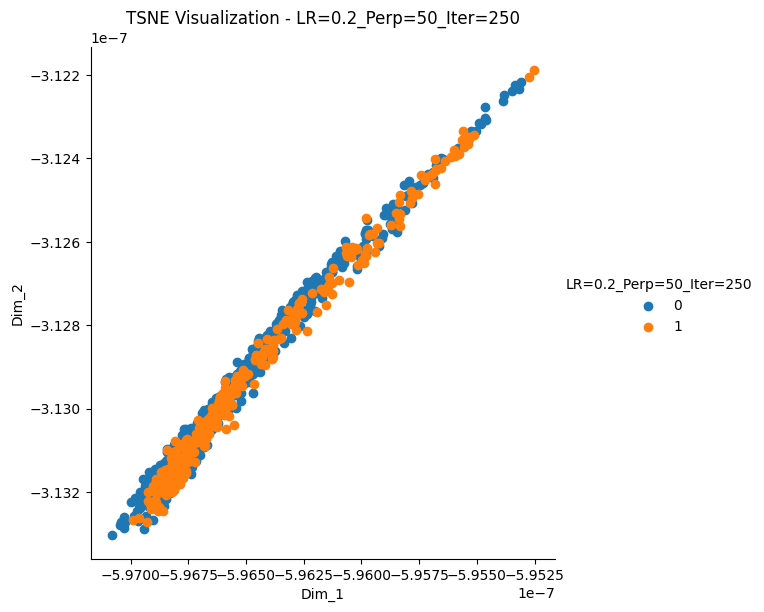

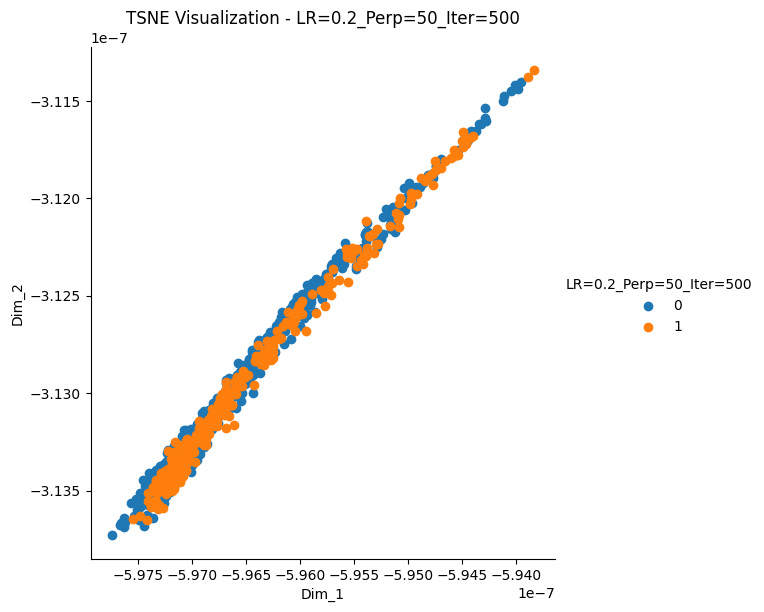

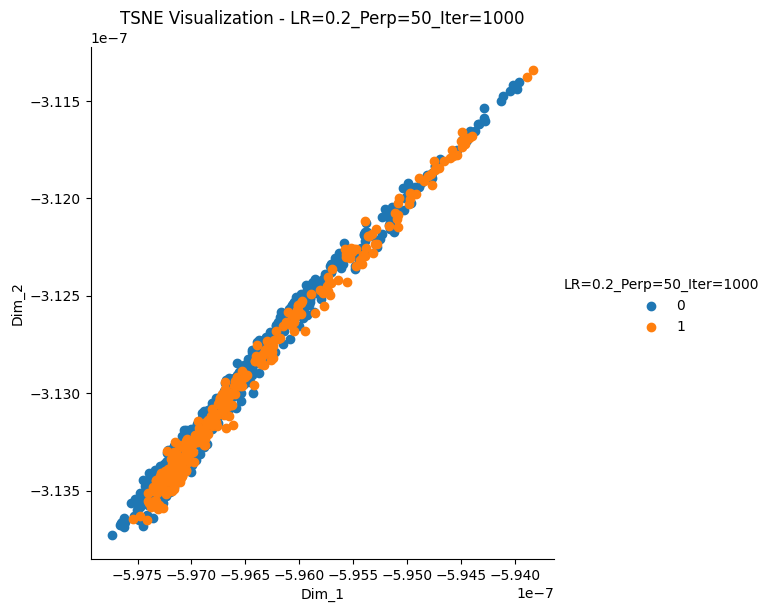

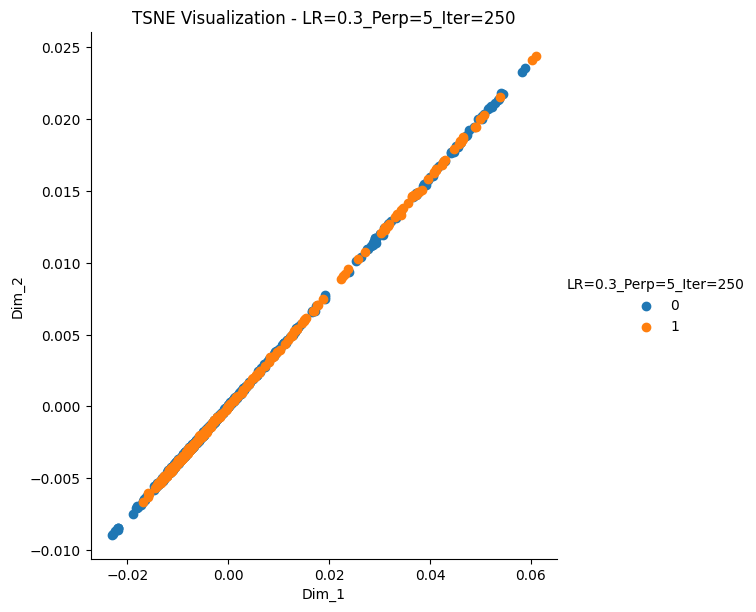

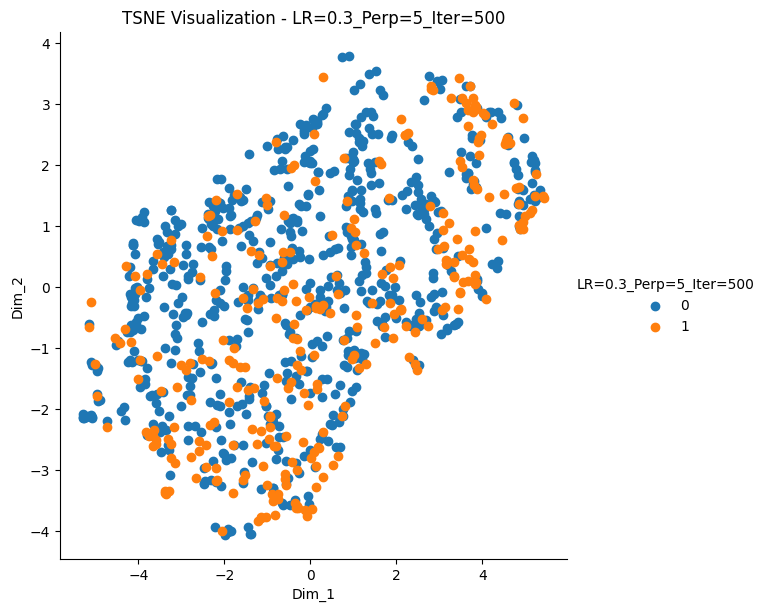

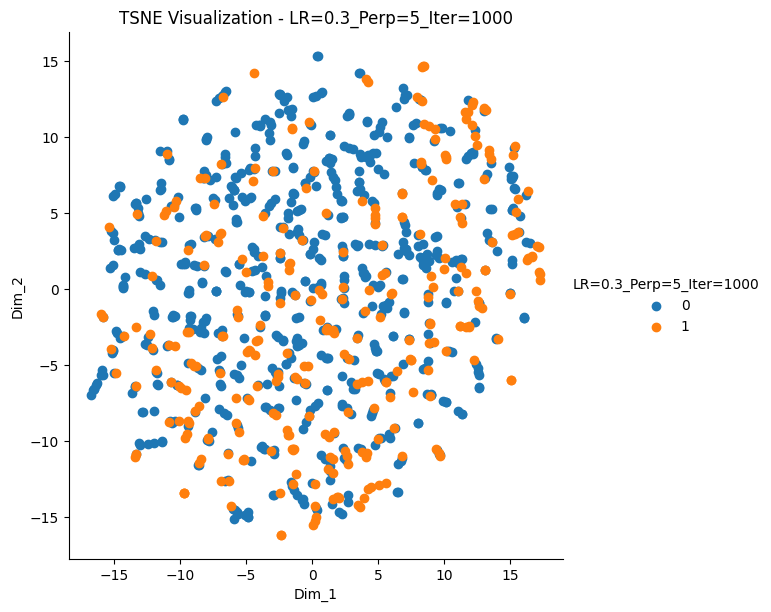

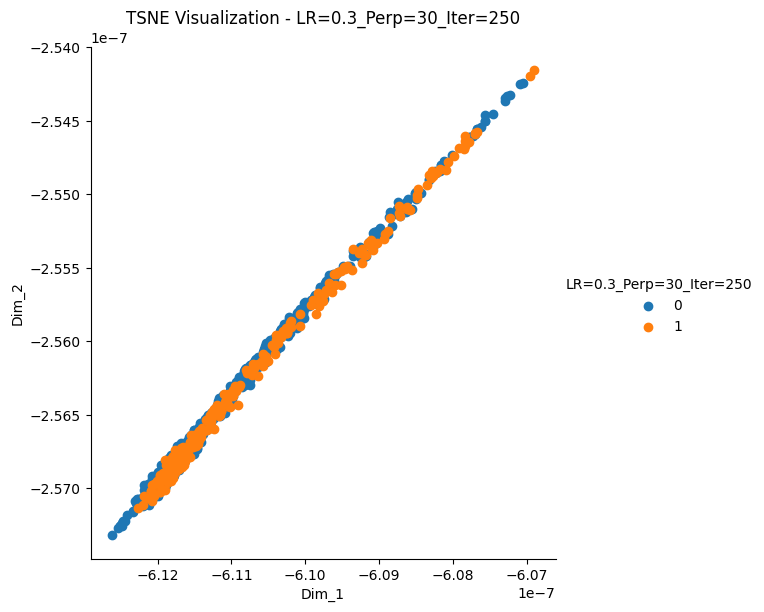

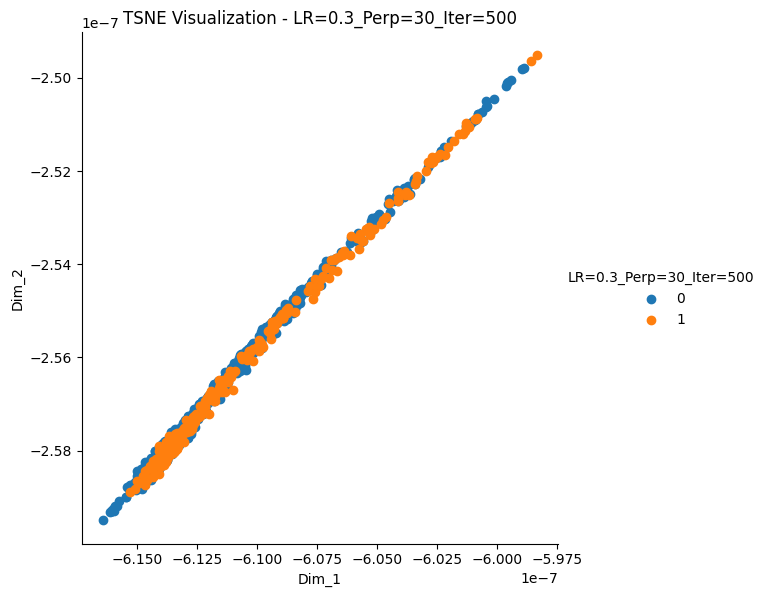

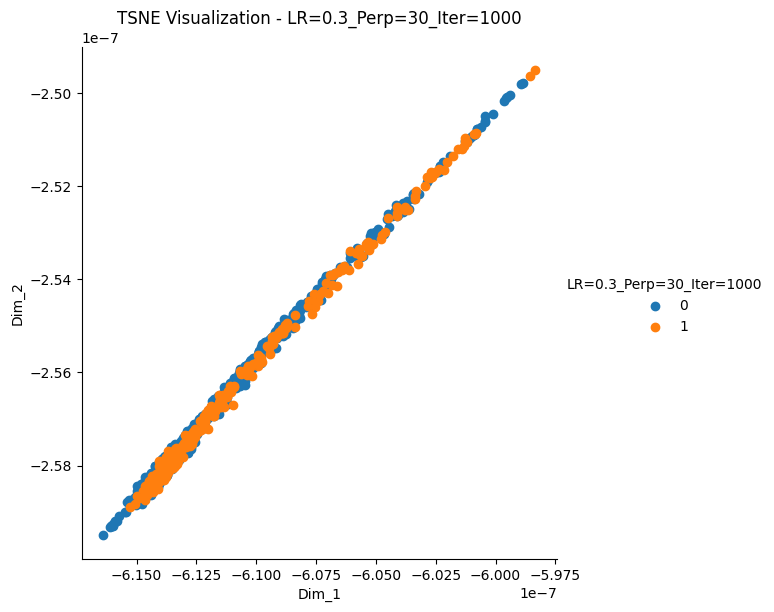

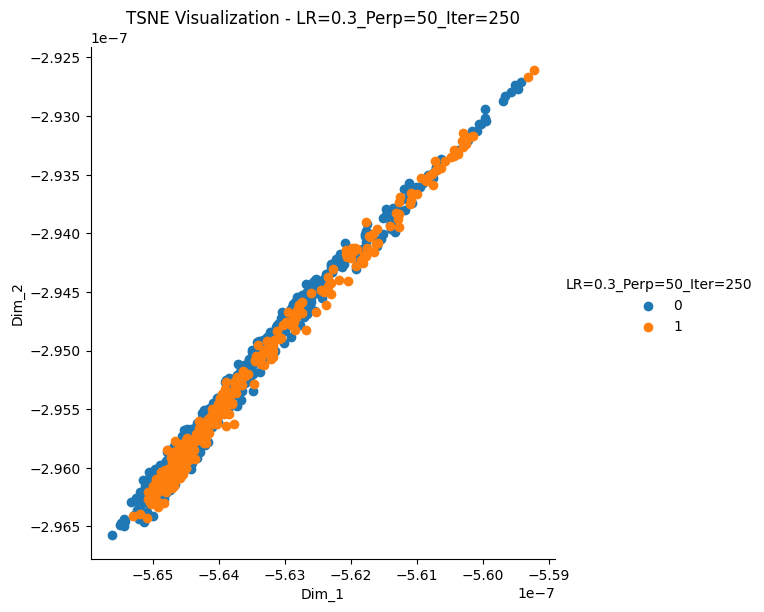

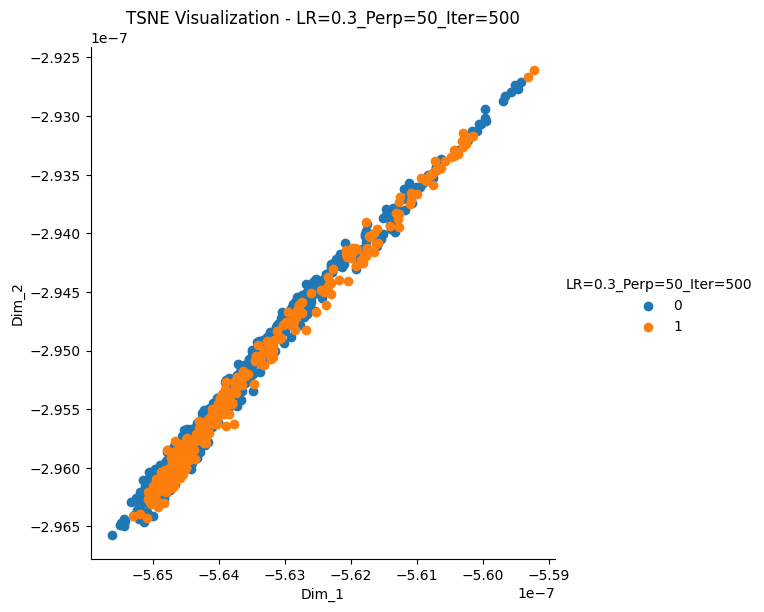

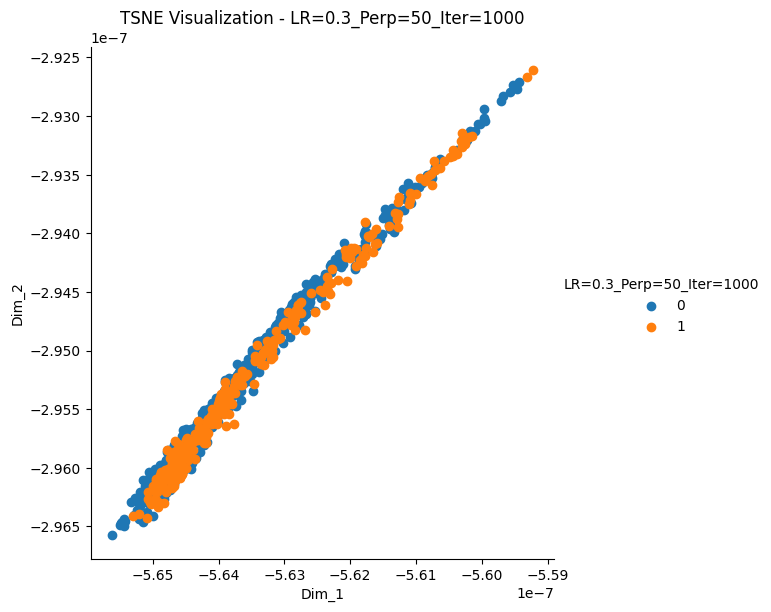

In [28]:
#Plotting t-SNE

#Defining learning rates (epsilon), perplexity and the number of iterations
learning_rates = [0.1, 0.2, 0.3]
perplexities = [5, 30, 50]
n_iterations = [250, 500, 1000]

# Iterating over learning rates, perplexities and iterations, finding the stable configuration
for lr in learning_rates:
    for perplexity in perplexities:
        for n_iter in n_iterations:
                model = TSNE(n_components=2, learning_rate=lr, perplexity=perplexity, n_iter=n_iter,
                             random_state=15)
                tsne_data = model.fit_transform(df_feature)

                tsne_df = pd.DataFrame(data=np.column_stack((tsne_data, labels)), columns=["Dim_1", "Dim_2", "label"])

                # Convert label column to integer
                tsne_df['label'] = tsne_df['label'].astype(int)

                # Plot the data with a unique label for each combination of lr, perplexity, and iteration
                label = f"LR={lr}_Perp={perplexity}_Iter={n_iter}"
                sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend(title=label)
                plt.title(f"TSNE Visualization - {label}")
                plt.show()

## 2.2 Unsupervised Data Analysis

In [20]:
labels = df_normalized['result']
df_pca_reduced = df_pca.copy()
df_feature_reduced = df_pca_reduced.drop(columns='labels')

### Hard Clustering: KMeans

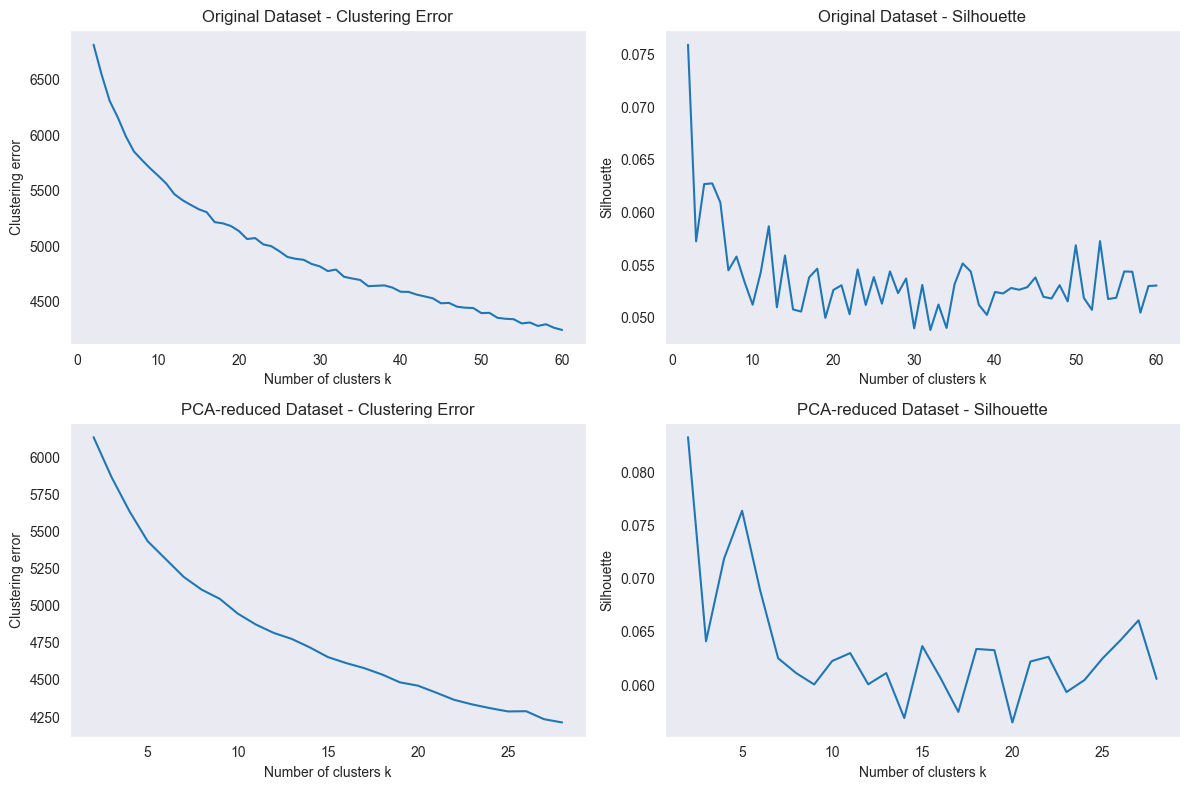

In [21]:
#We choose KMeans to perform hard cluster using the standardized dataset and the reduced dataset 
# Original dataset k-means results
kmeans_results_original = []
# PCA-reduced dataset k-means results
kmeans_results_pca = []
for k in range(2, 61):
    kmeans_results_original.append(KMeans(n_clusters=k, init='random').fit(df_feature))
for k in range(2, 29):
    kmeans_results_pca.append(KMeans(n_clusters=k, init='random').fit(df_feature_reduced))

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Original dataset
axs[0, 0].plot([k for k in range(2, 61)], [result.inertia_ for result in kmeans_results_original])
axs[0, 0].set_title("Original Dataset - Clustering Error")
axs[0, 0].set_xlabel("Number of clusters k")
axs[0, 0].set_ylabel("Clustering error")
axs[0, 0].grid()

axs[0, 1].plot([k for k in range(2, 61)], [silhouette_score(df_feature, result.labels_) for result in kmeans_results_original])
axs[0, 1].set_title("Original Dataset - Silhouette")
axs[0, 1].set_xlabel("Number of clusters k")
axs[0, 1].set_ylabel("Silhouette")
axs[0, 1].grid()

# PCA-reduced dataset
axs[1, 0].plot([k for k in range(2, 29)], [result.inertia_ for result in kmeans_results_pca])
axs[1, 0].set_title("PCA-reduced Dataset - Clustering Error")
axs[1, 0].set_xlabel("Number of clusters k")
axs[1, 0].set_ylabel("Clustering error")
axs[1, 0].grid()

axs[1, 1].plot([k for k in range(2, 29)], [silhouette_score(df_feature_reduced, result.labels_) for result in kmeans_results_pca])
axs[1, 1].set_title("PCA-reduced Dataset - Silhouette")
axs[1, 1].set_xlabel("Number of clusters k")
axs[1, 1].set_ylabel("Silhouette")
axs[1, 1].grid()

plt.tight_layout()
plt.show()

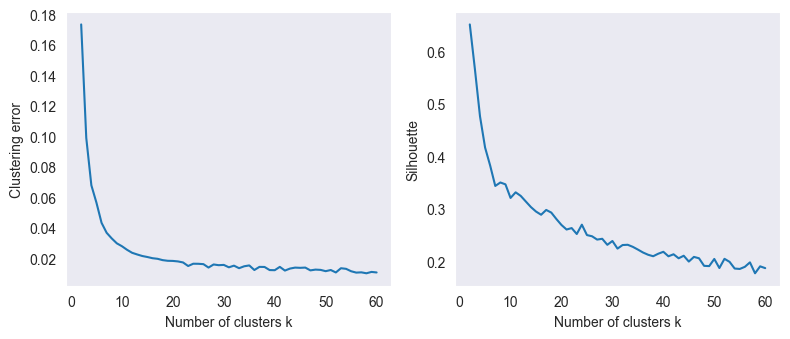

In [13]:
#Since the result of the silhouette score is not high, we try to normalize data in a different way
df_normalized_scikit=normalize(df_one_hot_encoded)
#Trying to find the best k: we run the algorithm multiple times to evaluate the performance
kmeans_results = []
for k in range(2,61):
    kmeans_results.append(KMeans(n_clusters=k, init='random').fit(df_normalized_scikit))

fig, axs = plt.subplots(1,2, figsize=(8, 3.5))

axs[0].plot(
    [k for k in range(2,61)],
    [result.inertia_ for result in kmeans_results]
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].grid()

axs[1].plot(
    [k for k in range(2,61)],
    [silhouette_score(df_normalized_scikit, result.labels_) for result in kmeans_results]
)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].grid()

plt.tight_layout()
plt.show()

### Clustering: KModes

In [22]:
#We try to find the best k using KModes
kmodes_results_original_dataset = []
for k in range(2, 61):
    kmodes_results_original_dataset.append(KModes(n_clusters=k, init='random').fit(df_feature))

# Calculate silhouette scores
silhouette_scores_original_kmodes = [silhouette_score(df_feature, result.labels_) for result in kmodes_results_original_dataset]

# Plotting
plt.plot(range(2, 61), silhouette_scores_original_kmodes)
plt.title("KModes - Silhouette Score for Original Dataset")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

KeyboardInterrupt: 

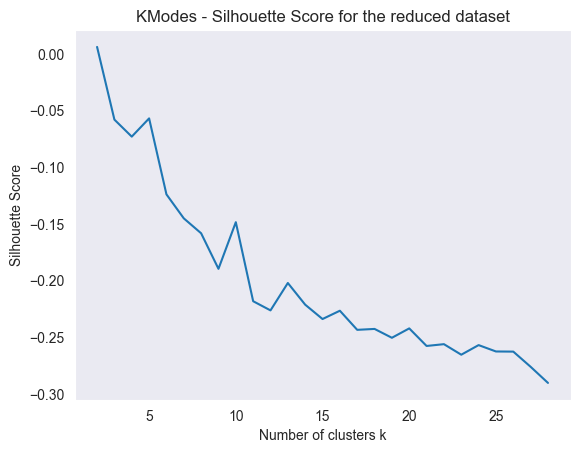

In [17]:
#We implement it also with the reduced dataset
kmodes_results_reduced_dataset = []
for k in range(2, 29):
    kmodes_results_reduced_dataset.append(KModes(n_clusters=k, init='random').fit(df_feature_reduced))

# Calculate silhouette scores
silhouette_scores_reduced_kmodes = [silhouette_score(df_feature_reduced, result.labels_) for result in kmodes_results_reduced_dataset]

# Plotting
plt.plot(range(2, 29), silhouette_scores_reduced_kmodes)
plt.title("KModes - Silhouette Score for the reduced dataset")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

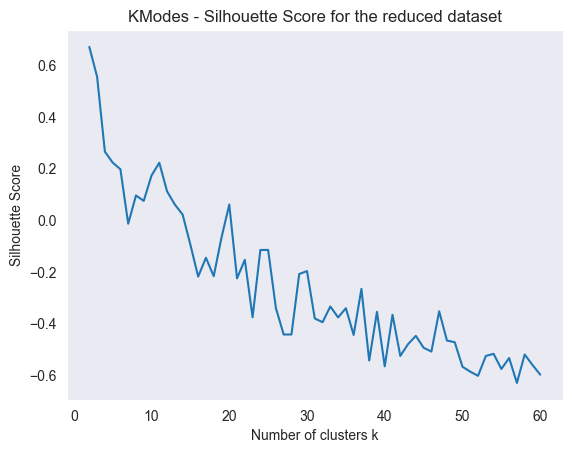

In [19]:
#We try with the different normalized dataset
kmodes_results_normalized_scikit = []
for k in range(2, 61):
    kmodes_results_normalized_scikit.append(KModes(n_clusters=k, init='random').fit(df_normalized_scikit))

# Calculate silhouette scores
silhouette_scores_normalization_kmodes = [silhouette_score(df_normalized_scikit, result.labels_) for result in kmodes_results_normalized_scikit]

# Plotting
plt.plot(range(2, 61), silhouette_scores_normalization_kmodes)
plt.title("KModes - Silhouette Score for the reduced dataset")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

### Elbow method

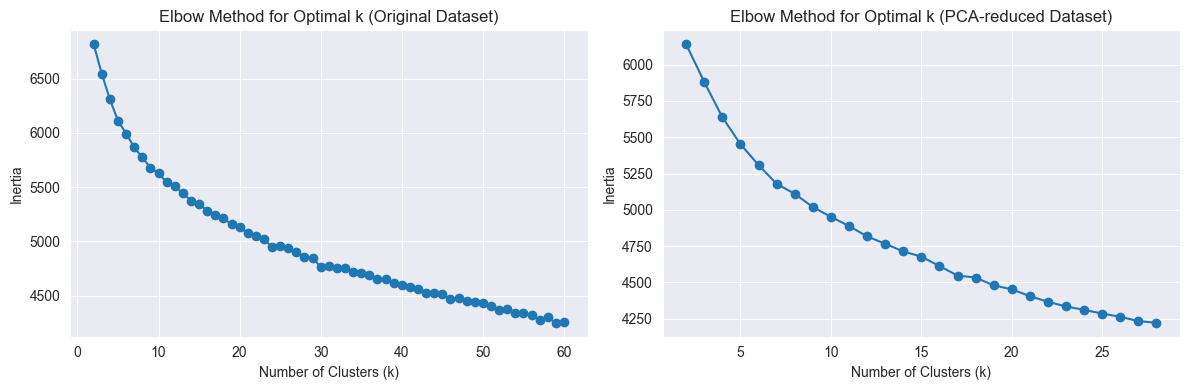

In [134]:
#We try to use also the Elbow method, using the original dataset and the reduced with PCA
inertia_original = []
for k in range(2, 61):
    kmeans = KMeans(n_clusters=k, init='random')
    kmeans.fit(df_feature)
    inertia_original.append(kmeans.inertia_)

# Elbow method for the PCA-reduced dataset
inertia_pca_reduced = []
for k in range(2, 29):
    kmeans = KMeans(n_clusters=k, init='random')
    kmeans.fit(df_feature_reduced)
    inertia_pca_reduced.append(kmeans.inertia_)

# Plotting the elbow curves
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Elbow curve for the original dataset
axs[0].plot(range(2, 61), inertia_original, marker='o')
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('Inertia')
axs[0].set_title('Elbow Method for Optimal k (Original Dataset)')

# Elbow curve for the PCA-reduced dataset
axs[1].plot(range(2, 29), inertia_pca_reduced, marker='o')
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('Inertia')
axs[1].set_title('Elbow Method for Optimal k (PCA-reduced Dataset)')

plt.tight_layout()
plt.show()

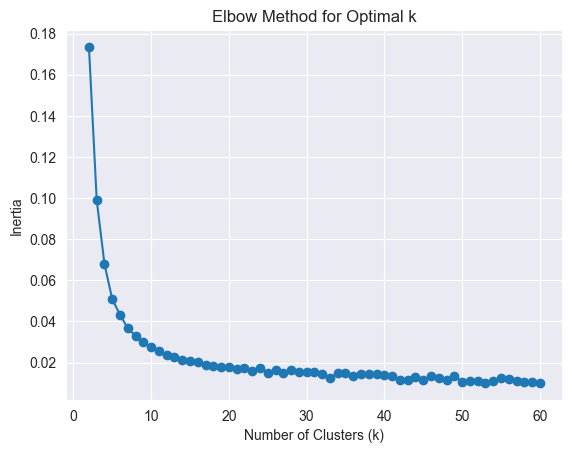

In [135]:
#Same attempt with elbow method, using a different normalized dataset
inertia = []
for k in range(2, 61):
    kmeans = KMeans(n_clusters=k, init='random')
    kmeans.fit(df_normalized_scikit)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(2, 61), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [122]:
#Iterating over the number of cluster, in order to find the best hyparameters with MinMax standardized dataset
best_silhouette = -1  # Initialize with a low value
best_params = None

for n_clusters in range(2, 10): #We iterate over a range (2,10) because we found that performance are better 
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(df_feature)

    silhouette = silhouette_score(df_feature, cluster_labels)
    ri = rand_score(np.ravel(labels), cluster_labels)
    ari = adjusted_rand_score(np.ravel(labels), cluster_labels)

    # Update the best parameters if the silhouette score is higher
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_params = {'n_clusters': n_clusters}

print(f'Best hyperparameters: {best_params}')
print(f'Best Silhouette score: {round(best_silhouette, 2)}')

Best hyperparameters: {'n_clusters': 2}
Best Silhouette score: 0.08


In [123]:
#Iterating over the number of cluster, in order to find the best hyparameters with scikit standardization
best_silhouette = -1  
best_params = None

for n_clusters in range(2, 10): 
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(df_normalized_scikit)

    silhouette = silhouette_score(df_normalized_scikit, cluster_labels)
    ri = rand_score(np.ravel(labels), cluster_labels)
    ari = adjusted_rand_score(np.ravel(labels), cluster_labels)

    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_params = {'n_clusters': n_clusters}

print(f'Best hyperparameters: {best_params}')
print(f'Best Silhouette score: {round(best_silhouette, 2)}')

Best hyperparameters: {'n_clusters': 2}
Best Silhouette score: 0.65


In [125]:
#Using KMeans with k=2, using the MinMax standardized dataset
kmeans = KMeans(n_clusters=2)
cluster_labels = kmeans.fit_predict(df_feature)

silhouette = silhouette_score(df_feature, cluster_labels)
ri = rand_score(np.ravel(labels), cluster_labels)
ari = adjusted_rand_score(np.ravel(labels), cluster_labels)

print('k-Means with 2 clusters')
(unique, counts)=np.unique( cluster_labels, return_counts=True)
print("Size of each cluster: ", counts)
print(f'k_means clustering error: {round(kmeans.inertia_, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

k-Means with 2 clusters
Size of each cluster:  [596 404]
k_means clustering error: 6816.85
Silhouette: 0.08
RI: 0.5
ARI: -0.0


In [124]:
#Using KMeans with k=2, using the scikit standardized dataset
kmeans = KMeans(n_clusters=2)
cluster_labels = kmeans.fit_predict(df_normalized_scikit)

silhouette = silhouette_score(df_normalized_scikit, cluster_labels)
ri = rand_score(np.ravel(labels), cluster_labels)
ari = adjusted_rand_score(np.ravel(labels), cluster_labels)

print('k-Means with 2 clusters')
(unique, counts)=np.unique( cluster_labels, return_counts=True)
print("Size of each cluster: ", counts)
print(f'k_means clustering error: {round(kmeans.inertia_, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

k-Means with 2 clusters
Size of each cluster:  [851 149]
k_means clustering error: 0.17
Silhouette: 0.65
RI: 0.53
ARI: -0.02


### Soft Clustering: GMM

In [136]:
#We are using now GMM as a soft clustering algorithm
n_cluster_list = []
shs_list = []
ri_list = []
ari_list = []
log_l_list = []

for n_clusters in range(3, 61):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels_gmm = gmm.fit_predict(df_feature)
    silhouette = silhouette_score(df_feature, cl_labels_gmm)
    n_cluster_list.append(n_clusters)
    shs_list.append(silhouette)
    ri_list.append(rand_score(np.ravel(labels), cl_labels_gmm))
    ari_list.append(adjusted_rand_score(np.ravel(labels), cl_labels_gmm))
    log_l_list.append(gmm.score(df_feature))

best_sh = np.max(shs_list)
best_n = n_cluster_list[np.argmax(shs_list)]
print("Best k for GMM (Original Dataset):", best_n, " with corresponding silhouette:", best_sh)

# For the reduced dataset
n_cluster_list_reduced = []
shs_list_reduced = []
ri_list_reduced = []
ari_list_reduced = []
log_l_list_reduced = []

for n_clusters in range(3, 29):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels_gmm_reduced = gmm.fit_predict(df_feature_reduced)
    silhouette_reduced = silhouette_score(df_feature_reduced, cl_labels_gmm_reduced)
    n_cluster_list_reduced.append(n_clusters)
    shs_list_reduced.append(silhouette_reduced)
    ri_list_reduced.append(rand_score(np.ravel(labels), cl_labels_gmm_reduced))
    ari_list_reduced.append(adjusted_rand_score(np.ravel(labels), cl_labels_gmm_reduced))
    log_l_list_reduced.append(gmm.score(df_feature_reduced))

best_sh_reduced = np.max(shs_list_reduced)
best_n_reduced = n_cluster_list_reduced[np.argmax(shs_list_reduced)]
print("Best k for GMM (Reduced Dataset):", best_n_reduced, " with corresponding silhouette:", best_sh_reduced)


Best k for GMM (Original Dataset): 3  with corresponding silhouette: 0.0651776437975254
Best k for GMM (Reduced Dataset): 4  with corresponding silhouette: 0.0654819956137265


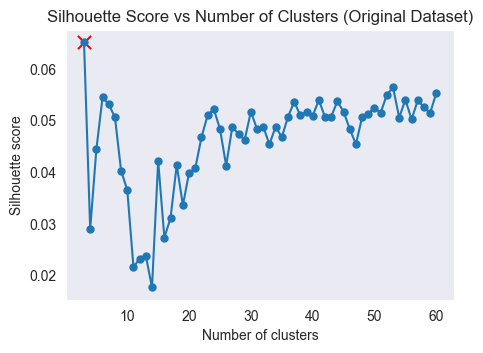

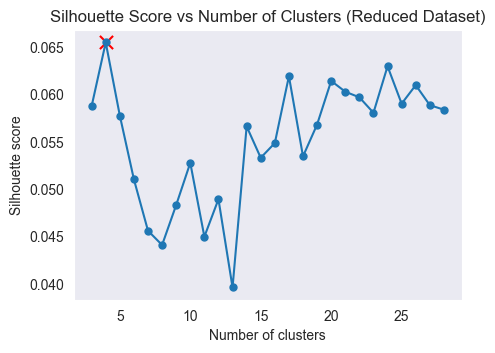

In [137]:
# Plot for the original dataset
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs Number of Clusters (Original Dataset)')
plt.show()

# Plot for the reduced dataset
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_reduced, shs_list_reduced, marker='o', markersize=5)
plt.scatter(best_n_reduced, best_sh_reduced, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs Number of Clusters (Reduced Dataset)')
plt.show()


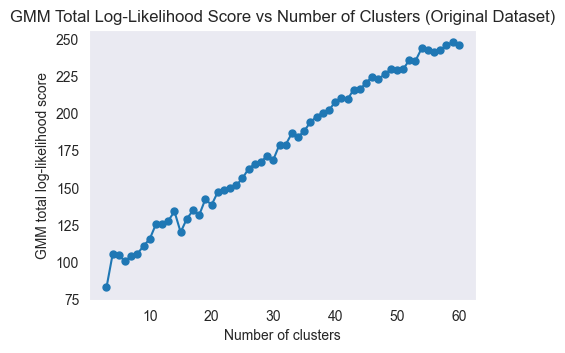

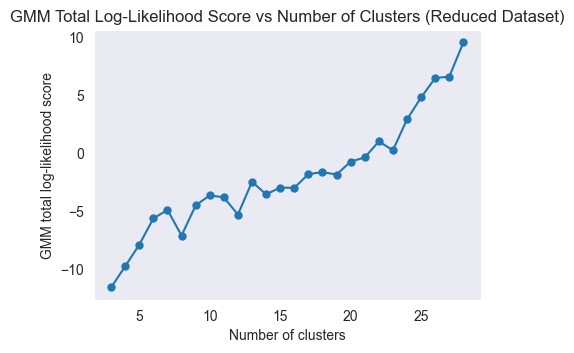

In [138]:
# Plot for the original dataset
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, log_l_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.title('GMM Total Log-Likelihood Score vs Number of Clusters (Original Dataset)')
plt.show()

# Plot for the reduced dataset
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_reduced, log_l_list_reduced, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.title('GMM Total Log-Likelihood Score vs Number of Clusters (Reduced Dataset)')
plt.show()



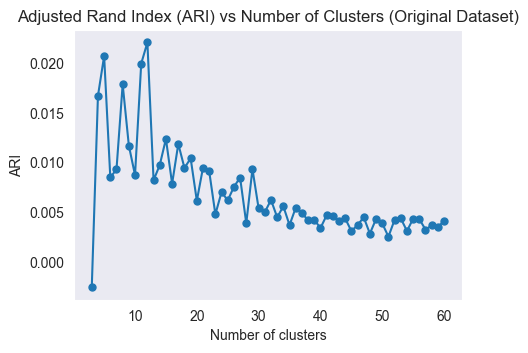

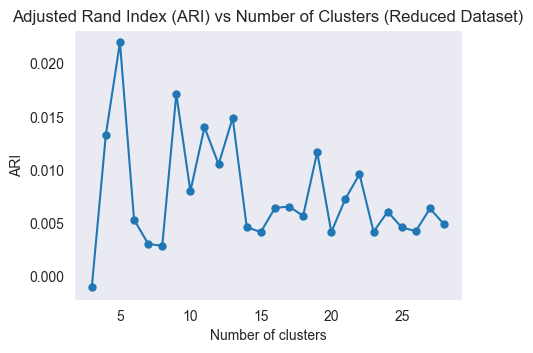

In [139]:
# Plot for the original dataset
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ari_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.title('Adjusted Rand Index (ARI) vs Number of Clusters (Original Dataset)')
plt.show()

# Plot for the reduced dataset
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_reduced, ari_list_reduced, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.title('Adjusted Rand Index (ARI) vs Number of Clusters (Reduced Dataset)')
plt.show()

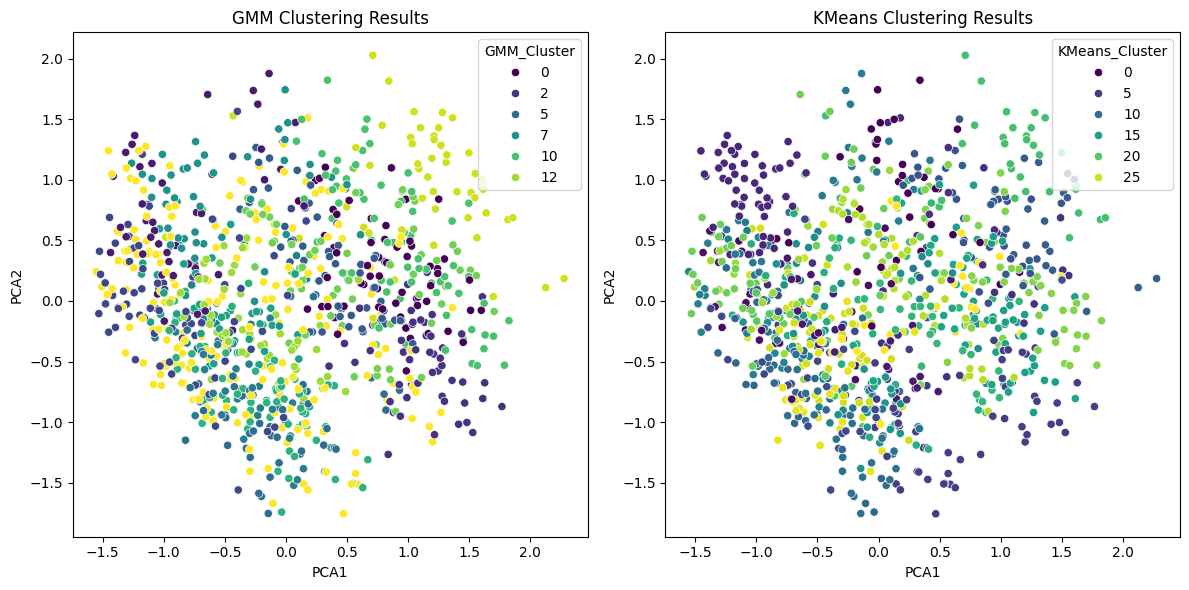

In [39]:
#To visualize the result, we use PCA, reducing on the first 2 components
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df_feature), columns=['PCA1', 'PCA2'])

df_visualization = pd.DataFrame({
    'PCA1': df_pca['PCA1'],
    'PCA2': df_pca['PCA2'],
    'GMM_Cluster': cl_labels_gmm,
    'KMeans_Cluster': cluster_labels
})

plt.figure(figsize=(12, 6))
#Plotting GMM
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_visualization, x='PCA1', y='PCA2', hue='GMM_Cluster', palette='viridis')
plt.title('GMM Clustering Results')
#Plotting KMeans
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_visualization, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='viridis')
plt.title('KMeans Clustering Results')

plt.tight_layout()
plt.show()

In [140]:
#Calculating purity for KMeans
conf_matrix_kmeans = confusion_matrix(labels, cluster_labels)
purity_kmeans = np.sum(np.max(conf_matrix_kmeans, axis=0)) / np.sum(conf_matrix_kmeans)
print('Purity for KMeans with 2 clusters:', round(purity_kmeans, 2))

#Calculating purity for GMM
conf_matrix_gmm = confusion_matrix(labels, cl_labels_gmm)
purity_gmm = np.sum(np.max(conf_matrix_gmm, axis=0)) / np.sum(conf_matrix_gmm)
print('Purity for GMM with best_k clusters:', round(purity_gmm, 2))

Purity for KMeans with 2 clusters: 0.7
Purity for GMM with best_k clusters: 0.74


# 3 Supervised Data Analysis

## 3.1 Classifier Selection

In [174]:
# model for the NN Pipeline
def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_validation.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [175]:
model = KerasClassifier(model=build_model, verbose=0, random_state=16)

In [176]:
# data normalization is performed inside the pipeline for each different split, in order to avoid data leakage.
LogRegPipe = Pipeline([("scale", MinMaxScaler()), ("LogReg", LogisticRegression(random_state = 42))])
RFPipe = Pipeline([("scale", MinMaxScaler()), ("RF", RandomForestClassifier(random_state = 16))])
NNPipe = Pipeline([("scale", MinMaxScaler()), ("NN", model)])

In [171]:
param_dict_logreg = {
    "LogReg__penalty": ["l1","l2"],
    "LogReg__C" : [0.2, 1, 1.5, 2],
    "LogReg__max_iter": [50, 60, 80, 100, 120],
    "LogReg__class_weight": ["balanced", None, {0: 1.43, 1: 3.33}]
}

param_dict_RF = {
    "RF__n_estimators": [50, 100, 200, 400, 600],
    "RF__max_depth": [10,15,20,25],
    "RF__max_features": ["sqrt",None,"log2"],
    "RF__min_samples_split": [2,4,6],
    "RF__class_weight": ["balanced", None, {0: 1.43, 1: 3.33}]
}

param_dict_NN = {
   'NN__batch_size':[5,10,20],  
    'NN__epochs':[1,2,4,6],
    "NN__class_weight": ["balanced", None, {0: 1.43, 1: 3.33}]
}

In [169]:
def cross_val_features(X,y,pipeline,param_dict):
    
    # Creating a basic frame for a DF that displays Permutation Importances from all folds in the outer CV
    feature_importance_df = pd.Series(X.columns).rename("Predictor")
    feature_importance_df = pd.DataFrame(feature_importance_df) 
    
        
    # Cross Validation
    # Outer CV
    perf_metrics = {}
    params = {}
    i = 1
    outer_cv = StratifiedKFold( n_splits = 5, random_state = 16, shuffle= True)
    inner_cv = StratifiedKFold(n_splits = 10, random_state = 16, shuffle= True)
    for train_index, test_index in outer_cv.split(X,y):
    # Repeat for all outer folds
        X_train = X.iloc[train_index,:]
        X_test = X.iloc[test_index, :]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        perf_metrics[f"Outer Fold {i}"] = {}
        params[f"Outer Fold {i}"] = {}
        # Inner CV
        ## Split into Training and Test
        ## For all combinations of parameter sets calculate model
        gridcv = GridSearchCV(estimator = pipeline, param_grid = param_dict, scoring = "f1", n_jobs = -1, cv = inner_cv)
        grid = gridcv.fit(X_train,y_train)
        ## Give the parameter set that has performed best on average over all inner folds to outer cv.

        # Outer CV
        ## Train Random Forest model with the parameter set of the Inner CV on the training set of the current outer fold
        pipeline.set_params(**grid.best_params_)
        pipeline.fit(X_train, y_train)
        params[f"Outer Fold {i}"] = pipeline.get_params()
        # Predict with fitted model
        y_pred = pipeline.predict(X_test)
        
        # Compute metrics for this outer fold
        perf_metrics[f"Outer Fold {i}"]["accuracy"] = accuracy_score(y_test, y_pred)
        perf_metrics[f"Outer Fold {i}"]["precision"] = precision_score(y_test, y_pred)
        perf_metrics[f"Outer Fold {i}"]["roc_auc"] = roc_auc_score(y_test, y_pred)
        perf_metrics[f"Outer Fold {i}"]["recall"] = recall_score(y_test, y_pred)
        perf_metrics[f"Outer Fold {i}"]["f1"] = f1_score(y_test, y_pred)

        ## Permutation Importance extraction
        perm_importance = permutation_importance(pipeline, X_train, y_train, scoring="accuracy", n_repeats=10)
        importances_mean = pd.Series(perm_importance.importances_mean).rename(f"Importance Mean Outer Fold {i}")
        importances_std = pd.Series(perm_importance.importances_std).rename(f"Importance Std Outer Fold {i}")
        feature_importance_df = pd.concat([feature_importance_df, importances_mean, importances_std], axis=1)
        
        print(f"Finished outer fold number {i}")
        i = i+1
        #feature_importance_df.sort_values(by=[f'Importance Mean Outer Fold {i}'],ascending=False)
        
        
        
        
    
    return feature_importance_df, perf_metrics, params

In [ ]:
fi_logreg, perf_logreg, params_logreg = cross_val_features(X_train_validation,
                                                           y_train_validation,LogRegPipe,param_dict_logreg)

In [178]:
df_perf_logreg = df.from_dict(perf_logreg)
df_perf_logreg

Outer Fold 1  Outer Fold 2  Outer Fold 3  Outer Fold 4  \
accuracy       0.712500      0.712500      0.706250      0.700000   
precision      0.514286      0.514286      0.508197      0.500000   
roc_auc        0.723214      0.723214      0.688988      0.708333   
recall         0.750000      0.750000      0.645833      0.729167   
f1             0.610169      0.610169      0.568807      0.593220   

           Outer Fold 5  
accuracy       0.687500  
precision      0.483871  
roc_auc        0.669643  
recall         0.625000  
f1             0.545455

In [179]:
df_params_logreg = df.from_dict(params_logreg)
df_params_logreg

Outer Fold 1  \
memory                                                                  None   
steps                      [(scale, MinMaxScaler()), (LogReg, LogisticReg...   
verbose                                                                False   
scale                                                         MinMaxScaler()   
LogReg                     LogisticRegression(C=1.5, class_weight='balanc...   
scale__clip                                                            False   
scale__copy                                                             True   
scale__feature_range                                                  (0, 1)   
LogReg__C                                                                0.2   
LogReg__class_weight                                      {0: 1.43, 1: 3.33}   
LogReg__dual                                                           False   
LogReg__fit_intercept                                                   True   
LogReg__intercept_scaling                                                  1   
LogReg__l1_ratio                                                        None   
LogReg__max_iter                                                          50   
LogReg__multi_class                                                     auto   
LogReg__n_jobs                                                          None   
LogReg__penalty                                                           l2   
LogReg__random_state                                                      42   
LogReg__solver                                                         lbfgs   
LogReg__tol                                                           0.0001   
LogReg__verbose                                                            0   
LogReg__warm_start                                                     False   

                                                                Outer Fold 2  \
memory                                                                  None   
steps                      [(scale, MinMaxScaler()), (LogReg, LogisticReg...   
verbose                                                                False   
scale                                                         MinMaxScaler()   
LogReg                     LogisticRegression(C=1.5, class_weight='balanc...   
scale__clip                                                            False   
scale__copy                                                             True   
scale__feature_range                                                  (0, 1)   
LogReg__C                                                                  1   
LogReg__class_weight                                      {0: 1.43, 1: 3.33}   
LogReg__dual                                                           False   
LogReg__fit_intercept                                                   True   
LogReg__intercept_scaling                                                  1   
LogReg__l1_ratio                                                        None   
LogReg__max_iter                                                          50   
LogReg__multi_class                                                     auto   
LogReg__n_jobs                                                          None   
LogReg__penalty                                                           l2   
LogReg__random_state                                                      42   
LogReg__solver                                                         lbfgs   
LogReg__tol                                                           0.0001   
LogReg__verbose                                                            0   
LogReg__warm_start                                                     False   

                                                                Outer Fold 3  \
memory                                                                  None   
steps                      [(scale, MinMaxScaler()), (LogReg, 

In [194]:
fi_logreg.sort_values(by=[f'Importance Mean Outer Fold 2'],ascending=False)

Predictor  Importance Mean Outer Fold 1  \
0           month_duration                      0.014688   
24          status_sex_A93                      0.010938   
48        saving_bonds_A64                      0.001719   
2         installment_rate                      0.009844   
12             purpose_A40                      0.000625   
..                     ...                           ...   
42    existing_account_A12                     -0.000156   
6         people_liability                     -0.005156   
53                job_A172                      0.001094   
35  installment_plans_A143                     -0.008125   
33  installment_plans_A141                     -0.005313   

    Importance Std Outer Fold 1  Importance Mean Outer Fold 2  \
0                      0.006412                      0.026563   
24                     0.005367                      0.012031   
48                     0.002031                      0.008125   
2                      0.007528                      0.006719   
12                     0.004593                      0.005938   
..                          ...                           ...   
42                     0.005781                     -0.005312   
6                      0.003701                     -0.005312   
53                     0.000716                     -0.005625   
35                     0.003617                     -0.007656   
33                     0.004485                     -0.009062   

    Importance Std Outer Fold 2  Importance Mean Outer Fold 3  \
0                      0.010102                      0.012969   
24                     0.004477                      0.003906   
48                     0.003263                      0.002813   
2                      0.006884                      0.000313   
12                     0.007648                      0.005156   
..                          ...                           ...   
42                     0.005238                      0.002188   
6                      0.001875                     -0.002344   
53                     0.002232                     -0.000625   
35                     0.002919                     -0.002344   
33                     0.004463                     -0.000781   

    Importance Std Outer Fold 3  Importance Mean Outer Fold 4  \
0                      0.008757                      0.003281   
24                     0.004803                      0.003281   
48                     0.001952                      0.005937   
2                      0.004463                     -0.000469   
12                     0.004894                     -0.003438   
..                          ...                           ...   
42                     0.005685                     -0.008906   
6                      0.001048                     -0.000625   
53                     0.001740                     -0.002031   
35                     0.003580                      0.007500   
33                     0.002446                      0.001875   

    Importance Std Outer Fold 4  Importance Mean Outer Fold 5  \
0                      0.006682                      0.010781   
24                     0.006345                      0.003906   
48                     0.002500                     -0.000469   
2                      0.007024                      0.008437   
12                     0.004931                      0.010937   
..                          ...                           ...   
42                     0.004894                      0.003750   
6                      0.000765                      0.004844   
53                     0.001719                     -0.002969   
35                     0.003684                     -0.002969   
33                     0.003815                     -0.005156   

    Importance Std Outer Fold 5  
0                      0.009490  
24                     0.003144  
48                     0.001570  
2                      0.006412  
12

In [81]:
mean_df_logreg = pd.DataFrame(df_perf_logreg.mean(axis=1),columns=['Mean'])
mean_df_logreg

Mean
accuracy   0.712500
precision  0.517191
roc_auc    0.710119
recall     0.704167
f1         0.595367

In [54]:
fi_rf, perf_rf, params_rf = cross_val_features(X_train_validation,y_train_validation,RFPipe,param_dict_RF)

In [56]:
df_perf_rf = df.from_dict(perf_rf)
df_perf_rf

Outer Fold 1  Outer Fold 2  Outer Fold 3  Outer Fold 4  \
accuracy       0.756250      0.731250      0.775000      0.737500   
precision      0.604651      0.571429      0.642857      0.568182   
roc_auc        0.694940      0.641369      0.714286      0.675595   
recall         0.541667      0.416667      0.562500      0.520833   
f1             0.571429      0.481928      0.600000      0.543478   

           Outer Fold 5  
accuracy       0.762500  
precision      0.625000  
roc_auc        0.693452  
recall         0.520833  
f1             0.568182

In [58]:
df_params_rf = df.from_dict(params_rf)
df_params_rf

Outer Fold 1  \
memory                                                                     None   
steps                         [(scale, MinMaxScaler()), (RF, (DecisionTreeCl...   
verbose                                                                   False   
scale                                                            MinMaxScaler()   
RF                            (DecisionTreeClassifier(max_depth=10, max_feat...   
scale__clip                                                               False   
scale__copy                                                                True   
scale__feature_range                                                     (0, 1)   
RF__bootstrap                                                              True   
RF__ccp_alpha                                                               0.0   
RF__class_weight                                                       balanced   
RF__criterion                                                              gini   
RF__max_depth                                                                10   
RF__max_features                                                           sqrt   
RF__max_leaf_nodes                                                         None   
RF__max_samples                                                            None   
RF__min_impurity_decrease                                                   0.0   
RF__min_samples_leaf                                                          1   
RF__min_samples_split                                                         6   
RF__min_weight_fraction_leaf                                                0.0   
RF__n_estimators                                                            100   
RF__n_jobs                                                                 None   
RF__oob_score                                                             False   
RF__random_state                                                             16   
RF__verbose                                                                   0   
RF__warm_start                                                            False   

                                                                   Outer Fold 2  \
memory                                                                     None   
steps                         [(scale, MinMaxScaler()), (RF, (DecisionTreeCl...   
verbose                                                                   False   
scale                                                            MinMaxScaler()   
RF                            (DecisionTreeClassifier(max_depth=10, max_feat...   
scale__clip                                                               False   
scale__copy                                                                True   
scale__feature_range                                                     (0, 1)   
RF__bootstrap                                                              True   
RF__ccp_alpha                                                               0.0   
RF__class_weight                                                       balanced   
RF__criterion                                                              gini   
RF__max_depth                                                                10   
RF__max_features                                                           log2   
RF__max_leaf_nodes                                                         None   
RF__max_samples                                                            None   
RF__min_impurity_decrease                                                   0.0   
RF__min_samples_leaf                                                          1   
RF__min_samples_split                                                         6   
RF__min_weight_fraction_leaf                                                0.0   
RF__n_estimators                                                            200   

In [ ]:
fi_rf.sort_values(by=[f'Importance Mean Outer Fold 2'],ascending=False)

In [60]:
mean_df_rf = pd.DataFrame(df_perf_rf.mean(axis=1),columns=['Mean'])
mean_df_rf

Mean
accuracy   0.752500
precision  0.602424
roc_auc    0.683929
recall     0.512500
f1         0.553003

In [61]:
fi_nn, perf_nn, params_nn = cross_val_features(X_train_validation,y_train_validation,NNPipe,param_dict_NN)

In [62]:
df_perf_nn = df.from_dict(perf_nn)
df_perf_nn

Outer Fold 1  Outer Fold 2  Outer Fold 3  Outer Fold 4  \
accuracy       0.731250      0.637500      0.706250      0.693750   
precision      0.532468      0.441860      0.507463      0.493506   
roc_auc        0.766369      0.681548      0.706845      0.721726   
recall         0.854167      0.791667      0.708333      0.791667   
f1             0.656000      0.567164      0.591304      0.608000   

           Outer Fold 5  
accuracy       0.731250  
precision      0.555556  
roc_auc        0.671131  
recall         0.520833  
f1             0.537634

In [63]:
df_params_nn = df.from_dict(params_nn)
df_params_nn

Outer Fold 1  \
memory                                                                  None   
steps                      [(scale, MinMaxScaler()), (NN, KerasClassifier...   
verbose                                                                False   
scale                                                         MinMaxScaler()   
NN                         KerasClassifier(\n\tmodel=<function build_mode...   
scale__clip                                                            False   
scale__copy                                                             True   
scale__feature_range                                                  (0, 1)   
NN__model                       <function build_model at 0x000002808F7E7A60>   
NN__build_fn                                                            None   
NN__warm_start                                                         False   
NN__random_state                                                          16   
NN__optimizer                                                        rmsprop   
NN__loss                                                                None   
NN__metrics                                                             None   
NN__batch_size                                                             5   
NN__validation_batch_size                                               None   
NN__verbose                                                                0   
NN__callbacks                                                           None   
NN__validation_split                                                     0.0   
NN__shuffle                                                             True   
NN__run_eagerly                                                        False   
NN__epochs                                                                 2   
NN__class_weight                                          {0: 1.43, 1: 3.33}   

                                                                Outer Fold 2  \
memory                                                                  None   
steps                      [(scale, MinMaxScaler()), (NN, KerasClassifier...   
verbose                                                                False   
scale                                                         MinMaxScaler()   
NN                         KerasClassifier(\n\tmodel=<function build_mode...   
scale__clip                                                            False   
scale__copy                                                             True   
scale__feature_range                                                  (0, 1)   
NN__model                       <function build_model at 0x000002808F7E7A60>   
NN__build_fn                                                            None   
NN__warm_start                                                         False   
NN__random_state                                                          16   
NN__optimizer                                                        rmsprop   
NN__loss                                                                None   
NN__metrics                                                             None   
NN__batch_size                                                            20   
NN__validation_batch_size                                               None   
NN__verbose                                                                0   
NN__callbacks                                                           None   
NN__validation_split                                                     0.0   
NN__shuffle                                                             True   
NN__run_eagerly                                                        False   
NN__epochs                                                                 6   
NN__class_weight                                                    balanced   

                                                              

In [76]:
fi_nn.sort_values(by=[f'Importance Mean Outer Fold 3'],ascending=False)

Predictor  Importance Mean Outer Fold 1  \
44    existing_account_A14                  1.687500e-02   
11      credit_history_A34                  2.062500e-02   
12             purpose_A40                  9.687500e-03   
24          status_sex_A93                  1.265625e-02   
2         installment_rate                  2.359375e-02   
..                     ...                           ...   
55                job_A174                  7.031250e-03   
20             purpose_A48                  9.375000e-04   
34  installment_plans_A142                  1.110223e-17   
14            purpose_A410                 -1.562500e-04   
5            credit_number                  2.187500e-03   

    Importance Std Outer Fold 1  Importance Mean Outer Fold 2  \
44                     0.006981                      0.023594   
11                     0.006510                      0.027500   
12                     0.001822                      0.014844   
24                     0.005610                      0.011094   
2                      0.005522                      0.018750   
..                          ...                           ...   
55                     0.001747                      0.007500   
20                     0.000765                     -0.000156   
34                     0.001849                      0.000625   
14                     0.000469                      0.000156   
5                      0.001593                      0.002031   

    Importance Std Outer Fold 2  Importance Mean Outer Fold 3  \
44                     0.006459                      0.035469   
11                     0.009170                      0.026406   
12                     0.007135                      0.026250   
24                     0.003919                      0.022813   
2                      0.004635                      0.017656   
..                          ...                           ...   
55                     0.003263                      0.000625   
20                     0.000469                      0.000469   
34                     0.001036                      0.000156   
14                     0.000841                     -0.000156   
5                      0.002799                     -0.001562   

    Importance Std Outer Fold 3  Importance Mean Outer Fold 4  \
44                     0.007814                      0.050312   
11                     0.006189                      0.014531   
12                     0.004181                      0.002031   
24                     0.003438                      0.005781   
2                      0.008813                      0.013437   
..                          ...                           ...   
55                     0.002633                      0.010937   
20                     0.000716                     -0.000313   
34                     0.000841                      0.003594   
14                     0.000469                      0.000312   
5                      0.002795                      0.000469   

    Importance Std Outer Fold 4  Importance Mean Outer Fold 5  \
44                     0.006084                      0.015625   
11                     0.007196                      0.012812   
12                     0.002711                      0.007031   
24                     0.003206                      0.014531   
2                      0.003840                      0.013437   
..                          ...                           ...   
55                     0.004582                      0.004687   
20                     0.000625                     -0.000938   
34                     0.002524                      0.003594   
14                     0.000625                      0.000313   
5                      0.001855                      0.001875   

    Importance Std Outer Fold 5  
44                     0.006011  
11                     0.006548  
12                     0.004595  
24                     0.005848  
2 

In [64]:
mean_df_nn = pd.DataFrame(df_perf_nn.mean(axis=1),columns=['Mean'])
mean_df_nn

Mean
accuracy   0.700000
precision  0.506171
roc_auc    0.709524
recall     0.733333
f1         0.592021

## 3.3


In [89]:
def get_roc_curve(y_test,y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
def get_confusion_matrix(y_test,y_pred):
    conf_mat = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_mat, annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g")
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

In [206]:
rf_final_metrics = {}
randomforest = RandomForestClassifier(max_depth=10,n_estimators=50,min_samples_split=6,max_features="sqrt", random_state=16,
                                     class_weight={0: 1.43, 1: 3.33}).fit(X_train_validation, y_train_validation)
rf_pred = randomforest.predict(X_test)
rf_final_metrics["accuracy"] = accuracy_score(y_test, rf_pred)
rf_final_metrics["precision"] = precision_score(y_test, rf_pred)
rf_final_metrics["roc_auc"] = roc_auc_score(y_test, rf_pred)
rf_final_metrics["recall"] = recall_score(y_test, rf_pred)
rf_final_metrics["f1"] = f1_score(y_test, rf_pred)

In [207]:
df_final_metrics = pd.DataFrame.from_dict(rf_final_metrics, orient='index', columns=['Metrics'])

df_final_metrics

Metrics
accuracy   0.770000
precision  0.645833
roc_auc    0.697619
recall     0.516667
f1         0.574074

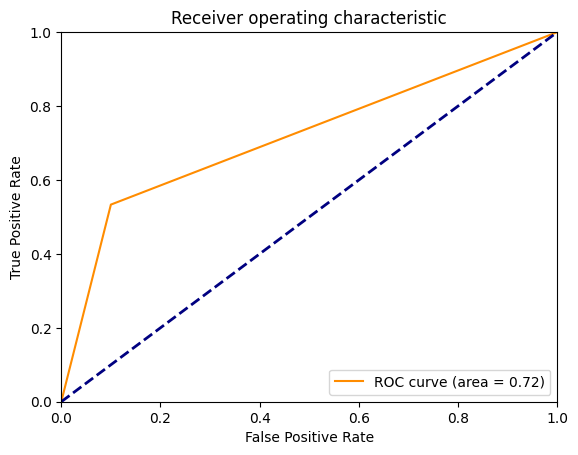

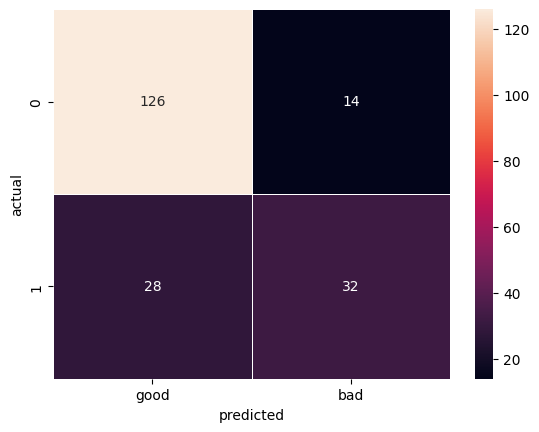

In [94]:
get_roc_curve(y_test,rf_pred)
get_confusion_matrix(y_test,rf_pred)

# 4. Adversarial Attacks

## 4.1: Random Noise



In [14]:
def generate_clipped_noise(test_data, euclidean_distance,scaling_factor):
    
    # Generate random noise from a Gaussian distribution with mean 0 and standard deviation 1
    noise = np.random.normal(0, 1,size=(test_data.shape))
    scaled_noise = noise * scaling_factor
    scaled_noise_norm = np.linalg.norm(scaled_noise)
    scaled_noise = scaled_noise * (euclidean_distance / scaled_noise_norm)
    noisy_test_data = test_data + scaled_noise
    return noisy_test_data

In [13]:
def robust_accuracy(classifier, X_test, y_test, euclidean_distance,scaling_factor):
    noise_data = generate_clipped_noise(X_test, euclidean_distance,scaling_factor)
    y_pred = classifier.predict(noise_data)
    # Measure accuracy on which we added noise
    robust_accuracy = accuracy_score(y_test, y_pred)
    robust_f1 = f1_score(y_test,y_pred)
    return robust_accuracy,robust_f1

In [12]:
euclidean_distances = [0.05,0.1,0.5,1,5,10,20,30,50,100,150,200]
test_data_norm = np.linalg.norm(X_test) # fixed

### Logistic Regression

In [15]:
logisticregression = LogisticRegression(penalty='l2',C=1.5,class_weight='balanced',max_iter=50).fit(X_train_validation, y_train_validation)
robust_accuracy_results = []
robust_f1_results = []
scalings = []
for euclidean_distance in euclidean_distances:
    scaling_factor = euclidean_distance / test_data_norm #scaling_noise_factor in respect to X_test, in order to have an idea of how weighted is the current euclidean_distance from X_test
    robust_acc, robust_f1 = robust_accuracy(logisticregression, X_test, y_test, euclidean_distance,scaling_factor)
    robust_accuracy_results.append(robust_acc)
    robust_f1_results.append(robust_f1)
    scalings.append(scaling_factor)

In [16]:
robust_df = pd.DataFrame(np.vstack((robust_accuracy_results, robust_f1_results,scalings)),columns=euclidean_distances).rename(index={0: "Robust_Accuracy", 1: "Robust_F1",2:"Scaling_Factor"})
robust_df

0.05      0.10      0.50      1.00      5.00      10.00   \
Robust_Accuracy  0.695000  0.695000  0.695000  0.700000  0.690000  0.710000   
Robust_F1        0.585034  0.585034  0.585034  0.589041  0.575342  0.613333   
Scaling_Factor   0.000926  0.001852  0.009261  0.018523  0.092614  0.185229   

                   20.00     30.00     50.00     100.00    150.00    200.00  
Robust_Accuracy  0.660000  0.655000  0.645000  0.550000  0.525000  0.585000  
Robust_F1        0.540541  0.488889  0.523490  0.444444  0.409938  0.484472  
Scaling_Factor   0.370458  0.555687  0.926144  1.852289  2.778433  3.704577

### Random Forest

In [21]:
randomforest = RandomForestClassifier(max_depth=10,n_estimators=50,min_samples_split=6,max_features="sqrt",class_weight={0: 1.43, 1: 3.33}).fit(X_train_validation, y_train_validation)
robust_accuracy_results = []
robust_f1_results = []
scalings = []
for euclidean_distance in euclidean_distances:
    scaling_factor = euclidean_distance / test_data_norm #scaling_noise_factor in respect to X_test, in order to have an idea of how weighted is the current euclidean_distance from X_test
    robust_acc, robust_f1 = robust_accuracy(randomforest, X_test, y_test, euclidean_distance,scaling_factor)
    robust_accuracy_results.append(robust_acc)
    robust_f1_results.append(robust_f1)
    scalings.append(scaling_factor)

In [22]:
robust_df = pd.DataFrame(np.vstack((robust_accuracy_results, robust_f1_results,scalings)),columns=euclidean_distances).rename(index={0: "Robust_Accuracy", 1: "Robust_F1",2:"Scaling_Factor"})
robust_df

0.05      0.10      0.50      1.00      5.00      10.00   \
Robust_Accuracy  0.760000  0.760000  0.775000  0.765000  0.720000  0.760000   
Robust_F1        0.563636  0.563636  0.594595  0.568807  0.508772  0.563636   
Scaling_Factor   0.000926  0.001852  0.009261  0.018523  0.092614  0.185229   

                   20.00     30.00     50.00     100.00    150.00    200.00  
Robust_Accuracy  0.725000  0.720000  0.710000  0.680000  0.685000  0.615000  
Robust_F1        0.529915  0.481481  0.408163  0.333333  0.322581  0.306306  
Scaling_Factor   0.370458  0.555687  0.926144  1.852289  2.778433  3.704577

### Neural Network

## 4.2 Feature Specific Noise

In [23]:

def robust_accuracy_single_feature(classifier, X_test, column, y_test, euclidean_distance,scaling_factor):
    feature_data_norm = np.linalg.norm(X_test[column])
    scaling_factor_feature = euclidean_distance / feature_data_norm #for each single feature create noisy data with clipped distance from the initial feature values
    noise_feature = generate_clipped_noise(X_test[column], euclidean_distance,scaling_factor_feature)
    X_noisy_feature = X_test.copy()
    X_noisy_feature[column] = noise_feature
    y_pred = classifier.predict(X_noisy_feature)
    # Measure accuracy on which we added noise
    robust_accuracy = accuracy_score(y_test, y_pred)
    robust_f1 = f1_score(y_test, y_pred)

    return robust_accuracy,robust_f1

def robust_feature(model, X_test, y_test, column):
    robust_accuracy_results = []
    robust_f1_results = []
    scalings = []
    for euclidean_distance in euclidean_distances:
        scaling_factor = euclidean_distance / test_data_norm
        robust_acc, robust_f1 = robust_accuracy_single_feature(model, X_test, column, y_test, euclidean_distance,scaling_factor)
        robust_accuracy_results.append(robust_acc)
        robust_f1_results.append(robust_f1)
        scalings.append(scaling_factor)
    robust_df = pd.DataFrame(np.vstack((robust_accuracy_results, robust_f1_results,scalings)),columns=euclidean_distances).rename(
    index={0: "robust_accuracy", 1: "robust_f1",2:"Scaling_Factor"})
    return robust_df



In [24]:
def calculate_robustness(model,features, metric):
    robust_value = []
    for feature in features:
        df = robust_feature(model, X_test, y_test, feature)
        if metric=="Robust Accuracy":
            robust_value.append(np.array(df.iloc[0,:]))
        elif metric=="Robust F1":
            robust_value.append(np.array(df.iloc[1,:]))
        
    return np.array(robust_value)

def feature_values_plot(top5, low5 , metric, title,model):
    low_series = calculate_robustness(model,low5, metric)
    top_series = calculate_robustness(model,top5, metric)        

    plt.figure(figsize=(10, 6))  
    reds = plt.cm.Reds(np.linspace(0.2,1,5))
    blues = plt.cm.Blues(np.linspace(0.2,1,5))
    for i in range(len(low_series)):
        plt.plot(euclidean_distances, low_series[i], label=low5[i], color=blues[i])
        plt.plot(euclidean_distances, top_series[i], label=top5[i], color=reds[i])
        
    plt.xlabel("Euclidean Distance")
    plt.ylabel(metric)
    plt.title(title)
    plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.3), ncol=6, fancybox=True)
    plt.show()
    
    frame1 = pd.DataFrame(top_series, columns=euclidean_distances, index=top5)
    display(frame1)
    
    frame2 = pd.DataFrame(low_series, columns=euclidean_distances, index=low5)
    display(frame2)

### Logistic Regression

In [25]:
best_5_feat_lr = ["month_duration", "status_sex_A93", "saving_bonds_A64", "installment_rate", "purpose_A40"]
worst_5_feat_lr = ["existing_account_A12", "people_liability", "job_A172", "installment_plans_A143", "installment_plans_A143"]

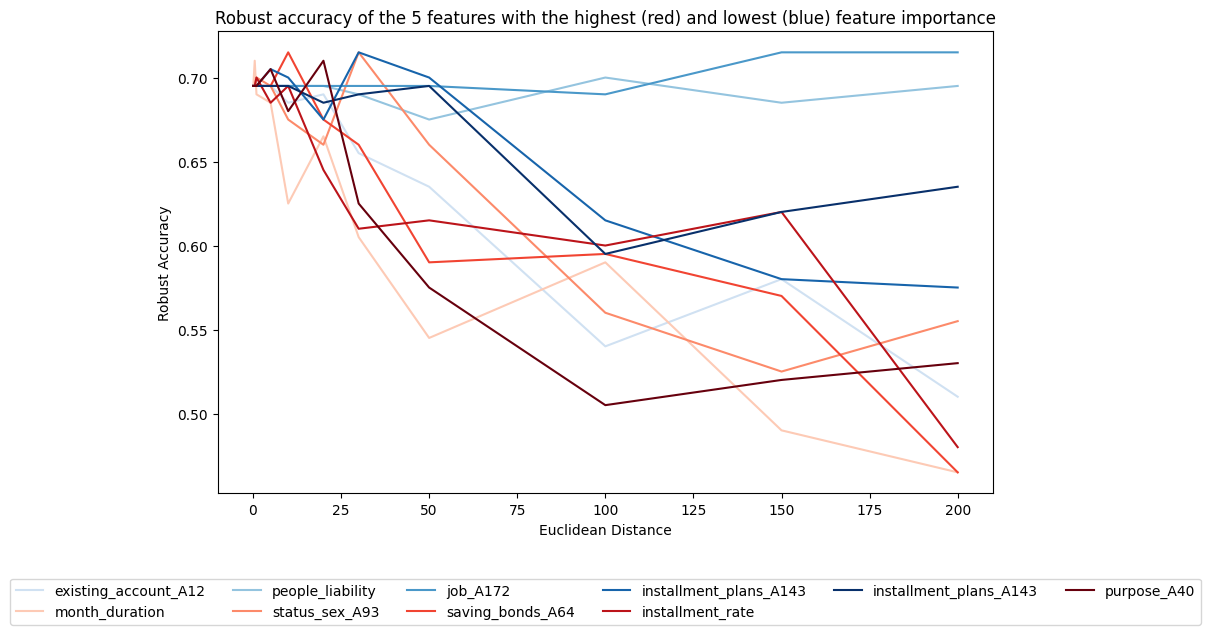

0.05    0.10    0.50    1.00    5.00    10.00   20.00   \
month_duration     0.695   0.695   0.710   0.690   0.685   0.625   0.665   
status_sex_A93     0.695   0.695   0.695   0.700   0.695   0.675   0.660   
saving_bonds_A64   0.695   0.695   0.695   0.695   0.695   0.715   0.675   
installment_rate   0.695   0.695   0.695   0.700   0.685   0.695   0.645   
purpose_A40        0.695   0.695   0.695   0.695   0.705   0.680   0.710   

                  30.00   50.00   100.00  150.00  200.00  
month_duration     0.605   0.545   0.590   0.490   0.465  
status_sex_A93     0.715   0.660   0.560   0.525   0.555  
saving_bonds_A64   0.660   0.590   0.595   0.570   0.465  
installment_rate   0.610   0.615   0.600   0.620   0.480  
purpose_A40        0.625   0.575   0.505   0.520   0.530

0.05    0.10    0.50    1.00    5.00    10.00   \
existing_account_A12     0.695   0.695   0.695   0.695   0.695   0.685   
people_liability         0.695   0.695   0.695   0.695   0.695   0.695   
job_A172                 0.695   0.695   0.695   0.695   0.695   0.695   
installment_plans_A143   0.695   0.695   0.695   0.695   0.705   0.700   
installment_plans_A143   0.695   0.695   0.695   0.695   0.695   0.695   

                        20.00   30.00   50.00   100.00  150.00  200.00  
existing_account_A12     0.690   0.655   0.635   0.540   0.580   0.510  
people_liability         0.695   0.690   0.675   0.700   0.685   0.695  
job_A172                 0.695   0.695   0.695   0.690   0.715   0.715  
installment_plans_A143   0.675   0.715   0.700   0.615   0.580   0.575  
installment_plans_A143   0.685   0.690   0.695   0.595   0.620   0.635

In [26]:
feature_values_plot(best_5_feat_lr, worst_5_feat_lr, "Robust Accuracy", 
                    "Robust accuracy of the 5 features with the highest (red) and lowest (blue) feature importance",logisticregression)

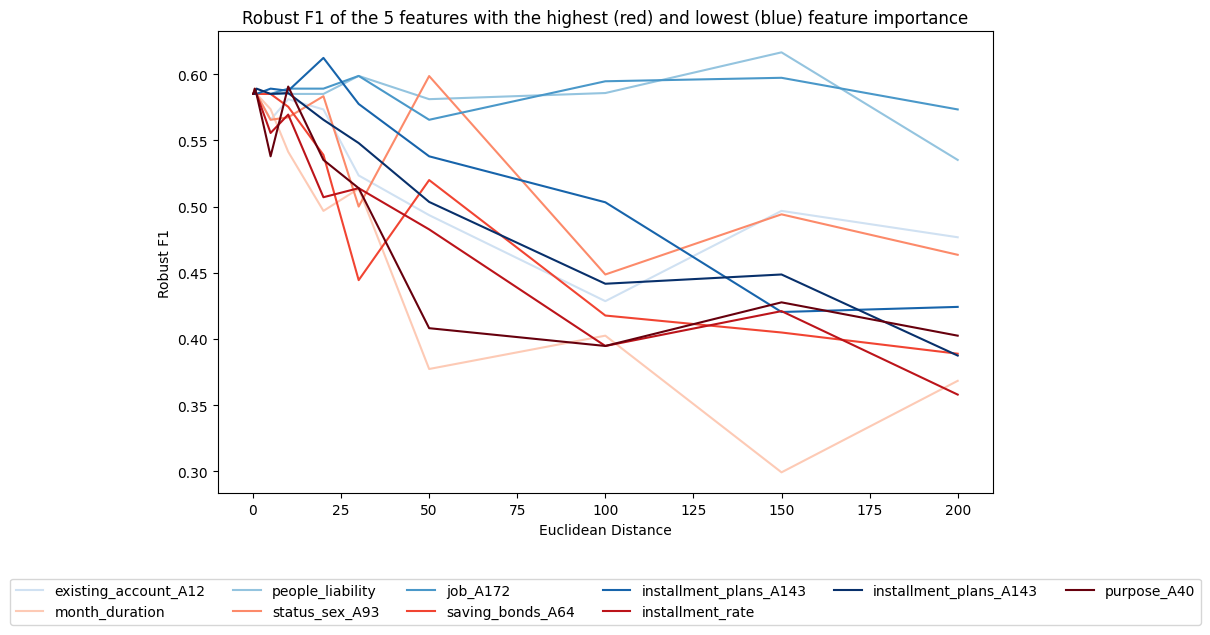

0.05      0.10      0.50      1.00      5.00      10.00   \
month_duration    0.585034  0.585034  0.589041  0.585034  0.573529  0.541353   
status_sex_A93    0.585034  0.585034  0.585034  0.585034  0.565517  0.567376   
saving_bonds_A64  0.585034  0.585034  0.585034  0.585034  0.585034  0.575342   
installment_rate  0.585034  0.585034  0.585034  0.585034  0.555556  0.569444   
purpose_A40       0.585034  0.585034  0.589041  0.585034  0.537931  0.590604   

                    20.00     30.00     50.00     100.00    150.00    200.00  
month_duration    0.496732  0.513514  0.377358  0.402516  0.299320  0.368421  
status_sex_A93    0.583333  0.500000  0.598540  0.448718  0.494118  0.463576  
saving_bonds_A64  0.539007  0.444444  0.520000  0.417722  0.404908  0.388889  
installment_rate  0.507042  0.513889  0.482759  0.394737  0.421053  0.358025  
purpose_A40       0.535211  0.513889  0.408163  0.394737  0.427673  0.402516

0.05      0.10      0.50      1.00      5.00    \
existing_account_A12    0.585034  0.585034  0.585034  0.585034  0.565517   
people_liability        0.585034  0.585034  0.585034  0.585034  0.585034   
job_A172                0.585034  0.585034  0.585034  0.585034  0.585034   
installment_plans_A143  0.585034  0.585034  0.585034  0.585034  0.589041   
installment_plans_A143  0.585034  0.585034  0.585034  0.589041  0.585034   

                          10.00     20.00     30.00     50.00     100.00  \
existing_account_A12    0.581081  0.573333  0.523490  0.493506  0.428571   
people_liability        0.585034  0.585034  0.598639  0.581081  0.585714   
job_A172                0.589041  0.589041  0.598639  0.565517  0.594595   
installment_plans_A143  0.587413  0.612245  0.577465  0.537931  0.503226   
installment_plans_A143  0.585714  0.565517  0.547945  0.503497  0.441718   

                          150.00    200.00  
existing_account_A12    0.496732  0.476821  
people_liability        0.616438  0.535211  
job_A172                0.597222  0.573333  
installment_plans_A143  0.420382  0.424242  
installment_plans_A143  0.448718  0.387500

In [27]:
feature_values_plot(best_5_feat_lr, worst_5_feat_lr, "Robust F1", 
                    "Robust F1 of the 5 features with the highest (red) and lowest (blue) feature importance",logisticregression)

### Random Forest

In [28]:
best_5_feat_rf = ["month_duration", "existing_account_A14", "existing_account_A11", "credit_amount", "installment_rate"]
worst_5_feat_rf = ["job_A171", "purpose_A48", "foreign_A201", "foreign_A202", "purpose_A44"]

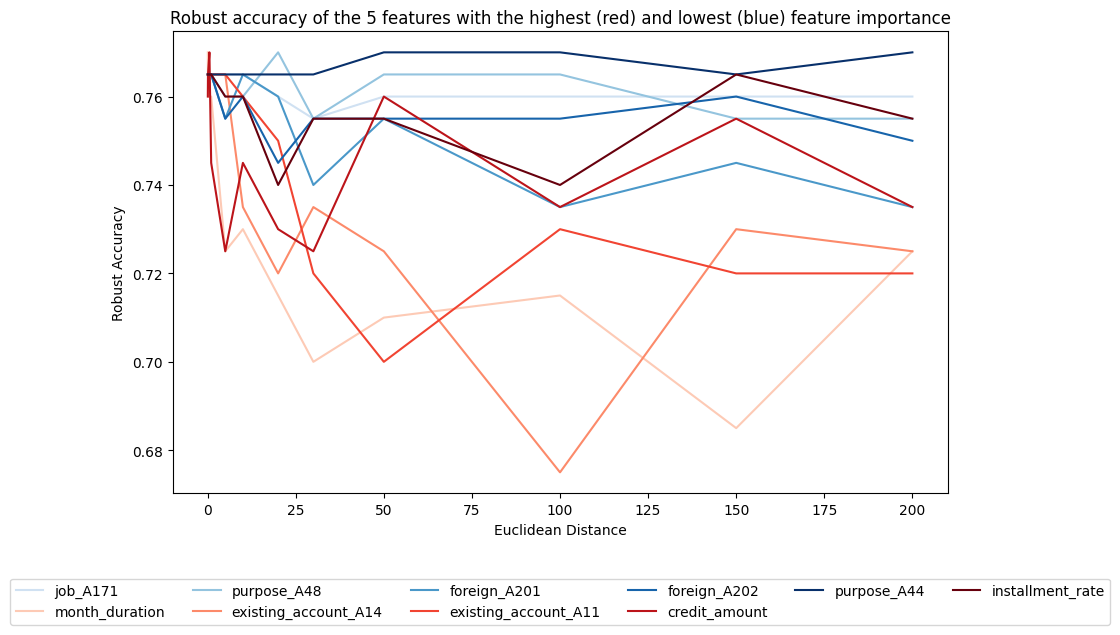

0.05    0.10    0.50    1.00    5.00    10.00   20.00   \
month_duration         0.770   0.760   0.760   0.760   0.725   0.730   0.715   
existing_account_A14   0.765   0.765   0.765   0.765   0.765   0.735   0.720   
existing_account_A11   0.765   0.765   0.765   0.765   0.765   0.760   0.750   
credit_amount          0.760   0.765   0.770   0.745   0.725   0.745   0.730   
installment_rate       0.765   0.765   0.765   0.765   0.760   0.760   0.740   

                      30.00   50.00   100.00  150.00  200.00  
month_duration         0.700   0.710   0.715   0.685   0.725  
existing_account_A14   0.735   0.725   0.675   0.730   0.725  
existing_account_A11   0.720   0.700   0.730   0.720   0.720  
credit_amount          0.725   0.760   0.735   0.755   0.735  
installment_rate       0.755   0.755   0.740   0.765   0.755

0.05    0.10    0.50    1.00    5.00    10.00   20.00   30.00   \
job_A171       0.765   0.765   0.765   0.765   0.765   0.765   0.760   0.755   
purpose_A48    0.765   0.765   0.765   0.765   0.760   0.760   0.770   0.755   
foreign_A201   0.765   0.765   0.765   0.765   0.755   0.765   0.760   0.740   
foreign_A202   0.765   0.765   0.765   0.765   0.755   0.760   0.745   0.755   
purpose_A44    0.765   0.765   0.765   0.765   0.765   0.765   0.765   0.765   

              50.00   100.00  150.00  200.00  
job_A171       0.760   0.760   0.760   0.760  
purpose_A48    0.765   0.765   0.755   0.755  
foreign_A201   0.755   0.735   0.745   0.735  
foreign_A202   0.755   0.755   0.760   0.750  
purpose_A44    0.770   0.770   0.765   0.770

In [29]:
feature_values_plot(best_5_feat_rf, worst_5_feat_rf, "Robust Accuracy", 
                    "Robust accuracy of the 5 features with the highest (red) and lowest (blue) feature importance",randomforest)

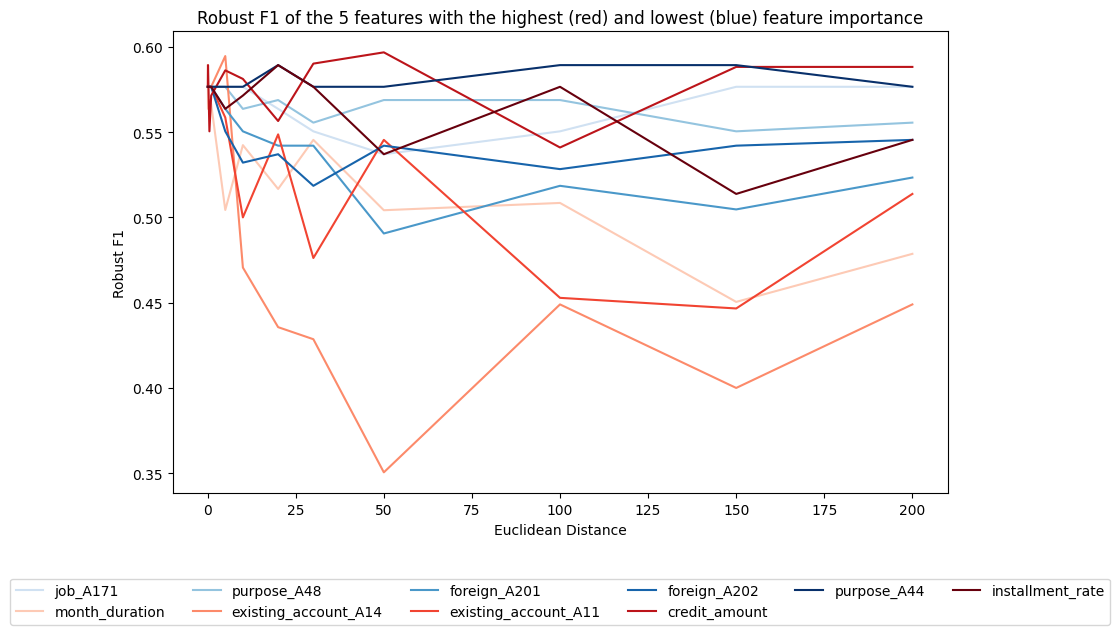

0.05      0.10      0.50      1.00      5.00    \
month_duration        0.589286  0.563636  0.568807  0.566372  0.504348   
existing_account_A14  0.576577  0.576577  0.576577  0.576577  0.594595   
existing_account_A11  0.576577  0.576577  0.576577  0.576577  0.558559   
credit_amount         0.576577  0.589286  0.550459  0.571429  0.586207   
installment_rate      0.576577  0.576577  0.576577  0.576577  0.563636   

                        10.00     20.00     30.00     50.00     100.00  \
month_duration        0.542373  0.516667  0.545455  0.504202  0.508475   
existing_account_A14  0.470588  0.435644  0.428571  0.350515  0.448980   
existing_account_A11  0.500000  0.548673  0.476190  0.545455  0.452830   
credit_amount         0.581197  0.556522  0.590164  0.596774  0.540984   
installment_rate      0.571429  0.589286  0.576577  0.537037  0.576577   

                        150.00    200.00  
month_duration        0.450450  0.478632  
existing_account_A14  0.400000  0.448980  
existing_account_A11  0.446602  0.513761  
credit_amount         0.588235  0.588235  
installment_rate      0.513761  0.545455

0.05      0.10      0.50      1.00      5.00      10.00   \
job_A171      0.576577  0.576577  0.576577  0.576577  0.576577  0.576577   
purpose_A48   0.576577  0.576577  0.576577  0.576577  0.576577  0.563636   
foreign_A201  0.576577  0.576577  0.576577  0.576577  0.563636  0.550459   
foreign_A202  0.576577  0.576577  0.576577  0.576577  0.550459  0.532110   
purpose_A44   0.576577  0.576577  0.576577  0.576577  0.576577  0.576577   

                20.00     30.00     50.00     100.00    150.00    200.00  
job_A171      0.563636  0.550459  0.537037  0.550459  0.576577  0.576577  
purpose_A48   0.568807  0.555556  0.568807  0.568807  0.550459  0.555556  
foreign_A201  0.542056  0.542056  0.490566  0.518519  0.504673  0.523364  
foreign_A202  0.537037  0.518519  0.542056  0.528302  0.542056  0.545455  
purpose_A44   0.589286  0.576577  0.576577  0.589286  0.589286  0.576577

In [30]:
feature_values_plot(best_5_feat_rf, worst_5_feat_rf, "Robust F1", 
                    "Robust F1 of the 5 features with the highest (red) and lowest (blue) feature importance",randomforest)

### Neural Network

In [122]:
import random as rn
import os
from keras import backend as K
os.environ['PYTHONHASHSEED'] = '0'
tf.get_logger().setLevel('INFO')
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

## 4.3


In [28]:
onehot_y_train = pd.get_dummies(y_train_validation)
onehot_y_test = pd.get_dummies(y_test)

In [29]:
def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_validation.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [30]:
def build_classifier():
    # Step 3: Create the ART classifier
    classifier = ARTKerasClassifier(model=build_model())
    # Step 4: Train the ART classifier
    classifier.fit(X_train_validation, onehot_y_train, batch_size=64, nb_epochs=3)
    return classifier

# Gradient Based attacks

## Solve inner maximization

The common approach to training a classifier is to optimize the parameters $ \theta $, so as to minimize the average loss over some training set which we write as the optimization problem (formula) which we typically solve by (stochastic) gradient descent. In other words, for some minibatch (a small subset of the training data) we compute the gradient of our loss with respect to the parameters $\theta$. Then we make a small adjustment to $ \theta $ (formula) using $\alpha$ as some step size, and we repeat this process  for different minibatches covering the entire training set, until the parameters converge. 

We have seen that in NN the gradient is computed efficiently with backpropagation. If we compute the gradient of the loss with respect to the input $ x_i$ the result will tell us how small changes to the data affect the loss function. With adversarial examples instead of adjusting the parameters to minimize the loss we try to adjust them to **maximixe** the loss. In other words our aim is to ensure that our adversarial example is close to our original input optimizing over the perturbation $ \delta $ to x.

A common perturbation set to use is the $L^{inf}$ ball (norm) (formula). We allow the perturbation to have magnitude between $[−\epsilon,\epsilon]$

## FGSM 
FGSM is a white box, non-targeted evasion attack. Non-targeted means that we are trying to maximize the loss for the true class label. 
With FGSM in order to maximize the loss we want to adjust the $\delta$ in the direction of the gradient i.e. take a step and then project back into the norm ball defined by $||\delta|| \leq \epsilon$. If we want to make increase the loss as much as possible we need to take the as lage a step possible. 
For large $\alpha$ the update becomes $\delta := \epsilon \cdot \mathrm{sign}(g)$. Epsilon controls the magnitude of the perturbations. FGSM calculates the gradient only once. This method is not designed to find the minimal perturbations, so it would result in larger perturbations and also requires manual adjustment of the parameter of $\epsilon$ to get desired results


In [12]:
def FGSM(classifier):
    fgm_range = np.arange(0.0, 2, 0.1)
    fgm_acc=[]
    for eps in fgm_range:
        attack_FGM = FastGradientMethod(estimator=classifier, eps=eps)
        Xtest_FGM = attack_FGM.generate(x=np.array(X_test))
        preds_FGM = classifier.predict(Xtest_FGM)
        accuracy_FGM = np.sum(np.argmax(preds_FGM, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
        fgm_acc.append(accuracy_FGM)
    
    '''PLOT'''
    plt.figure(figsize=(10,5))
    plt.title("FSGM")
    plt.ylabel('Accuracy')
    plt.xlabel('Epsilon')
    plt.ylim((0,1))
    plt.plot(fgm_range, fgm_acc)
    
    plt.show()
    print("Accuracy on adversarial test examples with FGSM attack: {}%".format(accuracy_FGM * 100))
    print(f"Steps of accuracy {fgm_acc}")
    return Xtest_FGM, attack_FGM

FGSM is just a single projected gradient descent step under the $L^{inf}$ constraint. 

2024-01-24 01:16:08.949180: W tensorflow/c/c_api.cc:305] Operation '{name:'training_158/Adam/dense_237/kernel/m/Assign' id:34107 op device:{requested: '', assigned: ''} def:{{{node training_158/Adam/dense_237/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_158/Adam/dense_237/kernel/m, training_158/Adam/dense_237/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-24 01:16:10.874778: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_239/Sigmoid' id:33888 op device:{requested: '', assigned: ''} def:{{{node dense_239/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_239/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trig

Accuracy on benign test examples: 75.5%

FGSM


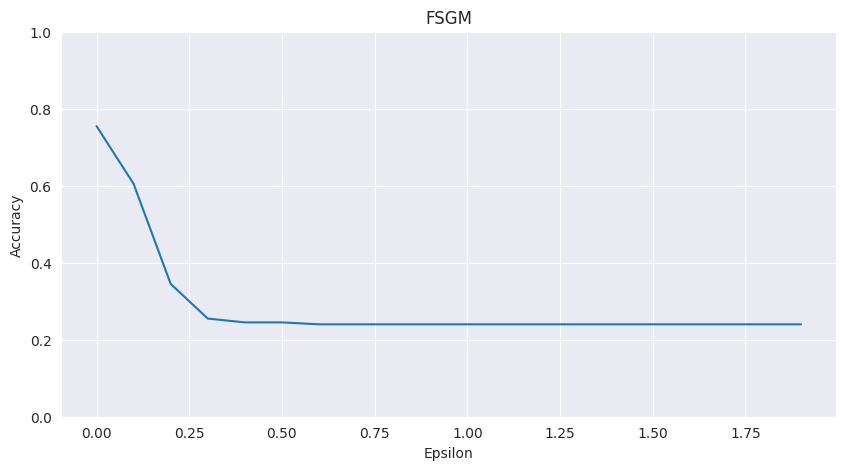

Accuracy on adversarial test examples with FGSM attack: 24.0%
Steps of accuracy [0.755, 0.605, 0.345, 0.255, 0.245, 0.245, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24]


In [126]:
classifier = build_classifier()
predictions_benign = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
print('\nFGSM')
Xtest_FGM, attack_FGM = FGSM(classifier)

## PGD $L^{inf}$

The basic approach of PGD is to re-iterate the updates that we have seen with FGSM. With PGD we have more choices such as the actual stepsize itself, and the number of iterations. PGD is also a white-box, non-targeted evasion attack. White-box, since we need to know the gradients of the model to create the adversarial examples. PGD calculates the gradient multiple times. PGD attempts to find the perturbation that maximises the loss of a model on a particular input while keeping the size of the perturbation smaller than $\epsilon$.

PGD performance is limited by the possibility of local optima within the objective. To partial overcome this problem, we don’t just run PGD once, but we run it multiple times from different random locations within the $L^{inf}$ ball.   

In [10]:
def PGD(classifier, target, y_target, norm):
    PGD_range = np.arange(0.0, 2, 0.1)
    PGD_acc = []
    for eps in PGD_range:
        if(norm == 2):
            attack_PGD = ProjectedGradientDescent(classifier, eps=eps, eps_step=0.1, max_iter=100, num_random_init=1, targeted=target, verbose=False, norm=norm)
        else:
            attack_PGD = ProjectedGradientDescent(classifier, eps=eps, eps_step=0.01, max_iter=100, num_random_init=1, targeted=target, verbose=False)
        if(y_target.all()):
            X_test_PGD = attack_PGD.generate(x=np.array(X_test))
        else:
            X_test_PGD = attack_PGD.generate(x=np.array(X_test),y=np.array(y_target))
            
        preds_PGD = classifier.predict(X_test_PGD)
        accuracy_PGD = np.sum(np.argmax(preds_PGD, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
        PGD_acc.append(accuracy_PGD)
    
    '''PLOT'''
    plt.figure(figsize=(10,5))
    if(y_target.all()): 
        if(norm == 2):
            plt.title("Untargeted PGD $L^{2}$") 
        else:
            plt.title("Untargeted PGD $L^{inf}$") 
    else: plt.title("Targeted PGD $L^{inf}$")
        
    plt.ylabel('Accuracy')
    plt.xlabel('Epsilon')
    plt.ylim((0,1))
    plt.plot(PGD_range, PGD_acc)
    
    plt.show()
    print("Accuracy on adversarial test examples with PGD attack: {}%".format(accuracy_PGD * 100))
    print(f"Steps of accuracy {PGD_acc}")
    return X_test_PGD, attack_PGD

2024-01-24 01:26:50.219116: W tensorflow/c/c_api.cc:305] Operation '{name:'training_172/Adam/dense_258/kernel/v/Assign' id:37137 op device:{requested: '', assigned: ''} def:{{{node training_172/Adam/dense_258/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_172/Adam/dense_258/kernel/v, training_172/Adam/dense_258/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-24 01:26:51.660187: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_260/Sigmoid' id:36884 op device:{requested: '', assigned: ''} def:{{{node dense_260/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_260/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trig

Accuracy on benign test examples: 70.5%
PGD


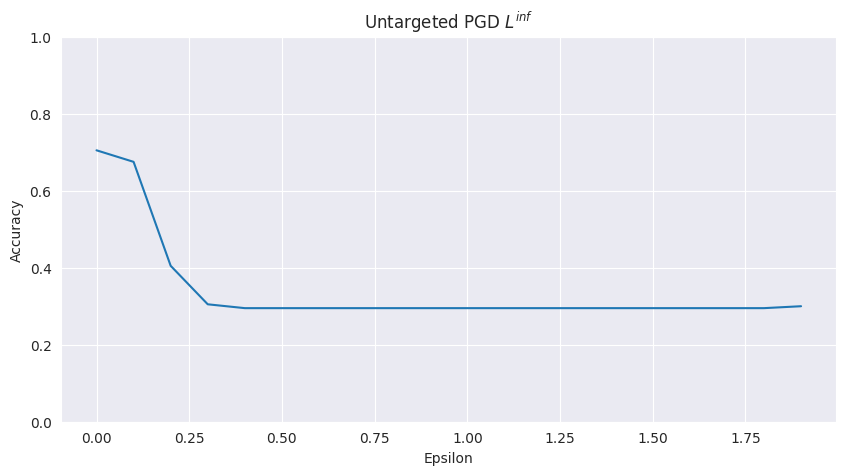

Accuracy on adversarial test examples with PGD attack: 30.0%
Steps of accuracy [0.705, 0.675, 0.405, 0.305, 0.295, 0.295, 0.295, 0.295, 0.295, 0.295, 0.295, 0.295, 0.295, 0.295, 0.295, 0.295, 0.295, 0.295, 0.295, 0.3]


In [139]:
classifier = build_classifier()
predictions_benign = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
print('PGD')
X_test_PGD_uinf, attack_PGD_uinf = PGD(classifier, False, np.empty(0), np.inf)

## Targeted PGD $L^{inf}$

In this case ninstead of maximizing the loss of the true label, we maximize the loss of the loss of the true label and also minimize the loss for the alternative label.

2024-01-24 14:30:04.058347: W tensorflow/c/c_api.cc:305] Operation '{name:'training_40/Adam/dense_61/kernel/m/Assign' id:9263 op device:{requested: '', assigned: ''} def:{{{node training_40/Adam/dense_61/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_40/Adam/dense_61/kernel/m, training_40/Adam/dense_61/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-24 14:30:04.463740: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_62/Sigmoid' id:9032 op device:{requested: '', assigned: ''} def:{{{node dense_62/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_62/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error 

Accuracy on benign test examples: 70.0%
PGD


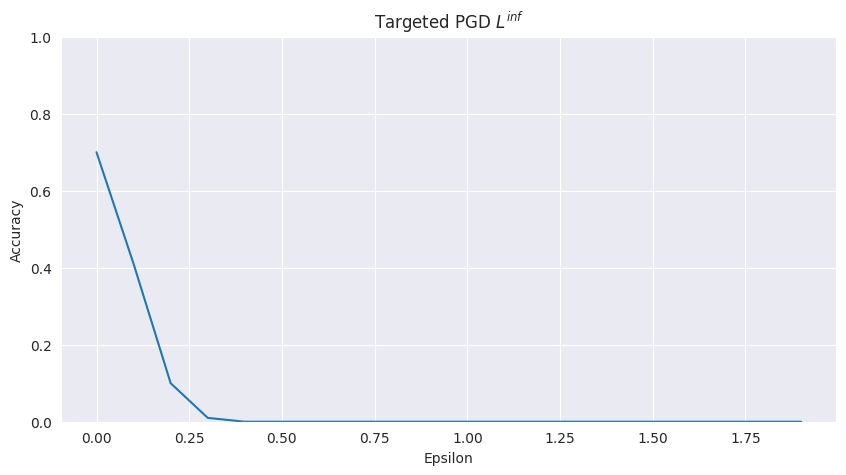

Accuracy on adversarial test examples with PGD attack: 0.0%
Steps of accuracy [0.7, 0.41, 0.1, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [58]:
classifier = build_classifier()
predictions_benign = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
print('PGD')
targets = random_targets(onehot_y_test, nb_classes=2) #swap 0 and 1
X_test_PGD_tinf, attack_PGD_tinf = PGD(classifier, True, targets, np.inf)

## PGD $L^{2}$

In this case the $\epsilon$ we need to consider for $L^2$ norm perturbations is larger than what we need for $L^{inf}$ perturbations, because the volume of the $L^2$ ball is proportional to $\sqrt{n}$ times the volume of the $L^{inf}$ ball.

It's important to note that this means that $L^{inf}$ attacks lead to small noise (not good for adversarial training defence) comparing to $L^2$ attack.

2024-01-24 01:22:51.747699: W tensorflow/c/c_api.cc:305] Operation '{name:'training_168/Adam/learning_rate/Assign' id:36240 op device:{requested: '', assigned: ''} def:{{{node training_168/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_168/Adam/learning_rate, training_168/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-24 01:22:54.073496: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_254/Sigmoid' id:36028 op device:{requested: '', assigned: ''} def:{{{node dense_254/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_254/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error

Accuracy on benign test examples: 76.0%
PGD


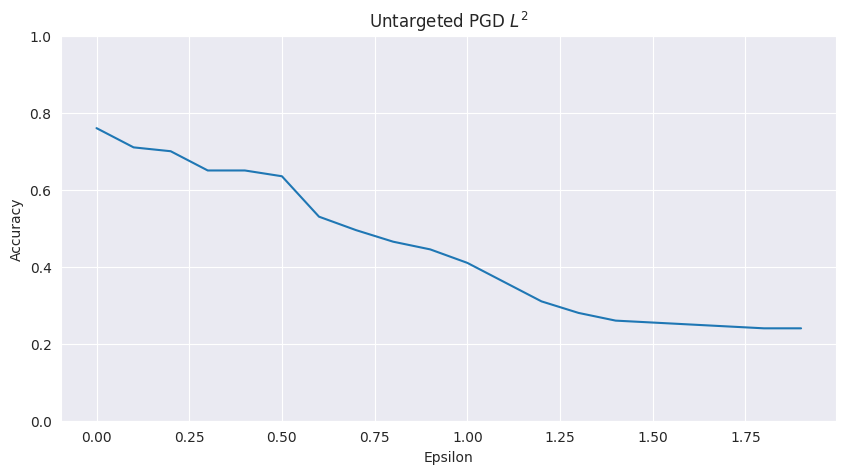

Accuracy on adversarial test examples with PGD attack: 24.0%
Steps of accuracy [0.76, 0.71, 0.7, 0.65, 0.65, 0.635, 0.53, 0.495, 0.465, 0.445, 0.41, 0.36, 0.31, 0.28, 0.26, 0.255, 0.25, 0.245, 0.24, 0.24]


In [136]:
classifier = build_classifier()
predictions_benign = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
print('PGD')
X_test_PGD_u2, attack_PGD_u2 = PGD(classifier, False, np.empty(0), 2)

## DeepFool 

DeepFool is a white-box attack. The goal of the DeepFool attack is to generate a minimal perturbation to an input data point that causes the classifier to misclassify it. The attack is iterative and works by computing the gradient of the classifier's decision boundary with respect to the input features. DeepFool calculates the minimal perturbation needed to move the input point across the decision boundary and iteratively adjusts the input in the direction that is orthogonal to the decision boundary. The perturbation is then calculated by considering the linear approximation of the decision boundary. It aims to minimize the distance between the original input and the perturbed input, while ensuring misclassification. 

DeepFool algorithm computes the perturbation by having the output prediction of the classifier decision function divided by the L2 norm of the computed gradient of the loss function.  (formula)

In [31]:
classifier=build_classifier()
predictions_benign = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

attack_DF = DeepFool(classifier=classifier)
Xtest_DF = attack_DF.generate(x=np.array(X_test))
preds_DF = classifier.predict(Xtest_DF)
accuracy_DF = np.sum(np.argmax(preds_DF, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on adversarial test examples with DF attack: {}%".format(accuracy_DF * 100))

2024-01-24 13:48:59.016663: W tensorflow/c/c_api.cc:305] Operation '{name:'training_28/Adam/dense_43/kernel/m/Assign' id:6646 op device:{requested: '', assigned: ''} def:{{{node training_28/Adam/dense_43/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_28/Adam/dense_43/kernel/m, training_28/Adam/dense_43/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-24 13:48:59.421667: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_44/Sigmoid' id:6415 op device:{requested: '', assigned: ''} def:{{{node dense_44/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_44/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error 

Accuracy on benign test examples: 72.0%


DeepFool: 100%|██████████| 200/200 [00:10<00:00, 19.17it/s]

Accuracy on adversarial test examples with DF attack: 29.5%


# Decision Based Attack

A decision based attack is a black-box attack which generates adversarial samples via iterative optimizations using repeated queries. This is a powerful black-box attack because only requires final class prediction. They try not to rely on any classifier specific information (like gradients), except final decisions. 

## HopSkipJump 
HSJ is an optimization-based attack that iteratively refines the perturbation to move the input across the decision boundary while minimizing the perturbation size

In [61]:
classifier=build_classifier()
predictions_benign = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

attack_HSJ = HopSkipJump(classifier=classifier)
Xtest_HSJ = attack_HSJ.generate(np.array(X_test))
preds_HSJ = classifier.predict(Xtest_HSJ)
accuracy_HSJ = np.sum(np.argmax(preds_HSJ, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on adversarial test examples with HSJ attack: {}%".format(accuracy_HSJ * 100))

2024-01-24 14:32:38.500118: W tensorflow/c/c_api.cc:305] Operation '{name:'training_44/Adam/dense_66/kernel/v/Assign' id:10141 op device:{requested: '', assigned: ''} def:{{{node training_44/Adam/dense_66/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_44/Adam/dense_66/kernel/v, training_44/Adam/dense_66/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-24 14:32:38.919553: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_68/Sigmoid' id:9888 op device:{requested: '', assigned: ''} def:{{{node dense_68/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_68/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error

Accuracy on benign test examples: 71.0%


HopSkipJump: 100%|██████████| 200/200 [02:47<00:00,  1.20it/s]

Accuracy on adversarial test examples with HSJ attack: 47.5%


## 4.4 Adversarial Training with ART AdversarialTrainer

The basic idea is to simply create and then incorporate adversarial examples into the training process.


In [15]:
def adversarialTraining(classifier, attack, X_test, X_test_attack, X_train, y_train):
    #Create adversarial trainer and perform adversarial training
    adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=1)
    adv_trainer.fit(X_train.values, y_train.values, batch_size=64, nb_epochs=3)
    
    # Evaluate the adversarially trained model on clean test set
    predictions_clean = classifier.predict(X_test)
    accuracy = np.sum(np.argmax(predictions_clean, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on clean test examples with adverarially trained model: {}%".format(accuracy * 100))
    
    # Evaluate the adversarially trained model on original adversarial samples
    preds_ATTACK_original = classifier.predict(X_test_attack)
    accuracy = np.sum(np.argmax(preds_ATTACK_original, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on original adversarial examples with adverarially trained model: {}%".format(accuracy * 100))
    
    # Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
    X_test_ATTACK_new = attack.generate(x=np.array(X_test))       #PGD method already defined before with best eps computed
    preds_ATTACK_new = classifier.predict(X_test_ATTACK_new)
    accuracy = np.sum(np.argmax(preds_ATTACK_new, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on new adversarial examples with adverarially trained model: {}%".format(accuracy * 100))

## Gradient-based

### Adversarial Training FGSM

In [127]:
print("Retrieving Accuracy on benign test examples: {}%".format(accuracy * 100))
for i in range(3):
    print(f"\nADV_training : iteration {i+1}")
    adversarialTraining(classifier, attack_FGM, X_test, Xtest_FGM, X_train_validation, onehot_y_train)

Retrieving Accuracy on benign test examples: 75.5%

ADV_training : iteration 1


Adversarial training epochs: 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]


Accuracy on clean test examples with adverarially trained model: 69.0%
Accuracy on original adversarial examples with adverarially trained model: 73.5%
Accuracy on new adversarial examples with adverarially trained model: 59.0%

ADV_training : iteration 2


Adversarial training epochs: 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]


Accuracy on clean test examples with adverarially trained model: 69.5%
Accuracy on original adversarial examples with adverarially trained model: 69.5%
Accuracy on new adversarial examples with adverarially trained model: 62.5%

ADV_training : iteration 3


Adversarial training epochs: 100%|██████████| 3/3 [00:00<00:00,  7.84it/s]

Accuracy on clean test examples with adverarially trained model: 70.0%
Accuracy on original adversarial examples with adverarially trained model: 69.0%
Accuracy on new adversarial examples with adverarially trained model: 67.0%


### Adversarial Training PGD $L^{inf}$

In [140]:
print("Retrieving Accuracy on benign test examples: {}%".format(accuracy * 100))
for i in range(3):
    print(f"\nADV_training : iteration {i+1}")
    adversarialTraining(classifier, attack_PGD_uinf, X_test, X_test_PGD_uinf, X_train_validation, onehot_y_train)

Retrieving Accuracy on benign test examples: 70.5%

ADV_training : iteration 1


Adversarial training epochs: 100%|██████████| 3/3 [00:13<00:00,  4.50s/it]


Accuracy on clean test examples with adverarially trained model: 70.0%
Accuracy on original adversarial examples with adverarially trained model: 65.5%
Accuracy on new adversarial examples with adverarially trained model: 49.0%

ADV_training : iteration 2


Adversarial training epochs: 100%|██████████| 3/3 [00:12<00:00,  4.07s/it]


Accuracy on clean test examples with adverarially trained model: 70.0%
Accuracy on original adversarial examples with adverarially trained model: 69.0%
Accuracy on new adversarial examples with adverarially trained model: 68.5%

ADV_training : iteration 3


Adversarial training epochs: 100%|██████████| 3/3 [00:12<00:00,  4.21s/it]


Accuracy on clean test examples with adverarially trained model: 70.0%
Accuracy on original adversarial examples with adverarially trained model: 69.5%
Accuracy on new adversarial examples with adverarially trained model: 67.0%


### Adversarial Training PGD L^2

In [137]:
print("Retrieving Accuracy on benign test examples: {}%".format(accuracy * 100))
for i in range(3):
    print(f"\nADV_training : iteration {i+1}")
    adversarialTraining(classifier, attack_PGD_u2, X_test, X_test_PGD_u2, X_train_validation, onehot_y_train)

Retrieving Accuracy on benign test examples: 76.0%

ADV_training : iteration 1


Adversarial training epochs: 100%|██████████| 3/3 [00:16<00:00,  5.39s/it]


Accuracy on clean test examples with adverarially trained model: 70.0%
Accuracy on original adversarial examples with adverarially trained model: 70.0%
Accuracy on new adversarial examples with adverarially trained model: 60.5%

ADV_training : iteration 2


Adversarial training epochs: 100%|██████████| 3/3 [00:13<00:00,  4.40s/it]


Accuracy on clean test examples with adverarially trained model: 70.0%
Accuracy on original adversarial examples with adverarially trained model: 70.0%
Accuracy on new adversarial examples with adverarially trained model: 70.0%

ADV_training : iteration 3


Adversarial training epochs: 100%|██████████| 3/3 [00:14<00:00,  4.95s/it]


Accuracy on clean test examples with adverarially trained model: 70.0%
Accuracy on original adversarial examples with adverarially trained model: 70.0%
Accuracy on new adversarial examples with adverarially trained model: 70.0%


### Adversarial Training PGD $L^{inf}$ Targeted

In [56]:
def adversarialTrainingManual(classifier,attack, X_test, X_test_attack, X_train, y_train, targets, y_test):
    new_X_train_validation = pd.DataFrame(np.vstack((X_train, X_test_attack)))
    new_onehot_y_train = pd.DataFrame(np.vstack((y_train, y_test)))
    classifier.fit(new_X_train_validation, new_onehot_y_train, batch_size=64, nb_epochs=3)
    # Evaluate the adversarially trained model on clean test set
    predictions_benign = classifier.predict(X_test)
    accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on clean test examples with adverarially trained model: {}%".format(accuracy * 100))

    # Evaluate the adversarially trained model on original adversarial samples
    preds_ATTACK_original = classifier.predict(X_test_attack)
    accuracy = np.sum(np.argmax(preds_ATTACK_original, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on original adversarial examples with adverarially trained model: {}%".format(accuracy * 100))
    
    # Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
    X_test_ATTACK_new = attack.generate(x=np.array(X_test), y=np.array(targets)) #PGD method already defined before with best eps computed
    preds_ATTACK_new = classifier.predict(X_test_ATTACK_new)
    accuracy = np.sum(np.argmax(preds_ATTACK_new, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on new adversarial examples with adverarially trained model: {}%".format(accuracy * 100))

In [59]:
print("Retrieving Accuracy on benign test examples: {}%".format(accuracy * 100))
for i in range(3):
    print(f"\nADV_training : iteration {i+1}")
    adversarialTrainingManual(classifier,attack_PGD_tinf, X_test, X_test_PGD_tinf, X_train_validation, onehot_y_train, targets, onehot_y_test)

Retrieving Accuracy on benign test examples: 70.0%

ADV_training : iteration 1
Accuracy on clean test examples with adverarially trained model: 70.0%
Accuracy on original adversarial examples with adverarially trained model: 89.0%
Accuracy on new adversarial examples with adverarially trained model: 0.0%

ADV_training : iteration 2
Accuracy on clean test examples with adverarially trained model: 69.5%
Accuracy on original adversarial examples with adverarially trained model: 97.0%
Accuracy on new adversarial examples with adverarially trained model: 0.0%

ADV_training : iteration 3
Accuracy on clean test examples with adverarially trained model: 76.0%
Accuracy on original adversarial examples with adverarially trained model: 99.5%
Accuracy on new adversarial examples with adverarially trained model: 0.0%


### Adversarial Training DeepFool

In [32]:
print("Retrieving Accuracy on benign test examples: {}%".format(accuracy * 100))
for i in range(3):
    print(f"\nADV_training : iteration {i+1}")
    adversarialTraining(classifier, attack_DF, X_test, Xtest_DF, X_train_validation, onehot_y_train)

Retrieving Accuracy on benign test examples: 72.0%

ADV_training : iteration 1


Adversarial training epochs: 100%|██████████| 3/3 [04:25<00:00, 88.62s/it] 


Accuracy on clean test examples with adverarially trained model: 70.0%
Accuracy on original adversarial examples with adverarially trained model: 70.0%
Accuracy on new adversarial examples with adverarially trained model: 41.0%

ADV_training : iteration 2


Adversarial training epochs: 100%|██████████| 3/3 [04:38<00:00, 92.85s/it]


Accuracy on clean test examples with adverarially trained model: 70.0%
Accuracy on original adversarial examples with adverarially trained model: 70.0%
Accuracy on new adversarial examples with adverarially trained model: 39.5%

ADV_training : iteration 3


Adversarial training epochs: 100%|██████████| 3/3 [06:16<00:00, 125.55s/it]


Accuracy on clean test examples with adverarially trained model: 70.0%
Accuracy on original adversarial examples with adverarially trained model: 70.0%
Accuracy on new adversarial examples with adverarially trained model: 66.5%


## Gradient Obfuscation detection - Security Curve for PGD $L^{\inf}$ Untargeted


PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


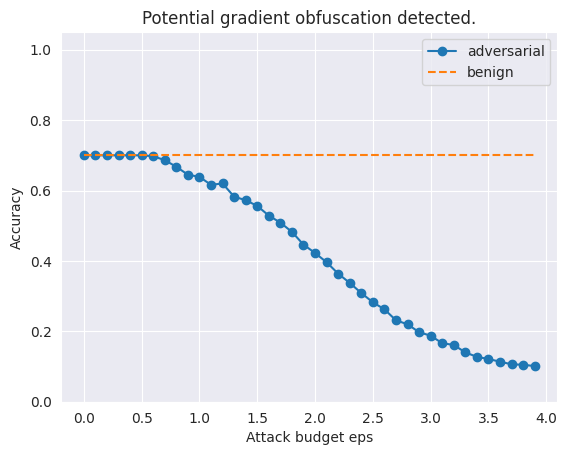

In [142]:
PGD_range = np.arange(0.0, 4, 0.1)
curve = SecurityCurve(eps=PGD_range)
curve.evaluate(classifier, X_train_validation.values, onehot_y_train.values)
curve.plot()

## Decision-based 

In [63]:
print("Retrieving Accuracy on benign test examples: {}%".format(accuracy * 100))
'''for i in range(3):
    print(f"\nADV_training : iteration {i+1}")'''
'''adversarialTraining(classifier, attack_HSJ, X_test, Xtest_HSJ, X_train_validation, onehot_y_train)'''

Retrieving Accuracy on benign test examples: 71.0%


'adversarialTraining(classifier, attack_HSJ, X_test, Xtest_HSJ, X_train_validation, onehot_y_train)'